## Analyze TMAs <a name="intro"></a> 

[contents](#contents)

**Samples:** 
- JP-TMA-1
- JP-TMA-2 (only 2 ER+, and no survival data)
- IMC Basel TMA
- IMC Zurich TMA (no survival data)

** note **

Use only IMC images thats pass QC on ER staining.

**Method**: 

- single variable, clustering, neighbors in 25 um radius

- compare cell types, cell neighborhoods in high proliferation versus low proliferation

I show that proliferating tumors survive longer with high immune in ER+ high prolif, TNBC, but not 
ER+ low prolif. so, what are differences between TNBC, high prolif ER+ and low prolif ER+? immune
activation? Immune spatial distribution and neighbors? (Ripleys K)

Separately, I show that vim+ fibroblast tumor-neighborhoods are poor prognosis in TNBC. Why does
the spatial distribution matter? Are Vim+ FB alone poor prognosis (no). If the ones closer to tumor 
matter more, are they associated with a certain tumor phenotype? (less correlation with CK low) Or are they associated with 
immune exclusion and immune suppression? (correlate with macrophage)

Answer these two questions and the figures will be complete.  


In [1]:
#load libraries

import os
import itertools
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import math
import warnings


import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
mpl.rc('figure', max_open_warning = 0)

import sklearn
from sklearn.preprocessing import minmax_scale, scale, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines import exceptions
warnings.filterwarnings("ignore",category = exceptions.ApproximationWarning)

import scipy
from scipy import stats
from scipy.stats import entropy, norm
from scipy.spatial import cKDTree

import statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm


import anndata
from anndata import AnnData
from bioinfokit import analys, visuz

#import phenograph

codedir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/20200000/20200406_JP-TMAs' #os.getcwd()

os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data')
from mplex_image import visualize as viz, process, preprocess, normalize, mics, mpimage
from spatial import spatial
np.random.seed(912)

In [2]:
#change to correct directory
datadir = f'/home/groups/graylab_share/OMERO.rdsStore/engje/Data/20200000/20200406_JP-TMAs/data'
s_date = '20220912'
os.chdir(codedir)
if not os.path.exists(s_date):
    os.mkdir(s_date)
    os.mkdir(f'{s_date}/Survival_Plots')
    os.mkdir(f'{s_date}/Survival_Plots_Both')
%matplotlib inline

# Table of contents <a name="contents"></a>
0. [Intro](#intro)
1. [functions](#func)
2. [Load annotation](#loadold)
3. [Load cell types and name (DONE)](#cluster)
4. [Tissue means (DONE)](#tissue)
5. [Single variable survival](#surv) [with clinical varables](#clin)
6. [Multivariable Subtyping survival](#subtIMC) [1 Platforms together (epithelial)](#st1) [2 Platforms separate (stromal)](#st2)  
7. [Tissue correlation (Pearson & chi square)](#st3) [LDA correlation and survival](#lda_corr)
8. [Categorical Regression](#st4)  [ER+ vs endothelial](#slide15) [TNBC, ER+ high low prolif](#byimmune)
8. [Mixing score vs survival](#n1) 
9. [Boxplots OLD Neighborhoods](#leidneigh)  [Survival](#leidneighsurv)
10. [Immune phenotype of proliferating tumors](#imph)
11. [Immune spatial distribution of proliferating tumors](#imm_sp)
12. [Correlation of spatial metrics](#metric)
11.[Neighborhood enrichment Squidpy](#sqpy)
12. [Distances to collagen](#dist)

TO DO:
massive correlaiton with neighborhoods
- probably importnat ot name neighborhoods
- look into the neighborhoods images

## functions <a name="func"></a> 

[contents](#contents)

In [ ]:

def km_cph_all(df_both,df_clin,s_title1,s_title2,s_marker,alpha=0.05,s_time='Survival_time', s_censor='Survival',
               s_groups='abundance',s_cph_model='high',ls_clin=['age','tumor_size','Stage']):
    '''
    df_both must have s_time, s_censor, s_groups
    s_marker: rename anudance_high into somthing more meaningful for CPH plots
    df_clin: clinical covariates data frame
    ls_clin = clinical covariates columns
    '''
    ### log rank ###
    if len(df_both) > 0:
        results = multivariate_logrank_test(event_durations=df_both.loc[:,s_time],
            groups=df_both.loc[:,s_groups], event_observed=df_both.loc[:,s_censor])
        pvalue_km = results.summary.p[0]
    else: 
        pvalue_km = 1
    #kaplan meier plotting
    if pvalue_km < alpha:
        kmf = KaplanMeierFitter()
        fig1, ax = plt.subplots(figsize=(3,3),dpi=300)
        for s_group in sorted(df_both.loc[:,s_groups].unique()):
            df_abun = df_both[df_both.loc[:,s_groups]==s_group]
            durations = df_abun.loc[:,s_time]
            event_observed = df_abun.loc[:,s_censor]
            kmf.fit(durations, event_observed,label=s_group) #try:#except:#results.summary.p[0] = 1
            kmf.plot(ax=ax,ci_show=False,show_censors=True)
        ax.set_title(f'{s_title1}\n{s_title2}\n p={pvalue_km:.2} n={len(df_both)}')
        ax.legend(loc='upper right',title=f'{s_groups}')
        ax.set_xlabel(s_time)
        plt.tight_layout()  
    else:
        fig1 = None
    ##### CPH ######
    cph = CoxPHFitter(penalizer=0.1)
    try:
        df_dummy = pd.get_dummies(df_both).loc[:,[s_time,s_censor,f'{s_groups}_{s_cph_model}']]
        df_dummy = df_dummy.rename({f'{s_groups}_{s_cph_model}':s_marker},axis=1)
        df_dummy.index = df_dummy.index.astype('str')
        df_marker = df_dummy.merge(df_clin,left_index=True,right_index=True).loc[:,[s_time,s_censor,s_marker] + ls_clin]
        df_marker = df_marker.dropna()
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            #multi
            cph.fit(df_marker, s_time, event_col=s_censor) 
            pvalue = cph.summary.loc[s_marker,'p']
    except:
        pvalue = 1
    if pvalue < alpha:
        fig2, ax = plt.subplots(figsize=(3.2,2),dpi=200)
        cph.plot(ax=ax)
        ax.set_title(f'{s_title1}\n{s_title2}\n{s_censor} p={pvalue:.2} n={len(df_marker)}')
        plt.tight_layout()
    else:
        fig2 = None
    return(fig1, fig2)


def plt_sig2(df_test,ax):
    ls_order = df_test.group1.append(df_test.group2).unique()
    props = {'connectionstyle':matplotlib.patches.ConnectionStyle.Bar(armA=0.0, armB=0.0, fraction=0.0, angle=None),
             'arrowstyle':'-','linewidth':.5}
    #draw on axes
    y_lim = ax.get_ylim()[1]
    y_lim_min = ax.get_ylim()[0]
    y_diff = (y_lim-y_lim_min)/10
    for count, s_index in enumerate(df_test[df_test.reject].index):
        y_test = (y_diff+count*y_diff)
        text =f"p = {df_test.loc[s_index,'p-adj']:.1}"
        one = df_test.loc[s_index,'group1']
        two = df_test.loc[s_index,'group2']
        x_one = np.argwhere(ls_order == one)[0][0]
        x_two = np.argwhere(ls_order == two)[0][0]
        ax.annotate(text, xy=(np.mean([x_one,x_two]),y_lim - y_test),fontsize=6)
        ax.annotate('', xy=(x_one,y_lim - y_test), xytext=(x_two,y_lim - y_test), arrowprops=props)
        #break
    return(ax)

def more_plots(adata,df_p,s_subtype,s_type,s_partition,s_cell,n_neighbors,resolution,z_score,linkage,
               s_color_p='Platform',d_color_p = {'cycIF':'gold','IMC':'darkblue'},savedir=f'{codedir}/20220222/Survival_Plots_Both'):
    #more plots
    #color by platform/leiden
    from matplotlib.pyplot import gcf
    d_color = dict(zip(sorted(adata.obs.leiden.unique()),sns.color_palette()[0:len(adata.obs.leiden.unique())]))
    
    network_colors = df_p.leiden.astype('str').map(d_color)#
    network_colors.name = 'cluster'
    node_colors  = df_p.loc[:,s_color_p].astype('str').map(d_color_p)
    network_node_colors = pd.DataFrame(node_colors).join(pd.DataFrame(network_colors))

    g = sns.clustermap(df_p.loc[:,ls_col].dropna(),figsize=(7,6),cmap='viridis',
            row_colors=network_node_colors,method=linkage,dendrogram_ratio=0.16)
    for label,color in d_color_p.items():
        g.ax_col_dendrogram.bar(0, 0, color=color,label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(loc="right", ncol=1,bbox_to_anchor=(-0.1, 0.72),bbox_transform=gcf().transFigure)
    for label,color in d_color.items():
        g.ax_row_dendrogram.bar(0, 0, color=color,label=label, linewidth=0)
    l2 = g.ax_row_dendrogram.legend(loc="right", ncol=1,bbox_to_anchor=(-0.1, 0.5),bbox_transform=gcf().transFigure)
    g.savefig(f'{savedir}/clustermap_PlatformandSubtype_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png',dpi=200)

    #subtypes' mean
    d_replace = {}
    df_plot = df_p.loc[:,ls_col.tolist()+['leiden']].dropna().groupby('leiden').mean()
    df_plot.index.name = f'leiden {resolution}'
    g = sns.clustermap(df_plot.dropna().T,z_score=z_score,figsize=(4,len(ls_col)*.25+1),cmap='viridis',vmin=-2,vmax=2,method='ward')
    g.fig.suptitle(f'leiden {resolution}',x=.9) 
    g.savefig(f'{savedir}/clustermap_subtypes_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png',dpi=200)
    marker_genes = df_plot.dropna().T.iloc[:,g.dendrogram_col.reordered_ind].columns.tolist()
    categories_order = df_plot.dropna().T.iloc[g.dendrogram_row.reordered_ind,:].index.tolist()
    #barplot
    fig,ax=plt.subplots(figsize=(2.5,2.5),dpi=200)
    df_p.groupby(['leiden','Platform','Subtype']).count().iloc[:,0].unstack().loc[marker_genes].plot(kind='barh',title='Patient Count',ax=ax)
    plt.tight_layout()
    fig.savefig(f'{savedir}/barplot_subtyping_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png')


## find best cutpoint 
def low_high_abun(df_all,s_subtype,s_plat,s_col):
    df_all.index = df_all.index.astype('str')
    df = df_all[(df_all.Platform==s_plat) & (df_all.subtype==s_subtype)].copy()
    if len(df) > 0:
        #KM
        i_cut = np.quantile(df.loc[:,s_col],cutp)
        b_low = df.loc[:,s_col] <= i_cut
        if i_cut == 0:
            b_low = df.loc[:,s_col] <= 0
        df.loc[b_low,'abundance'] = 'low'
        df.loc[~b_low,'abundance'] = 'high'
    return(df)
    
def single_km(df_all,s_cell,s_subtype,s_plat,s_col,savedir,alpha=0.05,cutp=0.5,s_time='Survival_time',
              s_censor='Survival',s_propo='in'):
    df_all.index = df_all.index.astype('str')
    df = df_all[(df_all.Platform==s_plat) & (df_all.subtype==s_subtype)].copy()
    df = df.loc[:,[s_col,s_time,s_censor]].dropna()
    if len(df) > 0:
        #KM
        i_cut = np.quantile(df.loc[:,s_col],cutp)
        b_low = df.loc[:,s_col] <= i_cut
        s_title1 = f'{s_subtype} {s_plat}'
        s_title2 = f'{s_col} {s_propo} {s_cell}'
        if i_cut == 0:
            b_low = df.loc[:,s_col] <= 0
        df.loc[b_low,'abundance'] = 'low'
        df.loc[~b_low,'abundance'] = 'high'
        #log rank
        results = multivariate_logrank_test(event_durations=df.loc[:,s_time],
                                            groups=df.abundance, event_observed=df.loc[:,s_censor])
        #kaplan meier plotting
        if results.summary.p[0] < alpha:
            kmf = KaplanMeierFitter()
            fig, ax = plt.subplots(figsize=(3,3),dpi=300)
            for s_group in ['high','low']:
                df_abun = df[df.abundance==s_group]
                durations = df_abun.loc[:,s_time]
                event_observed = df_abun.loc[:,s_censor]
                try:
                    kmf.fit(durations, event_observed,label=s_group)
                    kmf.plot(ax=ax,ci_show=False,show_censors=True)
                except:
                    results.summary.p[0] = 1
            ax.set_title(f'{s_title1}\n{s_title2}\nn={len(df)} p={results.summary.p[0]:.2}',fontsize=10)
            ax.set_xlabel(s_censor)
            ax.legend(loc='upper right',title=f'{cutp}({i_cut:.2})')
            plt.tight_layout()
            fig.savefig(f"{savedir}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}_{s_censor}.png",dpi=300)
        return(df)

warnings.filterwarnings("default",category = exceptions.ApproximationWarning)

In [ ]:
#functions

import matplotlib
def df_from_mcomp(m_comp):
    df_test = pd.DataFrame.from_records(m_comp.summary().data,coerce_float=True)
    df_test.columns=df_test.loc[0].astype('str')
    df_test.drop(0,inplace=True)
    df_test =df_test.apply(pd.to_numeric, errors='ignore')
    ls_order = df_test.group1.append(df_test.group2).unique()
    return(df_test, ls_order)
def plt_sig(df_test,ax,ax_factor=5):
    ls_order = df_test.group1.append(df_test.group2).unique()
    props = {'connectionstyle':matplotlib.patches.ConnectionStyle.Bar(armA=0.0, armB=0.0, fraction=0.0, angle=None),
             'arrowstyle':'-','linewidth':.5}
    #draw on axes
    y_lim = ax.get_ylim()[1]
    y_lim_min = ax.get_ylim()[0]
    y_diff = y_lim-y_lim_min
    for count, s_index in enumerate(df_test[df_test.reject].index):
        text =f"p = {df_test.loc[s_index,'p-adj']:.1}"
        #text = "*"
        one = df_test.loc[s_index,'group1']
        two = df_test.loc[s_index,'group2']
        x_one = np.argwhere(ls_order == one)[0][0]
        x_two = np.argwhere(ls_order == two)[0][0]
        ax.annotate(text, xy=(np.mean([x_one,x_two]),y_lim - (y_diff+count)/ax_factor),fontsize=6)
        ax.annotate('', xy=(x_one,y_lim - (y_diff+count)/ax_factor), xytext=(x_two,y_lim - (y_diff+count)/ax_factor), arrowprops=props)
        #break
    return(ax)
def post_hoc(confusion_matrix):
    chi2, pvalue, dof, expected  = stats.chi2_contingency(confusion_matrix)
    observed_vals = confusion_matrix
    expected_vals = pd.DataFrame(expected,index=confusion_matrix.index,columns=confusion_matrix.columns)
    result_val = pd.DataFrame(data='',index=confusion_matrix.index,columns=confusion_matrix.columns)
    col_sum = observed_vals.sum(axis=1)
    row_sum = observed_vals.sum(axis=0)

    for indx in confusion_matrix.index:
        for cols in confusion_matrix.columns:
            observed = float(observed_vals.loc[indx,cols])
            expected = float(expected_vals.loc[indx,cols])
            col_total = float(col_sum[indx])
            row_total = float(row_sum[cols])
            expected_row_prop = expected/row_total
            expected_col_prop = expected/col_total
            std_resid = (observed - expected) / (math.sqrt(expected * (1-expected_row_prop) * (1-expected_col_prop)))
            p_val = norm.sf(abs(std_resid))
            if p_val < 0.05/(len(confusion_matrix.index)*len(confusion_matrix.columns)):
                print(indx,cols, "***", p_val)
                result_val.loc[indx,cols] = '***'
            elif p_val < 0.05:
                print (indx,cols, '*', p_val)
                result_val.loc[indx,cols] = '*'
            else:
                print (indx,cols, 'not sig', p_val)
    print('cutoff')
    print(0.05/(len(confusion_matrix.index)*len(confusion_matrix.columns)))
    return(result_val)

def single_var_km_cph(df_all,df_surv,s_subtype,s_platform,s_cell,alpha=0.05,min_cutoff=0.003,savedir=f"/home/groups/graylab_share/OMERO.rdsStore/engje/Data/20200000/20200406_JP-TMAs/20220408/Survival_Plots"):
    df_all.index = df_all.index.astype('str')
    df_surv.index = df_surv.index.astype('str')
    df_all = df_all.merge(df_surv.loc[:,['Survival','Survival_time','subtype','Platform']],left_index=True,right_index=True)
    if s_platform == 'IMC':
        df = df_all[(df_all.Platform==s_platform) & (~df_all.index.str.contains('Z')) & (df_all.subtype==s_subtype)].copy()
    elif s_platform == 'cycIF':
        df = df_all[(df_all.Platform==s_platform) & (~df_all.index.str.contains('JP-TMA2')) & (df_all.subtype==s_subtype)].copy()
    else:
        df = df_all[(df_all.Platform==s_platform) & (df_all.subtype==s_subtype)].copy()
    df = df.dropna() #df.dropna(axis=1).dropna()
    #KM
    for s_col in df.columns.drop(['Survival','Survival_time','subtype','Platform']):
        b_low = df.loc[:,s_col] <= df.loc[:,s_col].median()
        s_title1 = f'{s_subtype} {s_platform}'
        s_title2 = f'{s_cell} {s_col.replace(".","")}'
        if df.loc[:,s_col].median() < min_cutoff:
            continue
        elif len(df) < 1:
            continue
        df.loc[b_low,'abundance'] = 'low'
        df.loc[~b_low,'abundance'] = 'high'
        #log rank
        results = multivariate_logrank_test(event_durations=df.Survival_time,
                                            groups=df.abundance, event_observed=df.Survival)
        if results.summary.p[0] < alpha:
            print(s_col)
            #kaplan meier plotting
            kmf = KaplanMeierFitter()
            fig, ax = plt.subplots(figsize=(3,3),dpi=300)
            for s_group in ['high','low']:
                df_abun = df[df.abundance==s_group]
                durations = df_abun.Survival_time
                event_observed = df_abun.Survival
                try:
                    kmf.fit(durations, event_observed,label=s_group)
                    kmf.plot(ax=ax,ci_show=False,show_censors=True)
                except:
                    print('.')
            ax.set_title(f'{s_title1}\n{s_title2}\np={results.summary.p[0]:.2} (n={len(df)})',fontsize=10)
            ax.legend(loc='upper right',title=f'{df.loc[:,s_col].median():.2}')
            plt.tight_layout()
            fig.savefig(f"{savedir}/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)
        #CPH
        cph2 = CoxPHFitter(penalizer=0.1)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            try:
                cph2.fit(df.loc[:,[s_col,'Survival_time','Survival']], duration_col='Survival_time', event_col='Survival')
                if cph2.summary.p[0] < alpha:
                    print(s_col)
                    fig, ax = plt.subplots(figsize=(2.5,2),dpi=300)
                    cph2.plot(ax=ax)
                    ax.set_title(f'{s_title1} (n={len(df)})\n{s_title2}\np={cph2.summary.p[0]:.2} ({df.loc[:,s_col].median():.2})',fontsize=10)
                    ax.set_ylabel(f'{s_col}')
                    ax.set_yticklabels([])
                    plt.tight_layout()
                    fig.savefig(f"{savedir}/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)
            except:
                print(f'skipped {s_col}')   
    return(df)


                
def make_adata(df, ls_col,df_surv, n_neighbors, s_subtype, s_type, s_partition, s_cell,ncols=4):
    print('making adata')
    adata = sc.AnnData(df.loc[:,ls_col].fillna(0))
    adata.raw = adata
    #reduce dimensionality
    sc.tl.pca(adata, svd_solver='auto')
    print('scaling')
    sc.pp.scale(adata, zero_center=False, max_value=20)
    print('calc umap')
    # calculate neighbors 
    sc.pp.neighbors(adata, n_neighbors=n_neighbors) 
    sc.tl.umap(adata)
    #color by markers   
    figname = f"Umapboth_markers_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}neigh.png"
    title=figname.split('.png')[0].replace('_',' ')
    sc.pl.umap(adata, color=ls_col,vmin='p1.5',vmax='p99.5',ncols=ncols,save=figname,size=250)
    #platform
    adata.obs['Platform'] = adata.obs.index.astype('str').map(dict(zip(df_surv.index.astype('str'),df_surv.Platform)))
    figname = f"Umapboth_Platform_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}neigh.png"
    title=figname.split('.png')[0].replace('_',' ')
    sc.pl.umap(adata, color='Platform',save=figname,size=250)
    #subtype
    adata.obs['subtype'] = adata.obs.index.astype('str').map(dict(zip(df_surv.index.astype('str'),df_surv.subtype)))
    #CAREFUL
    adata.obs['subtype'] = adata.obs['subtype'].fillna('TNBC')
    figname = f"Umapboth_subtype_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}neigh.png"
    title=figname.split('.png')[0].replace('_',' ')
    sc.pl.umap(adata, color='subtype',save=figname,size=250)
    return(adata)
def cluster_leiden(adata, resolution,n_neighbors, s_subtype, s_type, s_partition, s_cell):
    sc.tl.leiden(adata,resolution=resolution)
    fig,ax = plt.subplots(figsize=(2.5,2),dpi=200)
    figname=f'both_{s_subtype}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png'
    sc.pl.umap(adata, color='leiden',ax=ax,title=figname.split('.png')[0].replace('_',' '),wspace=.25,save=figname,size=40)
    return(adata)
def km_cph(adata,df_surv,s_subtype,s_plat,s_type,s_partition,s_cell,savedir=f'{codedir}/20220222/Survival_Plots_Both'):
    if type(adata) == anndata._core.anndata.AnnData:
        df_p = pd.DataFrame(data=adata.raw.X, index=adata.obs.index, columns=adata.var.index) #adata.to_df()
        df_p['Subtype'] = adata.obs.subtype
        df_p['leiden'] = adata.obs.leiden
        df_p['Platform'] = adata.obs.Platform
    else:
        df_p = adata
    df_p.index = df_p.index.astype('str')
    df_p['Survival'] = df_p.index.map(dict(zip(df_surv.index,df_surv.Survival)))
    df_p['Survival_time'] = df_p.index.map(dict(zip(df_surv.index,df_surv.Survival_time)))
    df_st = df_p[(df_p.Subtype==s_subtype)].dropna()
    if s_plat != 'Both':
        df_st = df_p[(df_p.Platform==s_plat) & (df_p.Subtype==s_subtype)].dropna()
    if not len(df_st) < 1:
        
        print(len(df_st)) 
        T = df_st['Survival_time']     ## time to event
        E = df_st['Survival']      ## event occurred or censored
        groups = df_st.loc[:,'leiden'] 
        kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
        fig, ax = plt.subplots(figsize=(3,3),dpi=200)
        for idx, s_group in enumerate(sorted(df_p.leiden.unique())):
            i1 = (groups == s_group)
            if sum(i1) > 0:
                kmf1.fit(T[i1], E[i1], label=s_group)    ## fit thedata
                kmf1.plot(ax=ax,ci_show=False,color=f'C{idx}',show_censors=True)
                print(f'{s_group}: {kmf1.median_survival_time_}, {kmf1.percentile(.75)} ({i1.sum()})')
        results = multivariate_logrank_test(event_durations=T, groups=groups, event_observed=E)
        ax.set_title(f'{s_subtype} {s_plat} {s_cell} \nk={resolution}  p={results.summary.p[0]:.1} n={len(df_st)}')
        ax.legend(loc='upper right')
        ax.set_ylim(-0.05,1.05)
        plt.tight_layout()
        fig.savefig(f'{savedir}/KM_{s_subtype}_{s_plat}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png',dpi=300)
        #CPH
        df_dummy = pd.get_dummies(df_st.loc[:,['Survival_time','Survival','leiden']])
        df_dummy = df_dummy.loc[:,df_dummy.sum() != 0]
        cph = CoxPHFitter(penalizer=0.1)  ## Instantiate the class to create a cph object
        cph.fit(df_dummy, 'Survival_time', event_col='Survival')
        fig, ax = plt.subplots(figsize=(2.5,3),dpi=200)
        cph.plot(ax=ax)
        pvalue = cph.summary.loc[:,'p'].min()
        ax.set_title(f'CPH: {s_subtype} {s_plat} {s_cell}\np={pvalue:.2}')
        plt.tight_layout()
        fig.savefig(f'{savedir}/CoxPH_{s_subtype}_{s_plat}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png',dpi=300)
    else:
        cph = 'zero'
    return(df_p, cph)

def km_cph_entropy(df_p,df,ls_col,s_subtype,s_plat,s_cell,savedir=f'{codedir}/20220222/Survival_Plots_Both'):
    df_p['entropy'] = entropy(df_p.loc[:,df_p.columns[df_p.dtypes=='float32']].fillna(0),axis=1,base=2)
    df_st = df_p[(df_p.Subtype==s_subtype)].dropna()
    if s_plat != 'Both':
        df_st = df_p[(df_p.Platform==s_plat) & (df_p.Subtype==s_subtype)].dropna()
    #######3 Entropy
    s_col = 'entropy'
    # no df and ls_col variable
    df_st = df.loc[:,ls_col].merge(df_st.loc[:,['Subtype','Platform','Survival','Survival_time','entropy']],left_index=True,right_index=True)
    if not len(df_st) < 1:
        b_low = df_st.loc[:,s_col] <= df_st.loc[:,s_col].median()
        if df_st.loc[:,s_col].median() == 0:
            b_low = df.loc[:,s_col] <= 0
        df_st.loc[b_low,'abundance'] = 'low'
        df_st.loc[~b_low,'abundance'] = 'high'
        kmf = KaplanMeierFitter()
        results = multivariate_logrank_test(event_durations=df_st.Survival_time, groups=df_st.abundance, event_observed=df_st.Survival)
        print(f'entropy {results.summary.p[0]}')
        if results.summary.p[0] < 0.2:
            fig, ax = plt.subplots(figsize=(3,3),dpi=200)
            for s_group in ['high','low']:
                    df_abun = df_st[df_st.abundance==s_group]
                    durations = df_abun.Survival_time
                    event_observed = df_abun.Survival
                    kmf.fit(durations, event_observed,label=s_group)
                    kmf.plot(ax=ax,ci_show=False,show_censors=True)
            s_title1 = f'{s_subtype} {s_plat}'
            s_title2 = f'{s_cell} {s_col}'
            ax.set_title(f'{s_title1}\n{s_title2}\np={results.summary.p[0]:.2}',fontsize=10)
            ax.legend(loc='upper right')
            plt.tight_layout()
            fig.savefig(f"{savedir}/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)
            cph = CoxPHFitter(penalizer=0.1)
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                try:
                    cph.fit(df_st.loc[:,[s_col,'Survival','Survival_time']], duration_col='Survival_time', event_col='Survival')
                    if cph.summary.p[0] < 0.1:
                        print(s_col)
                        fig, ax = plt.subplots(figsize=(2.5,2),dpi=200)
                        cph.plot(ax=ax)
                        s_title1 = f'{s_subtype} {s_plat}'
                        s_title2 = f'{s_cell} {s_col}'
                        ax.set_title(f'{s_title1}\n{s_title2}\np={cph.summary.p[0]:.2}',fontsize=10)
                        plt.tight_layout()
                        fig.savefig(f"{savedir}/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)
                except:
                    print(f'skipped {s_col}')   


def group_median_diff(df_marker,s_group,s_marker):
    lls_result = []
    for s_test in df_marker.loc[:,s_group].dropna().unique():
        ls_result = df_marker.loc[df_marker.loc[:,s_group] == s_test,s_marker].values
        lls_result.append(ls_result)
    if len(lls_result)==2:
        try:
            statistic, pvalue = stats.mannwhitneyu(lls_result[0],lls_result[1])
        except:
            print('error in group median diff mannwhitney')
            pvalue = 1
            statistic = None
    elif len(lls_result) > 2:
        try:
            statistic, pvalue = stats.kruskal(*lls_result,nan_policy='omit')
        except:
            print('error in group median diff kruskal')
            pvalue = 1
            statistic = None
    else:
        #print('no groups found')
        pvalue = None
        statistic = None
    #print(pvalue)
    return(statistic,pvalue)


#functions
def silheatmap(adata,clust,marker_list,sil_key):
    cluster_list = [str(item) for item in adata.uns[f'dendrogram_{clust}']['categories_ordered']]
    #dataframe
    df = adata.to_df()
    df[clust] = adata.obs[clust]
    #sort by sil
    df[sil_key] = adata.obs[sil_key]
    df = df.sort_values(by=sil_key)
    #sort by cluster, markers
    df['old_index'] = df.index
    obs_tidy = df.set_index(clust)
    obs_tidy.index = obs_tidy.index.astype('str')
    obs_tidy = obs_tidy.loc[cluster_list,:]
    df = df.loc[obs_tidy.old_index]
    obs_tidy = obs_tidy.loc[:,marker_list]
    #scale
    obs_tidy = pd.DataFrame(data=minmax_scale(obs_tidy),index=obs_tidy.index,columns=obs_tidy.columns)
    # define a layout of 3 rows x 3 columns
    # The first row is for the dendrogram (if not dendrogram height is zero)
    # second row is for main content. This col is divided into three axes:
    #   first ax is for the heatmap
    #   second ax is for 'brackets' if any (othwerise width is zero)
    #   third ax is for colorbar
    colorbar_width = 0.2
    var_names = marker_list
    width = 10
    dendro_height = 0.8 #if dendrogram else 0
    groupby_height = 0.13 #if categorical else 0
    heatmap_height = len(var_names) * 0.18 + 1.5
    height = heatmap_height + dendro_height + groupby_height + groupby_height
    height_ratios = [dendro_height, heatmap_height, groupby_height,groupby_height]
    width_ratios = [width, 0, colorbar_width, colorbar_width]
    fig = plt.figure(figsize=(width, height),dpi=200)
    axs = gridspec.GridSpec(
        nrows=4,
        ncols=4,
        wspace=1 / width,
        hspace=0.3 / height,
        width_ratios=width_ratios,
        height_ratios=height_ratios,
    )
    norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    norm2 = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)

    # plot heatmap
    heatmap_ax = fig.add_subplot(axs[1, 0])
    im = heatmap_ax.imshow(obs_tidy.T.values, aspect='auto',norm=norm,interpolation='nearest') # ,interpolation='nearest'
    heatmap_ax.set_xlim(0 - 0.5, obs_tidy.shape[0] - 0.5)
    heatmap_ax.set_ylim(obs_tidy.shape[1] - 0.5, -0.5)
    heatmap_ax.tick_params(axis='x', bottom=False, labelbottom=False)
    heatmap_ax.set_xlabel('')
    heatmap_ax.grid(False)
    heatmap_ax.tick_params(axis='y', labelsize='small', length=1)
    heatmap_ax.set_yticks(np.arange(len(var_names)))
    heatmap_ax.set_yticklabels(var_names, rotation=0)

    #colors
    value_sum = 0
    ticks = []  # list of centered position of the labels
    labels = []
    label2code = {}  # dictionary of numerical values asigned to each label
    for code, (label, value) in enumerate(
            obs_tidy.index.value_counts().loc[cluster_list].iteritems()
        ):
            ticks.append(value_sum + (value / 2))
            labels.append(label)
            value_sum += value
            label2code[label] = code

    groupby_cmap = mpl.colors.ListedColormap(adata.uns[f'{clust}_colors'])
    groupby_ax = fig.add_subplot(axs[3, 0])
    groupby_ax.imshow(
                np.array([[label2code[lab] for lab in obs_tidy.index]]),
                aspect='auto',
                cmap=groupby_cmap,
            )
    groupby_ax.grid(False)
    groupby_ax.yaxis.set_ticks([])
    groupby_ax.set_xticks(ticks,labels,fontsize='xx-small',rotation=90)
    groupby_ax.set_ylabel('Cluster',fontsize='x-small',rotation=0,ha='right',va='center')


    #sil
    sil_ax = fig.add_subplot(axs[2, 0])
    #max_index = df[sil_key].idxmax()    #df.loc[max_index,sil_key] = 1    #min_index = df[sil_key].idxmin()    #df.loc[min_index,sil_key] = -1 #not needed
    a=np.array([df[sil_key]]) #f'{clust}_silhuette'
    a_tile = np.tile(a,(int(len(df)/80),1))
    sil_ax.imshow(a_tile,cmap='bwr',norm=norm2)
    sil_ax.xaxis.set_ticks([])
    sil_ax.yaxis.set_ticks([])
    sil_ax.set_ylabel('Silhouette',fontsize='x-small',rotation=0,ha='right',va='center')
    sil_ax.grid(False)

    #dendrogram
    dendro_ax = fig.add_subplot(axs[0, 0], sharex=heatmap_ax)
    #_plot_dendrogram(dendro_ax, adata, groupby, dendrogram_key=dendrogram,ticks=ticks, orientation='top', )
    dendro_info = adata.uns[f'dendrogram_{clust}']['dendrogram_info']
    leaves = dendro_info["ivl"]
    icoord = np.array(dendro_info['icoord'])
    dcoord = np.array(dendro_info['dcoord'])
    orig_ticks = np.arange(5, len(leaves) * 10 + 5, 10).astype(float)
    for xs, ys in zip(icoord, dcoord):
        if ticks is not None:
            xs = translate_pos(xs, ticks, orig_ticks)
        dendro_ax.plot(xs, ys, color='#555555')
    dendro_ax.tick_params(bottom=False, top=False, left=False, right=False)
    ticks = ticks if ticks is not None else orig_ticks
    dendro_ax.set_xticks(ticks)
    #dendro_ax.set_xticklabels(leaves, fontsize='small', rotation=90)
    dendro_ax.set_xticklabels([])
    dendro_ax.tick_params(labelleft=False, labelright=False)
    dendro_ax.grid(False)
    dendro_ax.spines['right'].set_visible(False)
    dendro_ax.spines['top'].set_visible(False)
    dendro_ax.spines['left'].set_visible(False)
    dendro_ax.spines['bottom'].set_visible(False)

    # plot colorbar
    cbar_ax = fig.add_subplot(axs[1, 2])
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
    cbar = plt.colorbar(mappable=mappable, cax=cbar_ax)
    cbar_ax.tick_params(axis='both', which='major', labelsize='xx-small',rotation=90,length=.1)
    cbar_ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(locs=[0,1]))
    cbar.set_label('Expression', fontsize='xx-small',labelpad=-5)

    # plot colorbar2
    cbar_ax = fig.add_subplot(axs[1, 3])
    mappable = mpl.cm.ScalarMappable(norm=norm2, cmap='bwr')
    cbar = plt.colorbar(mappable=mappable, cax=cbar_ax)
    cbar_ax.tick_params(axis='both', which='major', labelsize='xx-small',rotation=90,length=.1)
    cbar_ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(locs=[-1,0,1]))
    cbar.set_label('Silhouette Score', fontsize='xx-small',labelpad=0)

    #return dict
    return_ax_dict = {'heatmap_ax': heatmap_ax}
    return_ax_dict['groupby_ax'] = groupby_ax
    return_ax_dict['dendrogram_ax'] = dendro_ax
    return(fig)

def translate_pos(pos_list, new_ticks, old_ticks):
    """
    transforms the dendrogram coordinates to a given new position.
    """
    # of given coordinates.

    if not isinstance(old_ticks, list):
        # assume that the list is a numpy array
        old_ticks = old_ticks.tolist()
    new_xs = []
    for x_val in pos_list:
        if x_val in old_ticks:
            new_x_val = new_ticks[old_ticks.index(x_val)]
        else:
            # find smaller and bigger indices
            idx_next = np.searchsorted(old_ticks, x_val, side="left")
            idx_prev = idx_next - 1
            old_min = old_ticks[idx_prev]
            old_max = old_ticks[idx_next]
            new_min = new_ticks[idx_prev]
            new_max = new_ticks[idx_next]
            new_x_val = ((x_val - old_min) / (old_max - old_min)) * (
                new_max - new_min
            ) + new_min
        new_xs.append(new_x_val)
    return new_xs

#functions

# count the neighbors.
class NeighborsCounter:

    def __init__(self, rad, xy=['CentroidX', 'CentroidY']):
        self.rad = rad
        self.xy = xy

    def query_balltree_vanilla(self, coords_np):
        """
        input coords_np:
            these are coordinates. possible shape: (N,2)

        output neighbor_indices:
            this is a list of lists.
            there is one list per row in coords_np (i.e. there are N)
            the i'th list contains the indices of the neighbors of i,
            not including itself.
        """
        n_points = coords_np.shape[0]
        print(f'Counting neighbors for {n_points} points.')

        tree = cKDTree(coords_np)
        neighbor_indices = tree.query_ball_tree(tree, self.rad)
        for i in range(n_points):
            neighbor_indices[i].remove(i)
        return neighbor_indices

    def run(self, dataframe):
        """
        Splits the input dataframe into cell types and coordinates
        Runs query_balltree_vanilla on the coordinates
        Uses the neighbor indices to get cell type neighbor counts.

        Input:
            a dataframe with boolean cell type columns and coordinate columns
            the coordinate columns by default are named ['CentroidX', 'CentroidY']
            (coordinate column names are stored in attribute self.xy)

        Output:
            a dataframe with the same shape and index as the input dataframe.
        """

        types = [c for c in dataframe.columns if c not in self.xy]
        #why do we have to do this?
        types.remove('slide')
        g = self.query_balltree_vanilla(dataframe[self.xy].to_numpy())
        counts = np.zeros((len(g), len(types)))
        df_arra = dataframe[types].to_numpy()

        #return(counts)
        
        for n in range(dataframe.shape[0]):
            idx = np.array(g[n])
            if idx.size:
                counts[n, :] = df_arra[idx, :].sum(axis=0)

        return pd.DataFrame(counts, index=dataframe.index, columns=types)
        

def plot_sil(d_sil,s_name='Tumor'):
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots(dpi=200)
    pd.Series(d_sil).plot(ax=ax)
    ax.set_title(f'{s_name}: Mean Silhoutte Scores')
    ax.set_xlabel('k')
    plt.tight_layout()
    fig.savefig(f'{s_name}_Silhouette.png')

# Load annotation <a name="loadold"></a>

- patient
- clinical subtype
- clinical outcome

[contents](#contents)

In [ ]:
#Cyclic patients and subtypes
df_cyc_sub = pd.read_csv(f'{codedir}/20210403_JP-TMA1_Annotation+Clinical-Subtype.csv',index_col=0)
df_cyc_sub.rename({'ClinicalSubtype':'ID'},axis=1,inplace=True)
#collapse Subtypes
d_replace = {'0':'other','?':'other', np.nan:'other'}
df_cyc_sub.ID.replace(d_replace,inplace=True)
df_cyc_sub.loc[df_cyc_sub.index.str.contains('JP-TMA2-1'),'Accession'] = df_cyc_sub.loc[df_cyc_sub.index.str.contains('JP-TMA2-1'),'TMA_scene.1']
#add subtype and patient
d_cyc_sub = dict(zip(df_cyc_sub.index.tolist(),df_cyc_sub.ID.tolist()))
d_patient = dict(zip(df_cyc_sub.index,df_cyc_sub.Accession))
# JP-TMA2 subtypes
d_cyc_sub2 = {'JP-TMA2-1_scene01': 'TNBC', 'JP-TMA2-1_scene02': 'TNBC', 'JP-TMA2-1_scene03': 'TNBC', 'JP-TMA2-1_scene04': 'TNBC',
 'JP-TMA2-1_scene05': 'TNBC', 'JP-TMA2-1_scene06': 'TNBC', 'JP-TMA2-1_scene07': 'TNBC', 'JP-TMA2-1_scene08': 'ER+HER2+',
 'JP-TMA2-1_scene09': 'TNBC', 'JP-TMA2-1_scene10': 'TNBC', 'JP-TMA2-1_scene11': 'TNBC', 'JP-TMA2-1_scene12': 'TNBC',
 'JP-TMA2-1_scene13': 'TNBC', 'JP-TMA2-1_scene14': 'TNBC', 'JP-TMA2-1_scene15': 'TNBC', 'JP-TMA2-1_scene16': 'TNBC',
 'JP-TMA2-1_scene17': 'TNBC', 'JP-TMA2-1_scene18': 'TNBC', 'JP-TMA2-1_scene19': 'TNBC', 'JP-TMA2-1_scene20': 'TNBC',
 'JP-TMA2-1_scene21': 'TNBC', 'JP-TMA2-1_scene22': 'TNBC', 'JP-TMA2-1_scene23': 'TNBC', 'JP-TMA2-1_scene24': 'TNBC',
 'JP-TMA2-1_scene25': 'TNBC', 'JP-TMA2-1_scene26': 'TNBC', 'JP-TMA2-1_scene27': 'TNBC', 'JP-TMA2-1_scene28': 'TNBC',
 'JP-TMA2-1_scene29': 'TNBC', 'JP-TMA2-1_scene30': 'TNBC', 'JP-TMA2-1_scene31': 'TNBC', 'JP-TMA2-1_scene32': 'TNBC',
 'JP-TMA2-1_scene33': 'TNBC', 'JP-TMA2-1_scene34': 'TNBC', 'JP-TMA2-1_scene35': 'TNBC', 'JP-TMA2-1_scene36': 'TNBC',
 'JP-TMA2-1_scene37': 'TNBC', 'JP-TMA2-1_scene38': 'TNBC', 'JP-TMA2-1_scene39': 'TNBC', 'JP-TMA2-1_scene40': 'TNBC',
 'JP-TMA2-1_scene41': 'TNBC', 'JP-TMA2-1_scene42': 'TNBC',} #'HR+HER2+'

#survival
df_surv_cyc = pd.read_csv(f'{codedir}/data/cycIF_clinical_outcome.csv',index_col=0)
df_surv_cyc['Platform'] = 'cycIF'
df_surv_cyc.rename({'Recurence_time':'Recurrence_time'},axis=1,inplace=True)

df_cyc_a = pd.read_csv('JP-TMAs_Clinical_Variables.csv',index_col=0)

In [ ]:
#IMC annotation
###### add zurich
imcdir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/IMC_Data_publication'

#os.mkdir('Survival_Plots_Both')
df_a = pd.read_csv(f'{imcdir}/BaselTMA/Basel_PatientMetadata.csv')
df_z = pd.read_csv(f'{imcdir}/ZurichTMA/Zuri_PatientMetadata.csv',index_col=0)
df_z['PID'] = ['Z'+item.split('_')[2] for item in df_z.core]
df_a = df_a.append(df_z)
df_imc_a = pd.DataFrame(data=pd.Series(data=dict(zip(df_a.PID,df_a.clinical_type))),columns=['subtype'])
df_imc_a['subtype'] = df_imc_a.subtype.replace({'TripleNeg':'TNBC','HR+HER2-':'ER+'})
df_imc_a['Survival_time'] = df_imc_a.index.map(dict(zip(df_a.PID,df_a.OSmonth)))/12*365
df_imc_a['Survival'] = df_imc_a.index.map(dict(zip(df_a.PID,df_a.Patientstatus.str.contains('death'))))
df_imc_a['Survival'] = df_imc_a.Survival.replace({True:1,False:0})
#recurrence
df_imc_a['Recurrence_time'] = df_imc_a.index.map(dict(zip(df_a.PID,df_a.DFSmonth)))/12*365
df_imc_a['Recurrence'] = df_imc_a.index.map(dict(zip(df_a.PID,(df_a.Patientstatus.str.contains('death') | df_a.Patientstatus.str.contains('metastases')))))
df_imc_a['Recurrence'] = df_imc_a.Recurrence.replace({True:1,False:0})
df_imc_a['Platform'] = 'IMC'
#
d_sub_both = dict(zip(df_cyc_sub.Accession,df_cyc_sub.ID))
d_sub_both.update(d_cyc_sub2)
df_surv_cyc['subtype'] = df_surv_cyc.index.map(d_sub_both)
#
df_surv2 = df_surv_cyc.append(df_imc_a)


In [ ]:
#mibi
mibidir = '/home/groups/graylab_share/data/engje/Data/Keren et al_'

df_mib_a = pd.read_csv(f'{mibidir}/clinical_data.csv',index_col=0)
df_mib_a['subtype'] = 'TNBC'
df_mib_a['Platform'] = 'MIBI'
df_mib_a.index = ['M'+str(item) for item in df_mib_a.index]
#load annotation
#df_a['Group'] = pd.qcut(x=df_a.loc[:,'Survival_time'],q=2,labels=['short','long'])
df_surv = df_surv2.append(df_mib_a)

In [ ]:
df_stain_IMC = pd.read_csv(f'{imcdir}/Basel_Zuri_StainingPanel.csv')
#load qc
#QC
df_qc = pd.read_csv(f'{imcdir}/Basel_Zurich_ER_QC.csv')
df_qc.rename({'Unnamed: 0':'FileName_FullStack'},axis=1,inplace=True)
df_qc = df_a.merge(df_qc,on='FileName_FullStack')
df_qc['name'] = [item.split('2017')[1] for item in df_qc.loc[:,'FileName_FullStack']]
df_qc['slide_scene'] = [f"{item.split('_')[2]}_{item.split('_')[3]}-{item.split('_')[4]}" for item in df_qc.name]
#df_stain_IMC

In [ ]:
df_surv.subtype = df_surv.subtype.replace({'HR-HER2+':'HER2+','HR+HER2+':'ER+HER2+'})

ls_index = ['JP-TMA2-1_scene01', 'JP-TMA2-1_scene02', 'JP-TMA2-1_scene03',
       'JP-TMA2-1_scene04', 'JP-TMA2-1_scene05', 'JP-TMA2-1_scene06',
       'JP-TMA2-1_scene07', 'JP-TMA2-1_scene08', 'JP-TMA2-1_scene09',
       'JP-TMA2-1_scene10', 'JP-TMA2-1_scene11', 'JP-TMA2-1_scene12',
       'JP-TMA2-1_scene13', 'JP-TMA2-1_scene14', 'JP-TMA2-1_scene15',
       'JP-TMA2-1_scene16', 'JP-TMA2-1_scene17', 'JP-TMA2-1_scene18',
       'JP-TMA2-1_scene19', 'JP-TMA2-1_scene20', 'JP-TMA2-1_scene21',
       'JP-TMA2-1_scene22', 'JP-TMA2-1_scene23', 'JP-TMA2-1_scene24',
       'JP-TMA2-1_scene25', 'JP-TMA2-1_scene26', 'JP-TMA2-1_scene27',
       'JP-TMA2-1_scene28', 'JP-TMA2-1_scene29', 'JP-TMA2-1_scene30',
       'JP-TMA2-1_scene31', 'JP-TMA2-1_scene32', 'JP-TMA2-1_scene33',
       'JP-TMA2-1_scene34', 'JP-TMA2-1_scene35', 'JP-TMA2-1_scene36',
       'JP-TMA2-1_scene37', 'JP-TMA2-1_scene38', 'JP-TMA2-1_scene39',
       'JP-TMA2-1_scene40', 'JP-TMA2-1_scene41', 'JP-TMA2-1_scene42']
if not df_surv.index.isin(ls_index).any():
    print('appending')
    df_surv = df_surv.append(pd.DataFrame(index=ls_index,data='cycIF',columns=['Platform']))
if not df_surv.index.isin(['M22', 'M38']).any():
    print('appending')
    df_surv = df_surv.append(pd.DataFrame(index=['M22', 'M38'],data='MIBI',columns=['Platform']))
df_surv.loc[ls_index,'subtype'] = 'TNBC'
df_surv.loc['JP-TMA2-1_scene08','subtype'] = 'ER+HER2+'
df_surv.loc['NB-05-12002','Platform'] = 'cycIF'
#strings!
df_surv.index = df_surv.index.astype('str')

In [ ]:
#clinical variables
import re
#IMC
df_imc_a = df_a[df_a.diseasestatus=='tumor'].copy()
df_imc_a['Stage'] = [re.sub("[^0-9]", "",str(item)) for item in df_imc_a.loc[:,'PTNM_T']]
df_imc_a['N_Stage'] = [re.sub("[^0-9]", "",str(item)) for item in df_imc_a.loc[:,'PTNM_N']]
df_imc_a.index = df_imc_a.PID

#cyclic
df_cyc_a['Stage'] = [re.sub("[^0-9]", "",str(item)).replace('99','').replace('0','') for item in df_cyc_a.loc[:,'PathT']]
df_cyc_a['N_Stage'] = [re.sub("[^0-9]", "",str(item)).replace('99','').replace('0','') for item in df_cyc_a.loc[:,'PathN']]

d_replace = {'Age_at_diagnosis':'age', }
df_cyc_a = df_cyc_a.rename(d_replace,axis=1)
d_path = {'unknown':np.nan, 'small':'1', '< 2':'1', '??':np.nan, 'T2':'3.5'}
df_cyc_a['tumor_size'] = df_cyc_a.path_size.replace(d_path).astype('float64')
#df_cyc_a.columns

#both
df_clin = df_imc_a.loc[~df_imc_a.index.duplicated(),['age','grade', 'tumor_size','Stage','N_Stage']]
df_clin = df_clin.append(df_cyc_a.loc[:,['age', 'tumor_size','Stage','N_Stage']])
df_clin.index = df_clin.index.astype('str')
#df_clin = df_clin.merge(df_surv,left_index=True,right_index=True)
#df_clin_cell = df.merge(df_clin,left_index=True,right_index=True)

In [ ]:
#df_surv.to_csv('BC-TMAs_clinical_data.csv')
#df_a.to_csv('IMC_clinical_data.csv')

In [ ]:
#match patient to more than one core
df_a.head()

# Load Data and name cell types  <a name="cluster"></a>

- leiden results
    - anotate
- mean intensity


[contents](#contents)

In [ ]:
#match celltypes

d_celltype_cycif = {'4':'Luminal ER+ t.', '12':'Basal t.', '15':'HER2+ Ki67+ t.', '18':'HER2++ t.','22':'HER2++ t.', '19':'endothelial', '20':'EGFR+ t.', '5':'Prolif. t.',
 '9':'Macrophage', '17':'Myoepithelial', '14':'ColI+ FB', '6':'Vim+ FB', '10':'FB', '16':'Quies. str.', '8':'Quies. str.',
 '2':'Vim+ FB', '7':'CK lo. t.', '3s':'CD44+ str.', '3t':'CD44+ t.', '0':'Luminal t.', '11':'CK lo. t.', '13':'CD8 T cell',
 '1':'CD4 T cell', '21':'CD20 B cell'}

#d_celltype_IMC = {'7b':'Basal t.', '21':'Luminal ER+ t.', '22':'EGFR+ t.', '23':'Luminal ER+ t.', '13':'HER2+ ER+ t.',
# '16':'HER2+ ER+ PR+ t.', '14':'Luminal ER+ t.', '2':'Luminal ER+ t.', '17':'CD44+ t.', '12':'Prolif. t.',
# '7':'Myoepithelial', '10':'CK lo. t.', '11':'Luminal ER+ t.', '18':'Luminal t.', '19':'HER2+ t.',
# '4':'HER2+ ER+ t.', '6':'FN+ FB', '3':'Vim+ FB', '1':'Luminal t.', #or CKlo?
# '0':'Quies. str.', '5':'Quies. str.','0b':'FN+ FB',
# '9':'CD3 T cell', '9b':'CD20 B cell', '15':'Macrophage', '8':'endothelial'}
#new 4/13
d_celltype_IMC = {'7b':'Basal t.', '21':'Luminal ER+ t.', '22':'EGFR+ t.', '23':'Luminal ER+ t.', '13':'HER2+ ER+ t.',
 '16':'HER2+ ER+ PR+ t.', '14':'Luminal ER+ t.', '2':'Luminal ER+ t.', '17':'CD44+ t.', '12':'Prolif. t.',
 '7':'Myoepithelial', '10':'CK lo. t.', '11':'Luminal ER+ t.', '18':'Luminal t.', '19':'HER2+ Ki67+ t.',
 '4':'HER2+ ER+ t.', '6':'FN+ FB', '3':'Vim+ FB', '1':'Luminal t.', #or CKlo?
 '0':'Quies. str.', '5':'Quies. str.','0b':'FN+ FB','7c':'Pericyte SMA+FB',
 '9':'CD3 T cell', '9b':'CD20 B cell', '15':'Macrophage', '8':'endothelial'}

'''d_celltype_MIBI = {'3':'CD4 T cell','3b':'CD20 B cell', '3c':'Dendritic cell', '2b':'CD8 T cell', '2':'CD4 T cell', '17':'FoxP3 Treg',
 '7':'Basal t.', '15':'PD-L1+ Basal t.', '14':'IDO+ Basal t.', '14b':'Dendritic cell', '18':'NK cell', '12':'endothelial',
 '20':'CD209+ imm.', #DC-SIGN  # artifact'21':'quiesc str',
 '9':'Prolif. t.', '6':'CK lo. t.', '5':'Myoepithelial', '19':'EGFR+ t.', '11':'CD63+ t.', '13':'CK lo. t.',
 '1':'FB', '4':'Quies. str.', '0':'Luminal t.', '8':'Basal t.', '10':'Macrophage', '16':'Neutrophil'} #20220410_JP-TMAs_IMC-TMAs_MIBI

d_celltype_MIBI = {'3':'CD4 T cell','3b':'CD20 B cell', '3c':'Dendritic cell', '2b':'CD8 T cell', '2':'CD4 T cell',
                   '17':'FoxP3 Treg', '7':'Basal t.', '15':'Basal t.', '14':'Basal t.', '14b':'Dendritic cell',
                   '18':'NK cell', '12':'endothelial', '20':'CD209+ imm.', #DC-SIGN  # artifact'21':'quiesc str',
 '9':'Prolif. t.', '6':'CK lo. t.', '5':'Myoepithelial', '19':'EGFR+ t.', '11':'CD63+ t.', '13':'CK lo. t.',
 '1':'FB', '4':'Quies. str.', '0':'Luminal t.', '8':'Basal t.', '10':'Macrophage', '16':'Neutrophil'} #20220411_JP-TMAs_IMC-TMAs_MIBI
'''
#update 4/12
d_celltype_MIBI = {'3':'CD4 T cell','3b':'CD20 B cell', '3c':'Dendritic cell', '2b':'CD8 T cell', '2':'CD4 T cell', '17':'FoxP3 Treg',
 '7':'Basal t.', '15':'PD-L1+ Basal t.', '14':'IDO+ Basal t.', '14b':'Dendritic cell', '18':'NK cell', '12':'endothelial',
 '20':'CD209+ imm.', #DC-SIGN  # artifact'21':'quiesc str',
 '9':'Prolif. t.', '6':'CK lo. t.', '5':'Myoepithelial', '19':'EGFR+ t.', '11':'CD63+ t.', '13':'CK lo. t.',
 '1':'FB', '4':'Quies. str.', '0':'Luminal t.', '8':'EGFR+ Basal t.', '10':'Macrophage', '16':'Neutrophil'} #0412

In [ ]:
#leiden clustering results
df_lei_both = pd.DataFrame()

#IMC
#df_lei = pd.read_csv(f'{imcdir}/data/20220201_IMC-TMAs_LeidenClusteringGating_neighbors30_resolution0.6_markers22_all.csv',index_col=0)
#df_lei = pd.read_csv(f'{imcdir}/data/20220201_IMC-TMAs_qc_s_LeidenClusteringGating_neighbors30_resolution0.6_markers22_all.csv',index_col=0)
df_lei = pd.read_csv(f'{imcdir}/data/20220201_IMC-TMAs_qc_s_g_LeidenClusteringGating_neighbors30_resolution0.6_markers22_all.csv',index_col=0)
df_lei.drop(['DAPI_Xc', 'DAPI_Yc','slide_scenec'],axis=1,inplace=True) #'DAPI_Xc.1', 'DAPI_Yc.1', 'slide_scenec.1'
df_lei['Platform'] = 'IMC'
df_lei['Patient'] = [item.replace('B','') for item in df_lei.Patient]
df_lei['subtype'] = df_lei.subtype.replace({'TripleNeg':'TNBC','HR+HER2-':'ER+','HR+HER2+':'ER+ HER2+', 'HR-HER2+':'HER2+'})
df_lei.leidencelltype3 = df_lei.leidencelltype3.fillna(df_lei.gatedcelltype3).replace({'str.':'stromal','imm.':'immune'})
df_lei.leidencelltype4 = df_lei.leidencelltype4.fillna(df_lei.gatedcelltype3).replace({'str.':'stromal','imm.':'immune'})
df_lei.leidencelltype5 = df_lei.leidencelltype5.fillna(df_lei.gatedcelltype5)
#celltype names
df_lei['leiden'] = df_lei.leiden.astype('str').replace(d_celltype_IMC)
print(len(df_lei))
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
#append IMC
df_lei_both = df_lei_both.append(df_lei)

#leiden cell types (cyclic)
df_lei = pd.read_csv(f'{codedir}/data/20220408_JP-TMAs_LeidenClustering_neighbors30_resolution0.4_markers23_all.csv',index_col=0)
df_lei['slide_scene'] = [item.split('_cell')[0] for item in df_lei.index]
df_lei['Platform'] = 'cycIF'
df_lei['Patient'] = df_lei.slide_scene.map(dict(zip(df_cyc_sub.index,df_cyc_sub.Accession)))
df_lei['subtype'] = df_lei.slide_scene.map(dict(zip(df_cyc_sub.index,df_cyc_sub.ID)))
df_lei['gatedcelltype3'] = df_lei.celltype.replace({'endothelial':'stromal'})
df_lei['leiden'] = df_lei.leiden.replace(d_celltype_cycif)
#rename columns
df_lei = df_lei.rename({'aSMA':'SMA'},axis=1)
#rescale
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
df_lei.loc[:,['DAPI_X','DAPI_Y']] = df_lei.loc[:,['DAPI_X','DAPI_Y']]*.325
print(len(df_lei))
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
df_lei_both = df_lei_both.append(df_lei)

#mibi
#0.39 μm per pixel
df_lei = pd.read_csv(f'{mibidir}/20220316_MIBI_s_LeidenClusteringGating_neighbors30_resolution0.6_markers35_Filtered.csv',index_col=0)
df_lei['slide_scene'] = [item.split('_cell')[0] for item in df_lei.index]
df_lei['Platform'] = 'MIBI'
df_lei['Patient'] = ['M'+str(item) for item in df_lei.slide]
df_lei['subtype'] = 'TNBC'
#rescale
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
df_lei.loc[:,['DAPI_X','DAPI_Y']] = df_lei.loc[:,['DAPI_X','DAPI_Y']]*.39
df_lei['leiden'] = df_lei.leiden.replace(d_celltype_MIBI)
d_replace = { 'immune':'stromal', 'fibroblast':'stromal', 'endothelial':'stromal'}
df_lei['leidencelltype2'] = df_lei.leidencelltype5.replace(d_replace)
print(len(df_lei))
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
df_lei_both = df_lei_both.append(df_lei)


In [ ]:
df_lei_both.groupby('Platform').median().loc[:,['DAPI_X','DAPI_Y']]

In [ ]:
#df_lei_both.isna().sum().sort_values()[-50::]

In [ ]:
# full data (all markers expressison)
''' skip
print(df_lei_both.slide_scene.nunique())
ls_qc = df_qc[((df_qc.QC=='positive') & (df_qc.ERStatus=='positive')) | ((df_qc.QC=='negative') & (df_qc.ERStatus=='negative'))].slide_scene
df_lei_both = df_lei_both[df_lei_both.Patient.str.contains('-') | (df_lei_both.slide_scene.isin(ls_qc))]
print(df_lei_both.slide_scene.nunique())'''

In [ ]:
#save
s_out = f'{codedir}/data/20220420_JP-TMAs_IMC-TMAs_MIBI_CombinedCelltypes_all.csv' #20220204_JP-TMAs_BaselTMA_CombinedCelltypes.csv
if not os.path.exists(s_out):
    print('saving csv')
    df_lei_both.to_csv(s_out)

In [ ]:
df_lei_both.leiden.unique()

## Summarize Tissue Variables <a name="tissue"></a>

per patient means


[contents](#contents)

In [3]:
#load combined
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI' #'20220409_JP-TMAs_IMC-TMAs'
s_type = 'all'
df_lei = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_{s_type}.csv',index_col=0)
df_lei['celltype1'] = 'all'
df_lei['countme'] = True
df_lei['leidencelltype2_tofill'] = df_lei.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal',
                                                            'immune':'stromal','imm.':'stromal','str.':'stromal'})
df_lei['leidencelltype2'] = df_lei.leidencelltype2.fillna(df_lei.leidencelltype2_tofill)
df_lei.subtype = df_lei.subtype.replace({'ER+HER2+':'ER+ HER2+'})
df_lei.Patient = df_lei.Patient.astype('str')
df_lei.leiden = df_lei.leiden.astype('str')

/tmp/ipykernel_115720/1566986625.py:4: DtypeWarning: Columns (24,25,26,27,30,31,36,37,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lei = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_{s_type}.csv',index_col=0)


['IMC' 'cycIF' 'MIBI']
['ER+' 'ER+ HER2+' 'TNBC' 'HER2+' 'Normal Breast']


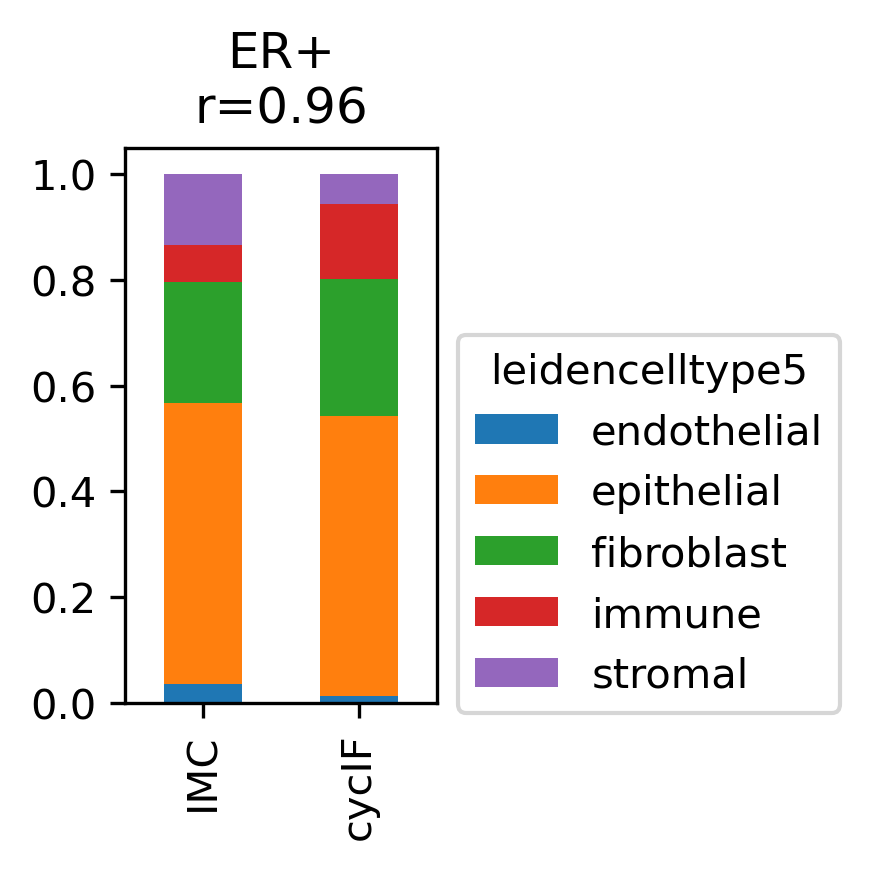

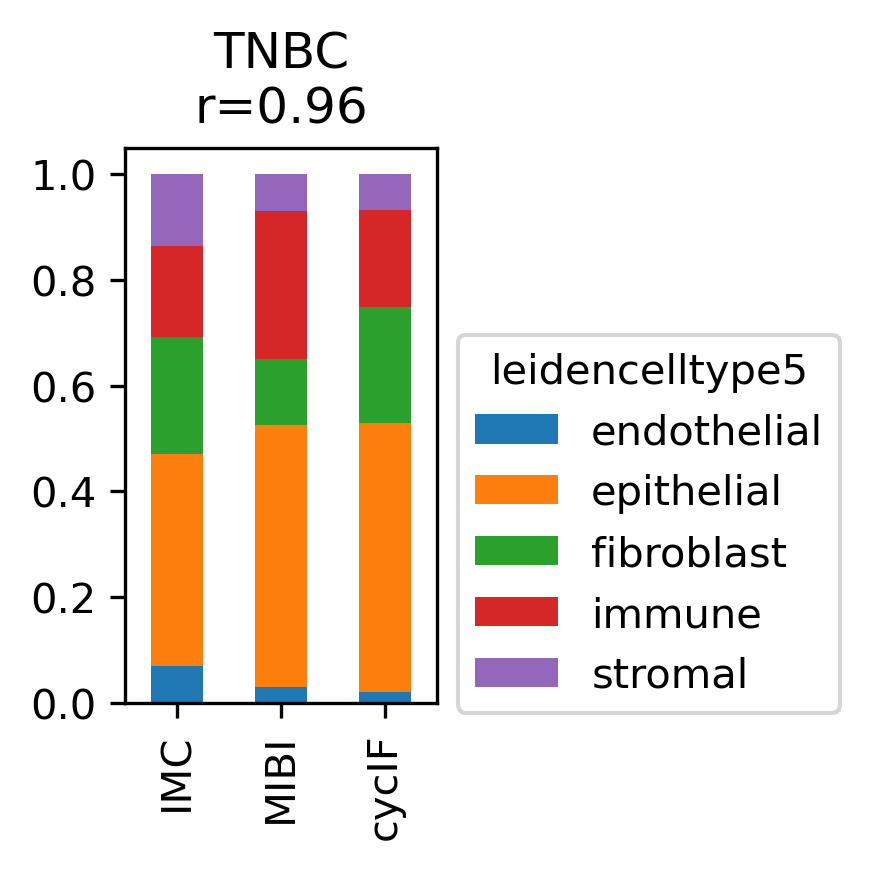

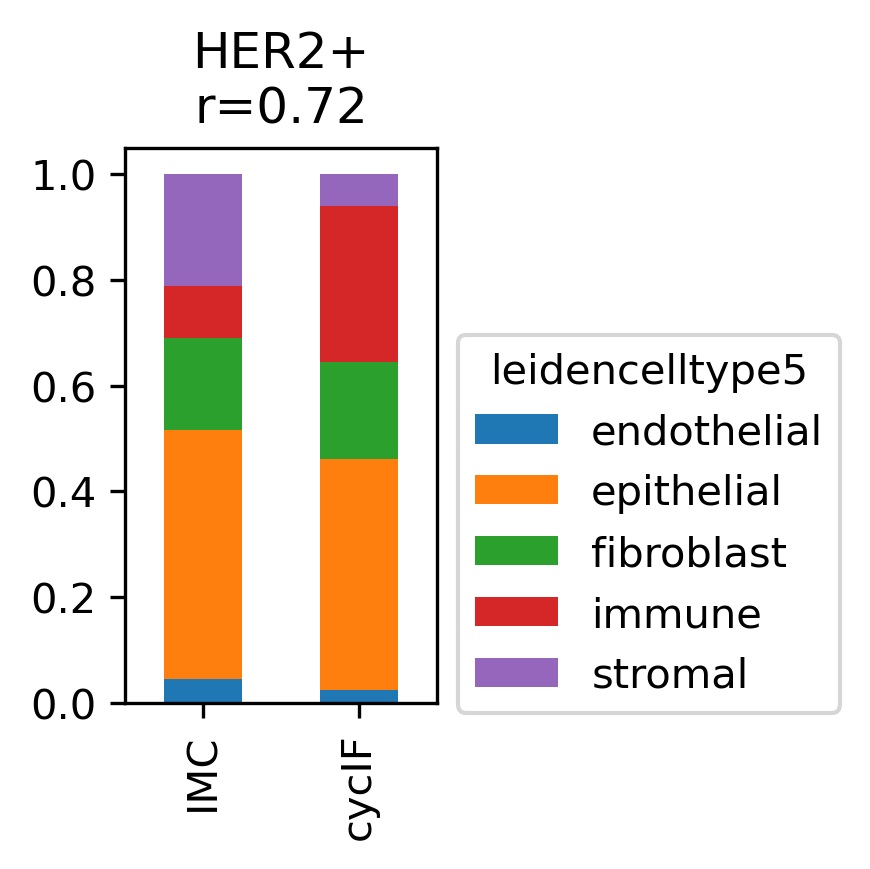

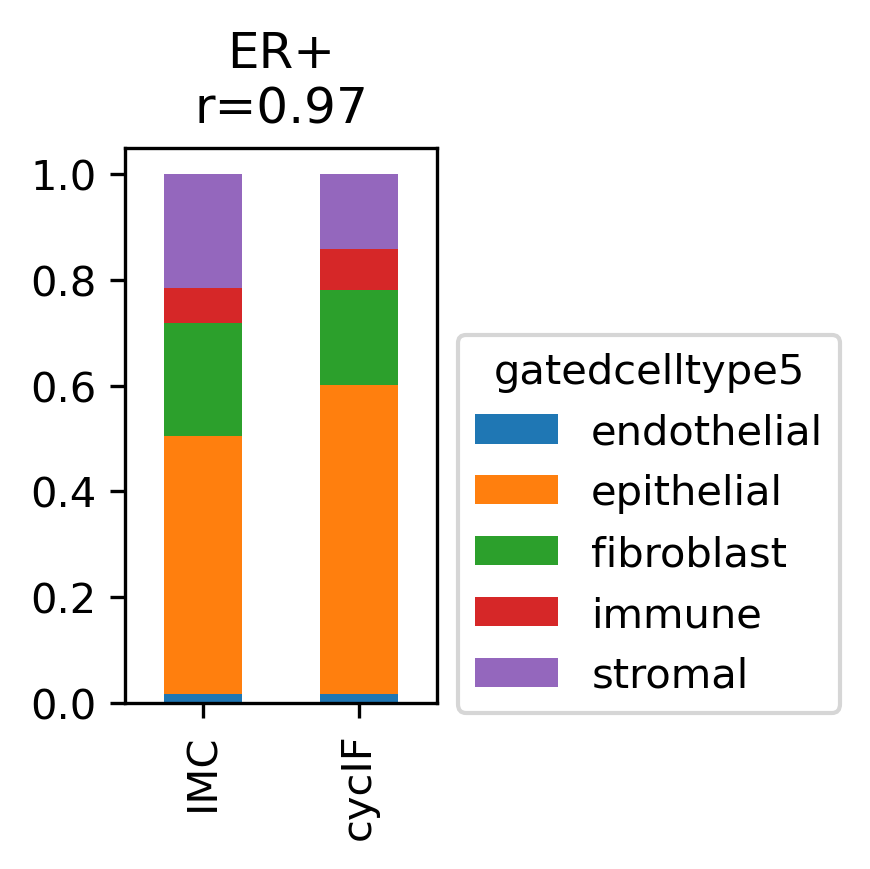

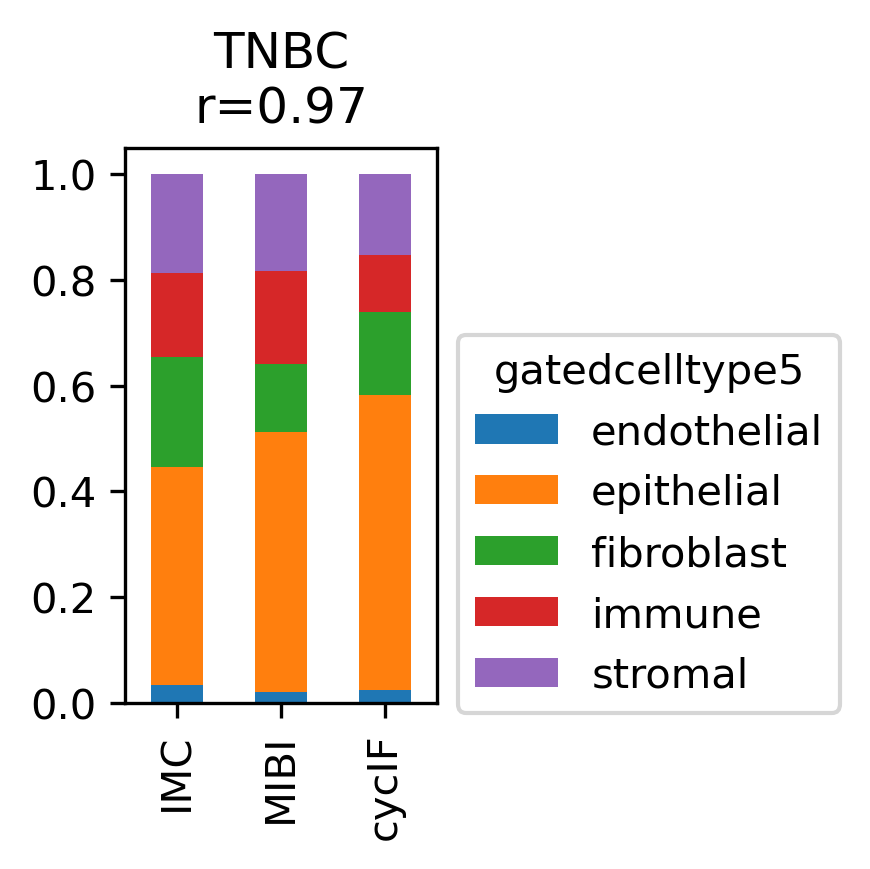

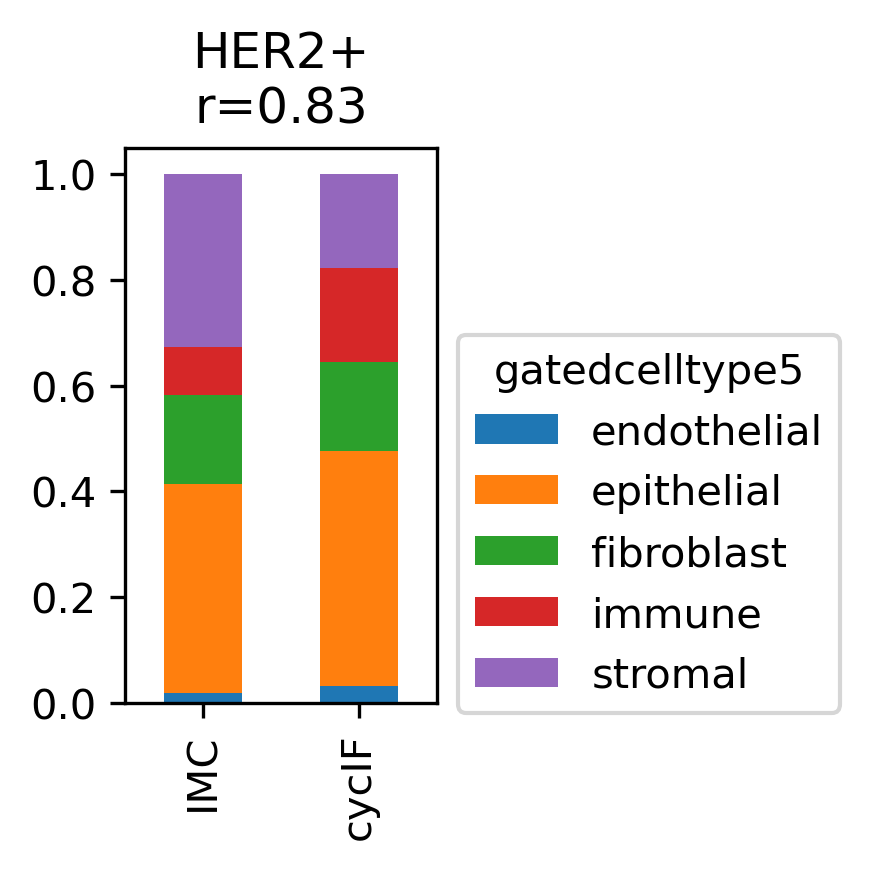

In [4]:
print(df_lei.Platform.unique())
print(df_lei.subtype.unique())
for s_cell in ['leidencelltype5','gatedcelltype5']:
    for s_subtype in ['ER+', 'TNBC', 'HER2+']:
        df_both = pd.DataFrame(index = ['endothelial', 'epithelial', 'fibroblast', 'immune', 'stromal'])
        for s_plat in sorted(df_lei[df_lei.subtype==s_subtype].Platform.unique()):
            df_mib = df_lei[(df_lei.subtype==s_subtype)&(df_lei.Platform==s_plat)]
            df_st = df_mib.groupby(s_cell).CD31.count()/len(df_mib)
            df = pd.DataFrame(df_st).rename({'CD31':s_plat},axis=1)
            df_both = pd.concat([df_both,df],axis=1)
        #corr
        se_corr = df_both.corr(method='pearson').unstack().loc['cycIF']
        i_corr = se_corr[se_corr != 1].mean()
        fig,ax = plt.subplots(figsize=(3,3),dpi=300)
        pd.DataFrame(df_both).T.plot(kind='bar',stacked=True,title=s_subtype,ax=ax)
        ax.legend(bbox_to_anchor=(1,.7),title=s_cell)
        ax.set_title(f'{s_subtype}\nr={i_corr:.2}')
        plt.tight_layout()
        fig.savefig(f'{codedir}/{s_date}/Cell_Fractions_{s_subtype}_{s_cell}.png')
        #break

IMC
           IMC
subtype       
ER+        170
ER+ HER2+   31
HER2+       22
TNBC        50
cycIF
               cycIF
subtype             
ER+               30
HER2+              9
Normal Breast      1
TNBC              59
MIBI
         MIBI
subtype      
TNBC       41


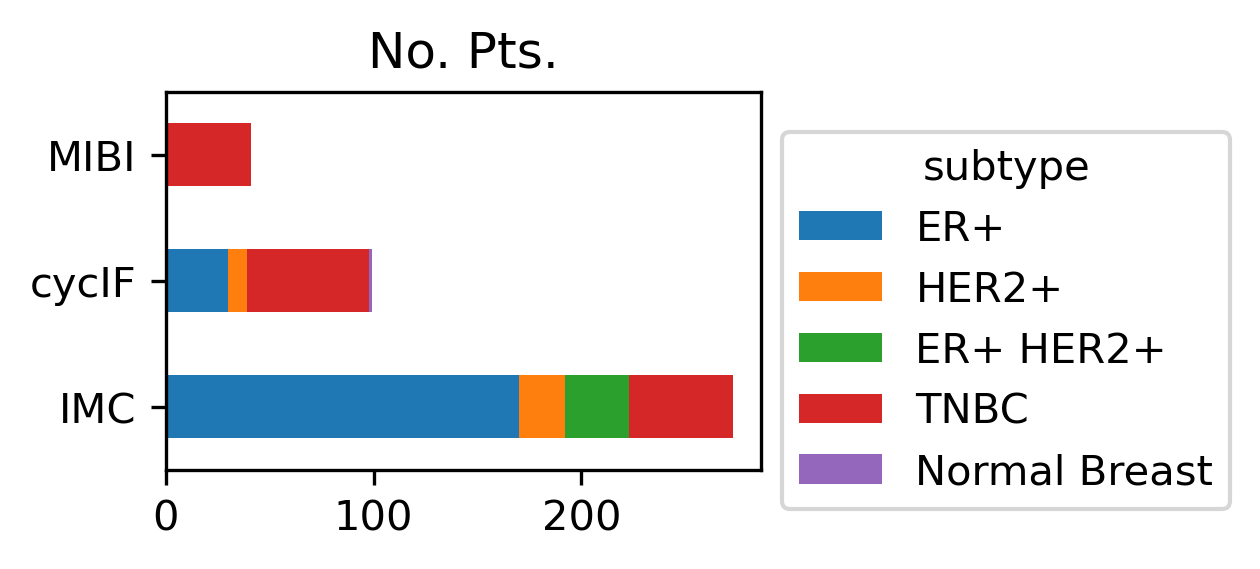

In [6]:

df_both = pd.DataFrame(index = ['ER+',  'HER2+','ER+ HER2+','TNBC',])
for s_plat in ['IMC', 'cycIF', 'MIBI']:
    df_mib = df_lei[(df_lei.Platform==s_plat)]
    df_mib.index = df_mib.Patient
    df_st = df_mib[~df_mib.index.duplicated()].groupby('subtype').CD31.count()
    df = pd.DataFrame(df_st).rename({'CD31':s_plat},axis=1)
    print(s_plat)
    print(df)
    df_both = pd.concat([df_both,df],axis=1)
fig,ax = plt.subplots(figsize=(4.3,2),dpi=300)
pd.DataFrame(df_both).T.plot(kind='barh',stacked=True,title='No. Pts.',ax=ax)
ax.legend(bbox_to_anchor=(1,.95),title='subtype')
plt.tight_layout()
#fig.savefig(f'{codedir}/{s_date}/Subtype_Fractions_{s_subtype}.png')

In [7]:
df_both

,IMC,cycIF,MIBI
ER+,170.0,30.0,NaN
HER2+,22.0,9.0,NaN
ER+ HER2+,31.0,NaN,NaN
TNBC,50.0,59.0,41.0
Normal Breast,NaN,1.0,NaN


In [ ]:
df_both.sum(axis=1)

In [ ]:
len(df_surv) 
df_surv.isna().sum()

In [ ]:
#gated celltypes (fraction)

#s_sample = s_sample.replace('_s','')# = '20220114_BaselTMA'
s_grouper='Patient'
ls_cell = ['leidencelltype5','gatedcelltype5']#,'celltype' 'leidencelltype3','leidencelltype4',
for s_cell in ls_cell:
    df_prop = viz.prop_positive(df_lei,s_cell=s_cell,s_grouper=s_grouper)
    s_out = f'results_{s_sample}_GatedCellTypes_by{s_grouper}_by{s_cell}_{s_type}.csv'
    print(s_out)
    df_prop.to_csv(f'{codedir}/{s_out}')
    #break
print(len(df_lei))

## leiden celltypes

In [ ]:
#corrections (drop ERneg)
ls_TNBC = ['103', '114', '116', '129', '163', '272', '00-8939-2D', '90-526-2M', 'JP-TMA2-1_scene21', 'JP-TMA2-1_scene26',
 'JP-TMA2-1_scene31', 'Z28']
ls_ERneg = ['3', '4', '18', '24', '29', '32', '35', '38', '44', '48', '50', '56', '62', '65', '76', '79', '80', '83', '86',
 '92', '100', '101', '102', '108', '109', '118', '119', '120', '122', '126', '128', '130', '131', '138', '141', '146', '148',
 '153', '158', '169', '170', '173', '177', '183', '188', '206', '210', '211', '212', '217', '219', '221', '223', '225', '234',
 '237', '239', '242', '245', '247', '248', '250', '256', '260', '263', '264', '268', '271', '273', '279', '281', '282']
print(s_date)
if not s_date == '20220412': #produced results_20220420_JP-TMAs_IMC-TMAs_MIBI
    print('update ER status')
    df_lei.loc[(df_lei.Patient.isin(ls_TNBC)) & (df_lei.leiden=='Luminal ER+ t.'),'leiden'] = 'Luminal t.'
print(len(df_lei))
## dont drop, already filtered df_lei = df_lei.loc[~(df_lei.Patient.isin(ls_ERneg))]
print(len(df_lei))

#leiden

for s_celltype in ['leidencelltype2','celltype1']: #'celltype3','celltype',
    for s_cell in df_lei.loc[:,s_celltype].unique():
        df_cell = df_lei.loc[df_lei.loc[:,s_celltype]==s_cell]
        df_prop = viz.prop_positive(df_cell,s_cell='leiden',s_grouper='Patient')
        s_out = f'results_{s_sample}_LeidenClustering_byPatient_by{s_celltype}_in{s_cell}_{s_type}.csv'
        for s_plat in df_lei.Platform.unique():
            ls_patient = df_lei[df_lei.Platform==s_plat].Patient.unique()
            df_prop.loc[ls_patient,~df_prop.loc[ls_patient].isna().all()] = df_prop.loc[ls_patient,~df_prop.loc[ls_patient].isna().all()].fillna(0)
        df_prop.to_csv(s_out)
        print(s_out)

## survival analysis <a name="surv"></a>


- single variable


[contents](#contents)


In [ ]:
#example file names 
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'#'20220413_JP-TMAs_IMC-TMAs_MIBI'#'20220411_JP-TMAs_IMC-TMAs_MIBI' # '20220409_JP-TMAs_IMC-TMAs'
#results_20220207_JP-TMAs_IMC-TMAs_LeidenClustering_byPatient_bycelltype1_inall_2sub.csv
#results_20220207_JP-TMAs_IMC-TMAs_GatedCellTypes_byPatient_bycelltype_2sub.csv


df_file = pd.DataFrame()
for s_file in os.listdir():
    if s_file.find(f'results_{s_sample}_GatedCellTypes') > -1:
        s_type = 'GatedCellTypes'
        s_subtype = s_file.split('.csv')[0].split('_')[-1]
        s_partition = 'gating'
        s_cell = s_file.split('.csv')[0].split('_')[-2].split('by')[1]
    elif s_file.find(f'results_{s_sample}_LeidenClustering_') > -1:
        s_type = 'LeidenClustering'
        s_subtype = s_file.split('.csv')[0].split('_')[-1]
        s_partition = s_file.split('.csv')[0].split('_')[-3].split('by')[1]
        s_cell = s_file.split('.csv')[0].split('_')[-2].split('in')[1]   
    elif s_file.find(f'results_{s_sample}_BGSubtractedMeanIntensity') > -1:
        s_type = 'MeanIntensity'
        s_subtype = s_file.split('.csv')[0].split('_')[-1]
        s_partition = s_file.split('.csv')[0].split('_')[-3].split('by')[1]
        s_cell = s_file.split('.csv')[0].split('_')[-2].split('in')[1]   
    elif s_file.find(f'results_{s_sample}_Density_') > -1:
        s_type = 'Density'
        s_subtype = s_file.split('.csv')[0].split('_')[-1]
        s_partition = s_file.split('.csv')[0].split('_')[-2].split('by')[1]
        s_cell = 'density'
    else:
        continue
    df_file.loc[s_file,'subtype'] = s_subtype
    df_file.loc[s_file,'type'] = s_type
    df_file.loc[s_file,'partition'] = s_partition
    df_file.loc[s_file,'cell'] = s_cell
    #break
df_file.to_csv(f'{s_sample}_results_files.csv')

In [ ]:
%matplotlib inline
ls_drop = []
df_surv.index = df_surv.index.astype('str')
ls_file = [#'results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_byleidencelltype2_inepithelial_all.csv',
       'results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_bycelltype1_inall_all.csv',
       #'results_20220420_JP-TMAs_IMC-TMAs_MIBI_GatedCellTypes_byPatient_byleidencelltype5_all.csv',
       'results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_byleidencelltype2_instromal_all.csv',
          ]

### find cutpoints 

In [ ]:
alpha = 0.05
df_surv.index = df_surv.index.astype('str')
savedir = f'{codedir}/{s_date}'

for s_time, s_censor in [('Survival_time','Survival'),('Recurrence_time','Recurrence')]:
    for s_index in ls_file: 
        s_type = df_file.loc[s_index,'type']
        s_cell = df_file.loc[s_index,'cell']
        df_all=pd.read_csv(s_index,index_col=0)
        df_all.index = df_all.index.astype('str')
        ls_marker = df_all.columns
        df_all = df_all.merge(df_surv,left_index=True,right_index=True)
        if df_all.columns.str.contains('CD4 T cell').any():
            df_all.loc[df_all.Platform!='IMC','CD3 T cell'] = df_all.loc[df_all.Platform!='IMC',['CD4 T cell','CD8 T cell']].sum(axis=1)
        for s_subtype in ['ER+','TNBC','HER2+']:
            for s_plat in ['cycIF']:
                for s_col in ls_marker:
                    s_col = 'Vim+ FB'
                    for cutp in [.5,.66,0.33]:
                        single_km(df_all,s_cell,s_subtype,s_plat,s_col,savedir,alpha,cutp,s_time,s_censor)
                        #break
                    break
                break
            break
        break

### apply cutpoints

In [ ]:
#why skipping everything
s_index = 'results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_bycelltype1_inall_all.csv'
#s_index = 'results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_byleidencelltype2_instromal_all.csv'
df_all=pd.read_csv(s_index,index_col=0)
df_all.index = df_all.index.astype('str')
#df_all = df_all.merge(df_surv.loc[:,['Platform','subtype']],left_index=True,right_index=True)

d_cut = {#'endothelial':0.33,'CD20 B cell':0.33,'CD8 T cell':0.33,'CD4 T cell':0.5,'CD3 T cell':0.5,
        #'CD44+ str.':0.33,'Macrophage':0.5,'FN+ FB':0.5,'ColI+ FB':0.33,'Quies. str.':0.66,'FB':0.5,
         #'Prolif. t.':0.5,'CK lo. t.':0.66,'Basal t.':0.66,'Luminal ER+ t.':0.66,'HER2+ Ki67+ t.':0.33, 'CD44+ t.':0.5,
         'Vim+ FB':0.5,
         #'Prolif t.',0.33,'Basal t.':0.33, #HER2
        }
alpha = 1
for s_col, cutp in d_cut.items():
    for s_time, s_censor in [('Survival_time','Survival'),('Recurrence_time','Recurrence')]:
        df_censor = df_all.merge(df_surv.loc[:,['Platform','subtype',s_time, s_censor]],left_index=True,right_index=True)
        for s_subtype in ['TNBC','ER+']: #,'HER2+'
            for s_plat in ['IMC','MIBI','cycIF']: #
                try:
                    df = single_km(df_censor,s_cell,s_subtype,s_plat,s_col,savedir,alpha,cutp,s_time,s_censor)
                except:
                    print(f'skipped {s_col}')
                #break
            break

# combine platforms

In [ ]:
# platforms together, all and by subtype
print(s_date)
df_e = pd.read_csv(f'{codedir}/20220412/results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',index_col=0)
df_e.index = df_e.index.astype('str')
print(len(df_e))
df_prolif = pd.read_csv(f'{codedir}/20220826/Prolif._t._high_low.csv',index_col=0)
df_prolif.index = df_prolif.index.astype('str')
df_prolif.rename({'Prolif. t. abundance':'abundance'},axis=1,inplace=True)
d_prolif = dict(zip(df_prolif.index,df_prolif.abundance))
print(len(df_prolif))
#read dataframe with more cell types
s_index ='results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_bycelltype1_inall_all.csv'
#s_index = 'results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_byleidencelltype2_instromal_all.csv'
df_all=pd.read_csv(s_index,index_col=0)
print(len(df_all))
df_all.index = df_all.index.astype('str')
df = df_all.merge(df_surv,left_index=True,right_index=True,how='left').merge(df_e.loc[:,['leiden']],left_index=True,right_index=True,how='left')
df.loc[df.Platform!='IMC','CD3 T cell'] = df.loc[df.Platform!='IMC',['CD4 T cell','CD8 T cell']].sum(axis=1)
df['prolif'] = df.index.map(d_prolif)
df.index = df.index.astype('str')
print(len(df))

In [ ]:
# combine platforms for survival analysis by all, and by low/high proliferation

savedir = f"{codedir}/{s_date}"
d_cut = {#'Prolif. t.':0.5,
    #'CD3 T cell':0.5,'CD20 B cell':0.33,
    #'endothelial':0.33,#'CD8 T cell':0.33,'CD4 T cell':0.5,
        #'CD44+ str.':0.33,'Macrophage':0.5,
         'Vim+ FB':0.66,#'Vim+ FB':0.5,#'FN+ FB':0.5,'Quies. str.':0.66,#'ColI+ FB':0.33,'FB':0.5,
         #'CK lo. t.':0.66,'Basal t.':0.66,'Luminal ER+ t.':0.66, 'CD44+ t.':0.5, #'HER2+ Ki67+ t.':0.33,
         #'Prolif t.',0.33,'Basal t.':0.33, #HER2
        }
alpha = 0.9
df_prolif = pd.DataFrame()
s_low_high = 'low'
for s_col, cutp in d_cut.items():
    for s_time, s_censor in [('Survival_time','Survival'),('Recurrence_time','Recurrence')]:
        for s_subtype in ['TNBC','ER+']:
            for s_cell in ['all','prolif',]: #,2,5,0, 1,  3, 4,  6, 7
                df_both=pd.DataFrame()
                for s_plat in ['IMC','MIBI','cycIF']:
                    #print(s_plat)
                    if s_cell == 'all':
                        df_all = df.drop('prolif',axis=1).copy()
                        df_all.index = df_all.index.astype('str')
                    elif s_cell == 'prolif':
                        df_all = df.loc[df.prolif==s_low_high,:].copy()
                    else:
                        df_all = df.loc[df.leiden==s_cell,:].copy()
                    #break
                    df_p = single_km(df_all,s_cell,s_subtype,s_plat,s_col,savedir,alpha=0.001,cutp=cutp,s_time=s_time,s_censor=s_censor) 
                    df_both = df_both.append(df_p)
                #
                df_both_surv = df_both.dropna()
                s_title2 = f'{s_col} n={len(df_both_surv)}'
                s_title1 = f'{s_subtype} {s_censor}'
                if s_cell == 'prolif':
                    s_title1 = f'{s_subtype} {s_low_high}-{s_cell}' # {s_censor}
                #log rank
                if len(df_both_surv) > 0:
                    results = multivariate_logrank_test(event_durations=df_both_surv.loc[:,s_time],
                                                    groups=df_both_surv.abundance, event_observed=df_both_surv.loc[:,s_censor])
                #kaplan meier plotting
                if results.summary.p[0] < alpha:
                    kmf = KaplanMeierFitter()
                    fig, ax = plt.subplots(figsize=(3,3),dpi=300)
                    for s_group in ['high','low']:
                        df_abun = df_both_surv[df_both_surv.abundance==s_group]
                        durations = df_abun.loc[:,s_time]
                        event_observed = df_abun.loc[:,s_censor]
                        try:
                            kmf.fit(durations, event_observed,label=s_group)
                            kmf.plot(ax=ax,ci_show=False,show_censors=True)
                        except:
                            results.summary.p[0] = 1
                    ax.set_ylim(-0.1,1.1)
                    ax.set_title(f'{s_title1}\n{s_title2}\np={results.summary.p[0]:.2}',fontsize=10)
                    ax.legend(loc='upper right',title=f'{cutp}')
                    if s_cell == 'prolif':
                        ax.legend(loc='upper right',title=f'{s_col}')
                    ax.set_xlabel(s_time)
                    plt.tight_layout()
                    fig.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
                break
            #break
            df_prolif = df_prolif.append(df_both)
        #break


In [ ]:
#output high low
df_prolif = pd.DataFrame()
s_low_high = 'high'
ls_col = ['Prolif. t.',
    'CD3 T cell']
df_all_prolif = pd.DataFrame()
for s_col in ls_col:
    df_prolif=pd.DataFrame()
    for s_subtype in ['TNBC','ER+']:
        #print(s_subtype)
        for s_plat in ['IMC','MIBI','cycIF']:
            df_all = df.drop('prolif',axis=1).copy()
            df_p = low_high_abun(df_all,s_subtype,s_plat,s_col)
            #print(len(df_p))
            df_prolif = df_prolif.append(df_p)
    print(len(df_prolif))
    df_prolif.rename({'abundance':f'{s_col} abundance'},axis=1,inplace=True)
    if not os.path.exists(f'{s_date}/{s_col.replace(" ","_")}_high_low.csv'):
        print('saving')
        df_prolif.to_csv(f'{s_date}/{s_col.replace(" ","_")}_high_low.csv')
    #print(df_prolif.groupby(f'{s_col} abundance').mean())
    #print(df_prolif[df_prolif.loc[:,f'{s_col} abundance'].isna()].loc[:,s_col])
    if s_col == 'Prolif. t.':
        #print(s_col)
        df_all_prolif = df_all_prolif.append(df_prolif)
    else:
        df_all_prolif = df_all_prolif.merge(df_prolif.loc[:,[f'{s_col} abundance']],left_index=True,right_index=True)

df_all_prolif['ProlifTum_Tcell'] = df_all_prolif.loc[:,'Prolif. t. abundance'] + '_' + df_all_prolif.loc[:,'CD3 T cell abundance']

In [ ]:
#fuction to plot km curve for categorical variable
def cat_km(df,s_col,s_time,s_censor):
    df_lr = pd.DataFrame()
    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(4,3),dpi=300)
    for s_group in sorted(df.loc[:,s_col].unique()):
        df_abun = df.loc[df.loc[:,s_col]==s_group,[s_col,s_time,s_censor]].dropna()
        #print(len(df_abun))
        durations = df_abun.loc[:,s_time]
        event_observed = df_abun.loc[:,s_censor]
        try:
            kmf.fit(durations, event_observed,label=s_group)
            kmf.plot(ax=ax,ci_show=False,show_censors=True,label=s_group)
        except:
            print('')
        df_lr = df_lr.append(df_abun)
    try:
        results = multivariate_logrank_test(event_durations=df_lr.loc[:,s_time],
                                            groups=df_lr.loc[:,s_col], event_observed=df_lr.loc[:,s_censor])
        pvalue = results.summary.p[0]
    except:
        pvalue = 1.0
    ax.set_title(f'{s_col}\np={pvalue:.2}',fontsize=10)
    ax.set_xlabel(s_censor)
    ax.legend(bbox_to_anchor=(1.01,0.6),title=f'{s_col}')
    plt.tight_layout()
    return(fig)

In [ ]:
#combine platforms
s_col = 'ProlifTum_Tcell'
s_time = 'Survival_time'
s_censor = 'Survival'
for s_subtype in ['TNBC','ER+']:
        df_sub = df_all_prolif[(df_all_prolif.subtype==s_subtype)]
        fig = cat_km(df_sub,s_col,s_time,s_censor)
        fig.suptitle(f'All {s_subtype}',fontsize='medium',x=0.35,y=.91)
        plt.tight_layout()
        fig.savefig(f'{s_date}/KM_{s_col}_allplat_{s_subtype}_{s_censor}.png')
        plt.close(fig)

In [ ]:
s_col = 'ProlifTum_Tcell'
s_time = 'Survival_time'
s_censor = 'Survival'
for s_subtype in ['TNBC','ER+']:
    for s_plat in ['IMC','cycIF','MIBI']:
        df_sub = df_all_prolif[(df_all_prolif.Platform==s_plat) & (df_all_prolif.subtype==s_subtype)]
        fig = cat_km(df_sub,s_col,s_time,s_censor)
        fig.suptitle(f'{s_plat} {s_subtype}',fontsize='medium',x=0.35,y=.91)
        plt.tight_layout()
        fig.savefig(f'{s_date}/KM_{s_col}_{s_plat}_{s_subtype}_{s_censor}.png')
        plt.close(fig)

In [ ]:
#s_col = 'ProlifTum_Tcell'
#df_all_prolif.to_csv(f'{s_date}/{s_col.replace(" ","_")}_high_low.csv')
#df_all_prolif[(df_all_prolif.ProlifTum_Tcell=='high_high') & (df_all_prolif.Platform=='cycIF')].sort_values(by='CD44+ str.')


## multivariable model  <a name="clin"></a> 

don't run CPH linear

[contents](#contents)

In [ ]:
#CPH low/high
df_clin_cell = df.merge(df_clin,left_index=True,right_index=True)


alpha = 0.05
ls_clin = ['age', 'tumor_size','Stage']
savedir = f"{codedir}/{s_date}"
d_cut = {'CD20 B cell':0.33,'CD3 T cell':0.5,
       #'endothelial':0.33,'CD8 T cell':0.33,'CD4 T cell':0.5,
        #'CD44+ str.':0.33,'Macrophage':0.5,'Vim+ FB':0.5,'FN+ FB':0.5,'ColI+ FB':0.33,'Quies. str.':0.66,'FB':0.5,
        # 'Prolif. t.':0.5,'CK lo. t.':0.66,'Basal t.':0.66,'Luminal ER+ t.':0.66,'HER2+ Ki67+ t.':0.33, 'CD44+ t.':0.5,
         #'Prolif t.',0.33,'Basal t.':0.33, #HER2
        }
for s_low_high in ['high','low']:
    for s_time, s_censor in [('Survival_time','Survival'),('Recurrence_time','Recurrence')]:
        for s_col, cutp in d_cut.items():
            for s_subtype in ['TNBC','ER+']: #'HER2+',
                for s_cell in ['all', 'prolif']:
                    df_both=pd.DataFrame()
                    for s_plat in ['MIBI','IMC','cycIF']:
                        if s_cell == 'all':
                            df_all = df.drop('prolif',axis=1).copy()
                            #df_all.index = df_all.index.astype('str')
                        elif s_cell == 'prolif':
                            df_all = df.loc[df.prolif==s_low_high,:].copy()
                        else:
                            df_all = df.loc[df.leiden==s_cell,:].copy()
                        df_p = single_km(df_all,s_cell,s_subtype,s_plat,s_col,savedir,alpha=0.001,cutp=cutp,s_time=s_time,s_censor=s_censor) 
                        df_both = df_both.append(df_p)
                    if s_cell == 'prolif':
                        s_cell = f'{s_low_high}-{s_cell}'
                    s_title1 = f'{s_col} in {s_cell}'
                    s_title2 = f'{s_censor} {s_subtype} n={len(df_both)}'
                    df_both = df_both.dropna()
                    if len(df_both) > 0:
                        #CPH
                        df_dummy = pd.get_dummies(df_both.drop(s_col,axis=1))
                        df_dummy.index = df_dummy.index.astype('str')
                        #multi
                        df_marker = df_dummy.drop('abundance_low',axis=1).merge(df_clin.loc[:,ls_clin],left_index=True,right_index=True).dropna()
                        df_marker = df_marker.rename({'abundance_high':s_col},axis=1)
                        cph = CoxPHFitter()   
                        try:
                            cph.fit(df_marker, s_time, event_col=s_censor) 
                            pvalue = cph.summary.loc[s_col,'p']
                            if pvalue < alpha:
                                fig, ax = plt.subplots(figsize=(2.8,2.2),dpi=200)
                                cph.plot(ax=ax)
                                ax.set_title(f'{s_col} in {s_cell}\n{s_subtype} {s_censor}\np={pvalue:.2} n={len(df_marker)}')
                                plt.tight_layout()
                                fig.savefig(f"{codedir}/{s_date}/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
                        except:
                            continue
                    #break
                #break



In [ ]:
#kmeans LDA survival
alpha = 0.0001
df_surv.index = df_surv.index.astype('str')
savedir = f'{datadir}/{s_date}'
for s_subtype in ['TNBC','ER+',]: 
    for s_time, s_censor in [('Survival_time','Survival'),('Recurrence_time','Recurrence')]:
        for s_col in ['T cell','mixed FB','quies str & FB','Vim+ FB']:
            for cutp in [.5,0.66,0.33]: 
                df_both = pd.DataFrame()
                for s_plat in ['cycIF','IMC']: 
                    s_type = 'SpatialLDA'
                    s_cell = 'Kmeans'
                    k=8
                    #if s_plat == 'cycIF': #manually changed K7 to K8 to simplify loading
                    #    #if s_subtype == 'ER+':
                    #        k=7
                    df_all=pd.read_csv(f'{codedir}/results_{s_subtype}_{s_plat}_SpatialLDA_byPatient_byKmeans_k{k}.csv',index_col=0)
                    df_all.index = df_all.index.astype('str')
                    df_all = df_all.merge(df_surv,left_index=True,right_index=True)  
                    if df_all.columns.isin([s_col]).any():
                        df_km_out = single_km(df_all,s_cell,s_subtype,s_plat,s_col,savedir,alpha,cutp,s_time,s_censor)
                        #print(len(df_km_out))
                        df_both = pd.concat([df_both, df_km_out])
                #print(len(df_both))
                # both KM
                df_both_surv = df_both.dropna()
                s_title1 = f'{s_col} in {s_cell}'
                s_title2 = f'{s_censor} {s_subtype} n={len(df_both)}'
                if len(df_both) > 0:
                    #CPH
                    df_dummy = pd.get_dummies(df_both.drop(s_col,axis=1))
                    df_dummy.index = df_dummy.index.astype('str')
                    #multi
                    df_marker = df_dummy.drop('abundance_low',axis=1).merge(df_clin.loc[:,ls_clin],left_index=True,right_index=True).dropna()
                    df_marker = df_marker.rename({'abundance_high':s_col},axis=1)
                    cph = CoxPHFitter()   
                    try:
                        cph.fit(df_marker, s_time, event_col=s_censor) 
                        pvalue = cph.summary.loc[s_col,'p']
                        if pvalue < 0.05:
                            fig, ax = plt.subplots(figsize=(3.5,2.2),dpi=200)
                            cph.plot(ax=ax)
                            ax.set_title(f'{s_col}-Tumor Neighborhoods\n{s_subtype} {s_censor}\n p={pvalue:.2} n={len(df_marker)}')
                            plt.tight_layout()
                            fig.savefig(f"{codedir}/{s_date}/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
               
                    except:
                        continue
        #break
    #break

## Subtyping analysis <a name="subtIMC"></a>

- IMC and cyclic

- Basel (ERneg removed), Zurich and cyclic

- common celltypes


[contents](#contents)

In [ ]:
#results data
s_cell ='epithelial'
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
#savedir=f'{codedir}/20220408/Survival_Plots_Both'
df_file = pd.read_csv(f'{codedir}/{s_sample}_results_files.csv',index_col=0)
df_file[(df_file.cell==s_cell) & (df_file.type!='MeanIntensity')]

## Platforms together <a name="st1"></a>

- celltype5 and  epithelial

- gatedcelltype5 not prognostic

- epithelial is prog!!!


[contents](#contents)



In [ ]:
#adata
savedir = f'{codedir}/{s_date}/Survival_Plots_Both'
n_neighbors =  10 #5, or 6 for more cells
savedir = f'{codedir}/{s_date}/Survival_Plots_Both'
for s_cell in ['all','leidencelltype5','stromal','epithelial']:
    s_cell ='epithelial'#'stromal'# 'gatedcelltype5' #'leidencelltype5'# #
    df_load = df_file[(df_file.cell==s_cell) & (df_file.type!='MeanIntensity')]
    s_index = df_load.index[0]
    print(s_index)
    df = pd.read_csv(f'{codedir}/{s_index}',index_col=0)
    s_subtype = df_file.loc[s_index,'subtype'] 
    s_type = df_file.loc[s_index,'type'] 
    s_partition = df_file.loc[s_index,'partition'] 
    s_cell =df_file.loc[s_index,'cell'] 
    #break
    #subtyping adata
    if s_cell == 'all' and s_type == 'LeidenClustering':
        df.loc[:,'Quies. str.'] = df.loc[:,['Quies. str.','FN+ str.']].sum(axis=1)
        df.drop('FN+ str.',axis=1,inplace=True)
        #vim
        df.loc[:,'Vim+ str.'] = df.loc[:,['Vim+ str.', 'Vim++ str.']].sum(axis=1)
        df.drop('Vim++ str.',axis=1,inplace=True)
        ls_col = df.columns[df.dtypes=='float64'][df.loc[:,df.columns[df.dtypes=='float64']].sum()/len(df) > 0.02]
    elif s_cell == 'epithelial':
        ls_col = df.columns[df.dtypes=='float64'][df.loc[:,df.columns[df.dtypes=='float64']].sum()/len(df) > 0.02]
        ls_col = df.columns[df.dtypes=='float64'][df.loc[:,df.columns[df.dtypes=='float64']].sum()/len(df) > 0.04]
        if n_neighbors==6:
            ls_col = df.columns[df.dtypes=='float64'][df.loc[:,df.columns[df.dtypes=='float64']].sum()/len(df) > 0.01]    
    else:
        #ls_col = df.columns[df.dtypes=='float64']
        ls_col = df.columns[df.dtypes=='float64'][df.loc[:,df.columns[df.dtypes=='float64']].sum()/len(df) > 0.02]
        if n_neighbors==6:
            ls_col = df.columns[df.dtypes=='float64'][df.loc[:,df.columns[df.dtypes=='float64']].sum()/len(df) > 0.01]
    adata = make_adata(df, ls_col,df_surv, n_neighbors, s_subtype, s_type, s_partition, s_cell)

    break
resolution = 0.2
adata = cluster_leiden(adata, resolution,n_neighbors, s_subtype, s_type, s_partition, s_cell)
for s_subtype in ['TNBC','ER+','HER2+']: #'ER+',
    s_plat = 'Both'
    df_p, cph = km_cph(adata,df_surv,s_subtype,s_plat,s_type,s_partition,s_cell,savedir=savedir)
    #break

### leiden

In [ ]:
'''
resolution = 0.1
adata = cluster_leiden(adata, resolution,n_neighbors, s_subtype, s_type, s_partition, s_cell)
for s_subtype in ['TNBC','ER+','HER2+']: #'ER+',
    s_plat = 'Both'
    df_p, cph = km_cph(adata,df_surv,s_subtype,s_plat,s_type,s_partition,s_cell,savedir=savedir)
    break#'''

In [ ]:
'''#more plots
#df_p['leiden'] = (cluster.labels_).astype('str')
df_p['leiden'] = adata.obs.leiden
more_plots(adata,df_p,s_subtype,s_type,s_partition,s_cell,n_neighbors,resolution,z_score=0,linkage='ward',
          s_color_p='Subtype',d_color_p = {'ER+':'gold','TNBC':'darkblue','HER2+':'darkred','ER+HER2+':'darkgreen'},
           savedir=savedir)'''

### hierarchcal

In [ ]:
#'''#run after cell below
from sklearn.cluster import AgglomerativeClustering
print(n_neighbors)
if n_neighbors==6:
        resolution = 9
if s_cell == 'epithelial':
    resolution = 8
    linkage='complete'
    if n_neighbors==6:
        resolution = 9
print(resolution)
print(linkage)
cluster = AgglomerativeClustering(n_clusters=resolution, affinity='euclidean', linkage=linkage)   #average
cluster.fit_predict(df_p.loc[:,ls_col])
adata.obs['leiden'] = (cluster.labels_).astype('str')#'''

In [ ]:
#'''
for s_subtype in ['ER+','TNBC','HER2+']: #'ER+',
    s_plat = 'Both'
    df_p, cph = km_cph(adata,df_surv,s_subtype,s_plat,s_type,s_partition,s_cell,savedir=savedir)
    df_p.to_csv(f'{s_date}/results_subtyping_{s_cell}_{s_type}_{s_plat}_h_{resolution}.csv')
    print(f'{s_date}/results_subtyping_{s_cell}_{s_type}_{s_plat}_h_{resolution}.csv')
    #break#'''

In [ ]:
#print(f'{s_date}/results_subtyping_{s_cell}_{s_type}_{s_plat}_h_{resolution}.csv')

In [ ]:
#2 is luminal ER+, should not be in TNBC samples
'''
for s_subtype in ['TNBC']: #'ER+',
    s_plat = 'Both'
    df_p = km_cph(adata[adata.obs.leiden!='2'],df_surv,s_subtype,s_plat,s_type,s_partition,s_cell,savedir=savedir)
    #df_p.to_csv(f'{s_date}/results_subtyping_{s_cell}_{s_type}_{s_plat}_h_{resolution}.csv')'''

In [ ]:
s_cell

In [ ]:
#more plots

df_p['leiden'] = (cluster.labels_).astype('str')
df_p['leiden'] = adata.obs.leiden
more_plots(adata,df_p,s_subtype,s_type,s_partition,s_cell,n_neighbors,resolution,z_score=0,linkage=linkage,
          s_color_p='Subtype',d_color_p = {'ER+':'gold','TNBC':'darkblue','HER2+':'darkred','ER+HER2+':'darkgreen'},
           savedir=savedir)

In [ ]:
adata[(adata.obs.subtype=='ER+') & (adata.obs.leiden=='6')].obs

In [ ]:
#df_cyc_a[df_cyc_a.index=='01-24001-1O']
df_cyc_sub[df_cyc_sub.Accession=='01-24001-1O']

In [ ]:
df_imc_a[df_imc_a.PID==234]

In [ ]:
more_plots(adata,df_p,s_subtype,s_type,s_partition,s_cell,n_neighbors,resolution,z_score=0,linkage='complete',
    s_color_p='Platform',d_color_p = {'cycIF':'c','IMC':'m','MIBI':'yellow'},savedir=savedir)

In [ ]:
for s_subtype in ['ER+','TNBC','HER2+']: #'ER+',
    for s_plat in ['cycIF','IMC','MIBI']:
        df_p, cph = km_cph(adata,df_surv,s_subtype,s_plat,s_type,s_partition,s_cell,savedir=savedir)

In [ ]:
for s_subtype in ['TNBC','ER+','HER2+']: #'ER+', #epithelial entropy not prognostic
    for s_plat in ['cycIF','IMC','MIBI']:
        km_cph_entropy(df_p,df,ls_col,s_subtype,s_plat,s_cell,savedir=savedir)

## cluster the platforms separate <a name="st2"></a>

to get stromal subtypes. not as significant


[contents](#contents)



In [ ]:
#results data
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
savedir=f'{codedir}/{s_date}'
df_file = pd.read_csv(f'{codedir}/{s_sample}_results_files.csv',index_col=0)
#df_file[(df_file.cell==s_cell) & (df_file.type!='MeanIntensity')]

In [ ]:
#adata
n_neighbors = 3 #4 norm, 6 more
s_plat = 'IMC'# 'MIBI'#'cycIF'# 'MIBI'#
for s_cell in ['all','leidencelltype5','stromal','epithelial']:
    s_cell = 'stromal'
    df_load = df_file[(df_file.cell==s_cell) & (df_file.type!='MeanIntensity')]
    s_index = df_load.index[0]
    df = pd.read_csv(f'{codedir}/{s_index}',index_col=0)
    df.index = df.index.astype('str')
    s_subtype = df_file.loc[s_index,'subtype'] 
    s_type = df_file.loc[s_index,'type'] 
    s_partition = df_file.loc[s_index,'partition'] 
    s_cell =df_file.loc[s_index,'cell'] 
    df['Platform'] = df.index.map(df_surv.Platform)
    #subtyping adata
    df_plat = df[df.Platform==s_plat]
    ls_col = df.columns[df_plat.dtypes=='float64'][df_plat.loc[:,df_plat.columns[df_plat.dtypes=='float64']].sum()/len(df_plat) > 0.02]
    if n_neighbors == 6:
          ls_col = df.columns[df_plat.dtypes=='float64'][df_plat.loc[:,df_plat.columns[df_plat.dtypes=='float64']].sum()/len(df_plat) > 0.01] #0.01
    elif n_neighbors == 3:
          ls_col = df.columns[df_plat.dtypes=='float64'][df_plat.loc[:,df_plat.columns[df_plat.dtypes=='float64']].sum()/len(df_plat) > 0.001] #0.01
  
    adata = make_adata(df_plat, ls_col,df_surv, n_neighbors, s_subtype, s_type, s_partition, s_cell)
    break
if s_plat == 'cycIF':
    resolution = 0.4
elif s_plat == 'MIBI':
    resolution = 0.5
else:
    resolution = 0.3
adata = cluster_leiden(adata, resolution,n_neighbors, s_subtype, s_type, s_partition, s_cell)
adata.obs.index = adata.obs.index.astype('str')
for s_subtype in ['Both']:
    df_p, cph = km_cph(adata,df_surv,s_subtype,s_plat,s_type,s_partition,s_cell,savedir=savedir) #,savedir=f'{codedir}/20220222/Survival_Plots_Both'
    #df_p.to_csv(f'{s_date}/results_subtyping_{s_cell}_{s_type}_{s_plat}_{n_neighbors}_{resolution}.csv')

In [ ]:
#'''
from sklearn.cluster import AgglomerativeClustering
if n_neighbors ==6:
    resolution = 9 
elif n_neighbors ==3:
    resolution = 3 
elif s_plat =='cycIF':
    resolution = 6 
elif s_plat =='MIBI':
    resolution = 6
elif s_plat =='IMC':
    resolution = 6
print(resolution)
cluster = AgglomerativeClustering(n_clusters=resolution, affinity='euclidean', linkage='complete')  
cluster.fit_predict(df_p.loc[:,ls_col])
adata.obs['leiden'] = (cluster.labels_).astype('str')#'''

In [ ]:
adata.obs

In [ ]:

for s_subtype in ['TNBC','ER+','HER2+']:
    df_p, cph = km_cph(adata,df_surv,s_subtype,s_plat,s_type,s_partition,s_cell,savedir=savedir) #,savedir=f'{codedir}/20220222/Survival_Plots_Both'
    df_p.to_csv(f'{s_date}/results_subtyping_{s_cell}_{s_type}_{s_plat}_h_{resolution}.csv')
    #break

In [ ]:
df_p

In [ ]:
#more plots
more_plots(adata,df_p,s_subtype,s_type,s_partition,s_cell,n_neighbors,resolution,z_score=0,linkage='complete',
          s_color_p='Subtype',d_color_p = {'ER+':'gold','TNBC':'darkblue','HER2+':'darkred','ER+HER2+':'darkgreen'},savedir=savedir) #savedir=f'{codedir}/20220222/Survival_Plots_Both'

In [ ]:
for s_subtype in ['TNBC','ER+','HER2+']: #'ER+', #stromal entropy not prognostic
    km_cph_entropy(df_p,df,ls_col,s_subtype,s_plat,s_cell,savedir=savedir)

In [ ]:
savedir

# correlation within tissue <a name="st3"></a>

pearson heatmap

[contents](#contents)


In [ ]:
# correlation 

d_match = { 
    'results_subtyping_stromal_LeidenClustering_IMC_h_3.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
   'results_subtyping_stromal_LeidenClustering_cycIF_h_3.csv':'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
    'results_subtyping_stromal_LeidenClustering_MIBI_h_3.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
 }

In [ ]:
#bioinfokit.visuz.stat.corr_mat(table, corm, cmap, r, dim, show, figtype, axtickfontsize, axtickfontname, theme)
df_all = pd.DataFrame()
for s_str,s_epi  in d_match.items():
    df = pd.read_csv(f'20220412/{s_epi}',index_col=0)
    ls_tum = df.loc[:,((df.dtypes=='float64') & (~df.columns.str.contains('Survival')))].columns
    df2 = pd.read_csv(f'20220826/{s_str}',index_col=0)
    if s_str.find('IMC') < 0:
        print('making CD3')
        se_cd3 = df2.loc[:,['CD4 T cell','CD8 T cell']].sum(axis=1)
        df2.insert(3, 'CD3 T cell', se_cd3)
    ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
    df_plot = df.merge(df2,left_index=True,right_index=True,suffixes=('','c'))
    ls_marker = df_plot.loc[:,((df_plot.dtypes=='float64') & (~df_plot.columns.str.contains('Survival')))].columns
    ls_drop = df_plot.loc[:,ls_marker].loc[:,df_plot.loc[:,ls_marker].mean()==0].columns
    df_all=df_all.append(df_plot.loc[:,ls_marker].drop(ls_drop,axis=1))
    #break
df_all['subtype'] = df_all.index.map(dict(zip(df_surv.index,df_surv.subtype)))

In [ ]:
from scipy.stats import pearsonr
dim = (8,7)
g = sns.clustermap(df_all.corr().fillna(0))
plt.close()
categories_order = df_all.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
df_all_cats = df_all.loc[:,categories_order]
rho = df_all_cats.corr()
pval = df_all_cats.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
fig, ax = plt.subplots(figsize=dim,dpi=300)
sns.heatmap(df_all_cats.corr(), vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax)
ax.set_title(f'Cell Type Correlation', fontdict={'fontsize':16}, pad=12);
fig.savefig(f'{codedir}/{s_date}/heatmap_Celltype.png', dpi=300, bbox_inches='tight')

In [ ]:
for s_sub in ['TNBC','ER+']:
    df_plot = df_all[df_all.subtype==s_sub].drop('subtype',axis=1)
    df_plot = df_plot.loc[:,~df_plot.isna().all()]
    #ax = visuz.stat.corr_mat(df_plot.loc[:,~df_plot.isna().all()],
                             #show=True,
    #                         dim=(8,8),
                             #figtype='png',
    #                         axtickfontsize=9)
    dim = (8,7)
    g = sns.clustermap(df_plot.corr().fillna(0))
    plt.close()
    categories_order = df_plot.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
    df_plot = df_plot.loc[:,categories_order]
    rho = df_plot.corr()
    pval = df_plot.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
    fig, ax = plt.subplots(figsize=dim,dpi=300)
    sns.heatmap(df_plot.corr(), vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax)
    ax.set_title(f'Cell Type Correlation {s_sub}', fontdict={'fontsize':16}, pad=12);
    fig.savefig(f'{codedir}/{s_date}/heatmap_Celltype_{s_sub}.png', dpi=300, bbox_inches='tight')

## Spatial LDA correlation and Survival <a name="lda_corr"></a>

pearson heatmap

[contents](#contents)


In [ ]:
dd_lda = {'TNBC_IMC':{'Topic-0':'Vim+ FB', 'Topic-1':'SMA+ FB', 
                      'Topic-2':'Quiesc. str.', 'Topic-3':'FN+ FB', 
                      'Topic-4':'mixed FB', 'Topic-5':'T cell',
       'Topic-6':'endothelial', 'Topic-7':'B cell'},
          'ER+_IMC':{'Topic-0':'Vim+ FB', 'Topic-1':'SMA+ FB', 
                      'Topic-2':'Quiesc. str.', 'Topic-3':'FN+ FB', 
                      'Topic-4':'mixed FB', 'Topic-5':'T cell',
       'Topic-6':'endothelial', 'Topic-7':'B cell'},
         'TNBC_cycIF':{'Topic-0':'Macrophage', 'Topic-1':'CD44+ str.', 
                       'Topic-2':'Vim+ FB', 'Topic-3':'FB', 'Topic-4':'T cell', 'Topic-5':'endothelial',
       'Topic-6':'B cell', 'Topic-7':'Quiesc. str.'},
         'ER+_cycIF':{'Topic-0':'Vim+ FB', 'Topic-1':'mixed FB', 
                      'Topic-2':'Quiesc. str.', 'Topic-3':'ColI FB', 
                      'Topic-4':'T cell', 'Topic-5':'endothelial',
       'Topic-6':'T cell', 'Topic-7':'T cell'}}



In [ ]:
#survival

# ran CPH in 20220408_JP-IMC-MIBI-TMAs_survival_spatial.ipynb

# In[ ]:


alpha = 0.0005
df_surv.index = df_surv.index.astype('str')
savedir = f'{codedir}/{s_date}/Survival_Plots'
for s_subtype in ['TNBC','ER+',]: 
    for s_time, s_censor in [('Survival_time','Survival'),('Recurrence_time','Recurrence')]:
        for s_col in [#'T cell','mixed FB','quies mix str','Vim+ FB',
                      'endothelial']:
            for cutp in [.5,0.66,0.33]: 
                df_both = pd.DataFrame()
                for s_plat in ['cycIF','IMC']: 
                    s_type = 'SpatialLDA'
                    s_cell = 'Kmeans'
                    k=8
                    if s_plat == 'cycIF':
                        if s_subtype == 'ER+':
                            k=7
                    df_all=pd.read_csv(f'{datadir}/results_{s_subtype}_{s_plat}_SpatialLDA_byPatient_byKmeans_k{k}.csv',index_col=0)
                    df_all.index = df_all.index.astype('str')
                    df_all = df_all.merge(df_surv,left_index=True,right_index=True)  
                    if df_all.columns.isin([s_col]).any():
                        df_km_out = single_km(df_all,s_cell,s_subtype,s_plat,s_col,savedir,alpha,cutp,s_time,s_censor)
                        #print(len(df_km_out))
                        df_both = pd.concat([df_both, df_km_out])
                #print(len(df_both))
                # both KM
                df_both_surv = df_both.dropna()
                s_title2 = f'{s_col} n={len(df_both_surv)}'
                s_title1 = f'{s_subtype} {s_censor}'
                #log rank
                if len(df_both_surv) > 0:
                    results = multivariate_logrank_test(event_durations=df_both_surv.loc[:,s_time],
                                                    groups=df_both_surv.abundance, event_observed=df_both_surv.loc[:,s_censor])
                #kaplan meier plotting
                if results.summary.p[0] < 0.05:
                    kmf = KaplanMeierFitter()
                    fig, ax = plt.subplots(figsize=(3,3),dpi=300)
                    for s_group in ['high','low']:
                        df_abun = df_both_surv[df_both_surv.abundance==s_group]
                        durations = df_abun.loc[:,s_time]
                        event_observed = df_abun.loc[:,s_censor]
                        try:
                            kmf.fit(durations, event_observed,label=s_group)
                            kmf.plot(ax=ax,ci_show=False,show_censors=True)
                        except:
                            results.summary.p[0] = 1
                    ax.set_ylim(-0.1,1.1)
                    ax.set_title(f'{s_title1}\n{s_title2}\np={results.summary.p[0]:.2}',fontsize=10)
                    ax.legend(loc='upper right',title=f'{cutp}')
                    ax.set_xlabel(s_time)
                    plt.tight_layout()
                    fig.savefig(f"{savedir}/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
                # #CPH
                cph = CoxPHFitter(penalizer=0.1)
                try:
                    df_dummy = pd.get_dummies(df_both).loc[:,[s_time,s_censor,'abundance_high']]
                except:
                    continue
                s_marker = s_col
                df_dummy = df_dummy.rename({'abundance_high':s_marker},axis=1)
                df_dummy.index = df_dummy.index.astype('str')
                df_marker = df_dummy.merge(df_clin,left_index=True,right_index=True).loc[:,[s_time,s_censor,s_marker,'age','tumor_size','Stage']]
                df_marker = df_marker.dropna()
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    #try:
                    #multi
                    cph.fit(df_marker, s_time, event_col=s_censor) 
                    pvalue = cph.summary.loc[s_marker,'p']
                    #print(pvalue)
                    if pvalue < 0.15:
                        fig, ax = plt.subplots(figsize=(3,2),dpi=200)
                        cph.plot(ax=ax)
                        ax.set_title(f'{s_col} Neighborhood cutoff={cutp}\n{s_subtype} {s_censor} p={pvalue:.2} n={len(df_marker)}')
                        plt.tight_layout()
                #break
    #break

In [ ]:
#topics!
from scipy.stats import pearsonr

d_match = { 
    'results_subtyping_stromal_LeidenClustering_IMC_h_3.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
   'results_subtyping_stromal_LeidenClustering_cycIF_h_3.csv':'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
    #'results_subtyping_stromal_LeidenClustering_MIBI_h_3.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
 }


for s_str,s_epi  in d_match.items():
    df = pd.read_csv(f'{codedir}/20220412/{s_epi}',index_col=0)
    ls_tum = df.loc[:,((df.dtypes=='float64') & (~df.columns.str.contains('Survival')))].columns
    df2 = pd.read_csv(f'{codedir}/20220826/{s_str}',index_col=0)
    if s_str.find('IMC') < 0:
        print('making CD3')
        se_cd3 = df2.loc[:,['CD4 T cell','CD8 T cell']].sum(axis=1)
        df2.insert(3, 'CD3 T cell', se_cd3)
    ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
    df_plot = df.merge(df2,left_index=True,right_index=True,suffixes=('','c'))
    ls_marker = df_plot.loc[:,((df_plot.dtypes=='float64') & (~df_plot.columns.str.contains('Survival')))].columns
    ls_drop = df_plot.loc[:,ls_marker].loc[:,df_plot.loc[:,ls_marker].mean()==0].columns
    s_plat = s_str.split('_')[-3]
    df_plot = df_plot.loc[:,ls_marker].drop(ls_drop,axis=1)
    for s_sub in ['ER+','TNBC']:
        df3 = pd.read_csv(f'{codedir}/results_{s_sub}{s_plat}_SpatialLDA_byPatient_bymean_k8.csv',index_col=0)
        d_rename = dd_lda[f'{s_sub}_{s_plat}']
        df_plot['subtype'] = df_plot.index.map(dict(zip(df_surv.index,df_surv.subtype)))
        df_plot_sub = df_plot[df_plot.subtype==s_sub].drop('subtype',axis=1)
        df_plot_sub = df_plot_sub.loc[:,~df_plot_sub.isna().all()]
        df3.columns = [f'{item} {d_rename[item]}' for item in df3.columns]
        dim = (8,7)
        df_plot_sub = df_plot_sub.merge(df3,left_index=True,right_index=True)
        if len(df_plot_sub) >1:
            g = sns.clustermap(df_plot_sub.corr().fillna(0))
            plt.close()
            categories_order = df_plot_sub.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
            df_plot_sub = df_plot_sub.loc[:,categories_order]
            rho = df_plot_sub.corr()
            pval = df_plot_sub.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
            p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
            fig, ax = plt.subplots(figsize=dim,dpi=300)
            sns.heatmap(df_plot_sub.corr(), vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax)
            ax.set_title(f'Cell Type Correlation {s_plat} {s_sub}', fontdict={'fontsize':16}, pad=12);
            fig.savefig(f'{codedir}/{s_date}/heatmap_Celltype_{s_plat}_{s_sub}.png', dpi=300, bbox_inches='tight')
    #break

In [ ]:
#neighborhoods!
#platforms separate
for s_str,s_epi  in d_match.items():
    print(s_str)
    df = pd.read_csv(f'{codedir}/20220412/{s_epi}',index_col=0)
    ls_tum = df.loc[:,((df.dtypes=='float64') & (~df.columns.str.contains('Survival')))].columns
    df2 = pd.read_csv(f'{codedir}/20220826/{s_str}',index_col=0)
    if s_str.find('IMC') < 0:
        print('making CD3')
        se_cd3 = df2.loc[:,['CD4 T cell','CD8 T cell']].sum(axis=1)
        df2.insert(3, 'CD3 T cell', se_cd3)
    ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
    df_plot = df.merge(df2,left_index=True,right_index=True,suffixes=('','c'))
    ls_marker = df_plot.loc[:,((df_plot.dtypes=='float64') & (~df_plot.columns.str.contains('Survival')))].columns
    ls_drop = df_plot.loc[:,ls_marker].loc[:,df_plot.loc[:,ls_marker].mean()==0].columns
    s_plat = s_str.split('_')[-3]
    df_plot = df_plot.loc[:,ls_marker].drop(ls_drop,axis=1)
    for s_sub in ['ER+','TNBC']:
        df3 = pd.read_csv(f'{codedir}/results_{s_sub}_{s_plat}_SpatialLDA_byPatient_byKmeans_k8.csv',index_col=0)
        #d_rename = dd_lda[f'{s_sub}_{s_plat}']
        df_plot['subtype'] = df_plot.index.map(dict(zip(df_surv.index,df_surv.subtype)))
        df_plot_sub = df_plot[df_plot.subtype==s_sub].drop('subtype',axis=1)
        df_plot_sub = df_plot_sub.loc[:,~df_plot_sub.isna().all()]
        df3.columns = [f'{item} neighborhood' for item in df3.columns]
        dim = (8,7)
        df_plot_sub = df_plot_sub.merge(df3,left_index=True,right_index=True)
        print(len(df_plot_sub))
        if len(df_plot_sub) >1:
            g = sns.clustermap(df_plot_sub.corr().fillna(0))
            plt.close()
            categories_order = df_plot_sub.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
            df_plot_sub = df_plot_sub.loc[:,categories_order]
            rho = df_plot_sub.corr()
            pval = df_plot_sub.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
            p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
            fig, ax = plt.subplots(figsize=dim,dpi=300)
            sns.heatmap(df_plot_sub.corr(), vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax)
            ax.set_title(f'Cell Type Correlation {s_plat} {s_sub}', fontdict={'fontsize':16}, pad=12);
            fig.savefig(f'{codedir}/{s_date}/heatmap_Kmeans_and_Celltype_{s_plat}_{s_sub}.png', dpi=300, bbox_inches='tight')
    #break

In [ ]:
#neighborhoods!
#platforms together
for s_sub in ['TNBC','ER+']:
    df_both = pd.DataFrame()
    for s_str,s_epi  in d_match.items():
        print(s_str)
        df = pd.read_csv(f'{codedir}/20220412/{s_epi}',index_col=0)
        ls_tum = df.loc[:,((df.dtypes=='float64') & (~df.columns.str.contains('Survival')))].columns
        df2 = pd.read_csv(f'{codedir}/20220826/{s_str}',index_col=0)
        if s_str.find('IMC') < 0:
            print('making CD3')
            se_cd3 = df2.loc[:,['CD4 T cell','CD8 T cell']].sum(axis=1)
            df2.insert(3, 'CD3 T cell', se_cd3)
        ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
        df_plot = df.merge(df2,left_index=True,right_index=True,suffixes=('','c'))
        ls_marker = df_plot.loc[:,((df_plot.dtypes=='float64') & (~df_plot.columns.str.contains('Survival')))].columns
        ls_drop = df_plot.loc[:,ls_marker].loc[:,df_plot.loc[:,ls_marker].mean()==0].columns
        s_plat = s_str.split('_')[-3]
        df_plot = df_plot.loc[:,ls_marker].drop(ls_drop,axis=1)
        df3 = pd.read_csv(f'{codedir}/results_{s_sub}_{s_plat}_SpatialLDA_byPatient_byKmeans_k8.csv',index_col=0)
        #d_rename = dd_lda[f'{s_sub}_{s_plat}']
        df_plot['subtype'] = df_plot.index.map(dict(zip(df_surv.index,df_surv.subtype)))
        df_plot_sub = df_plot[df_plot.subtype==s_sub].drop('subtype',axis=1)
        df_plot_sub = df_plot_sub.loc[:,~df_plot_sub.isna().all()]
        df3.columns = [f'{item} neighborhood' for item in df3.columns]
        dim = (9,8)
        df_plot_sub = df_plot_sub.merge(df3,left_index=True,right_index=True)
        print(len(df_plot_sub))
        df_both = df_both.append(df_plot_sub)
    if s_sub == 'TNBC':
        df_both.drop(['Luminal ER+ t.','HER2+ ER+ t.'],axis=1,inplace=True)
    print(len(df_both))
    if len(df_both) >1:
        g = sns.clustermap(df_both.corr().fillna(0))
        plt.close()
        categories_order = df_both.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
        df_both = df_both.loc[:,categories_order]
        rho = df_both.corr()
        pval = df_both.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
        p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
        fig, ax = plt.subplots(figsize=dim,dpi=300)
        sns.heatmap(df_both.corr(), vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax)
        ax.set_title(f'Cell Type and Tumor Neighborhood \nCorrelation {s_sub}', fontdict={'fontsize':16}, pad=12);
        fig.savefig(f'{codedir}/{s_date}/heatmap_bothplatfoems_Kmeans_and_Celltype_both_{s_sub}.png', dpi=300, bbox_inches='tight')
    #break

In [ ]:
d_match = { 
    'results_subtyping_stromal_LeidenClustering_IMC_h_6.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
   'results_subtyping_stromal_LeidenClustering_cycIF_h_9.csv':'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
    'results_subtyping_stromal_LeidenClustering_MIBI_h_9.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
 }

In [ ]:
#pearson correlation scatterplots
alpha=0.2
hue_order = ['TNBC','ER+', 'HER2+', 'ER+HER2+']
for s_str,s_epi  in d_match.items():
    df = pd.read_csv(f'20220412/{s_epi}',index_col=0)
    ls_tum = df.loc[:,((df.dtypes=='float64') & (~df.columns.str.contains('Survival')))].columns
    df2 = pd.read_csv(f'20220412/{s_str}',index_col=0)
    if s_str.find('IMC') < 0:
        print('making CD3')
        df2['CD3 T cell'] = df2.loc[:,['CD4 T cell','CD8 T cell']].sum(axis=1)
    ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
    df_plot = df.merge(df2,left_index=True,right_index=True,suffixes=('','c'))
    
    for s_marker in ls_str:
        #s_marker = 'CD3 T cell'
        for s_tum in ls_tum:
            s_tum = 'Luminal ER+ t.'#'CK lo. t.'#'Luminal t.'
            r, pvalue = stats.pearsonr(x=df_plot.loc[:,s_tum], y=df_plot.loc[:,s_marker])
            if pvalue < alpha:
                fig, ax = plt.subplots(figsize=(2.5,2.6),dpi=200)
                sns.scatterplot(x=s_tum, y=s_marker, data=df_plot,ax=ax,hue='Subtype',hue_order=hue_order,s=15, legend=False,)
                #ax.set_title(f'{s_tum} vs {s_marker}')
                ax.set_ylabel(f'Fraction {s_marker} in Str.')
                ax.set_xlabel(f'Fraction {s_tum} in Tumor')
                ax.set_title(f'{s_tum} vs {s_marker}\n {df_plot.Platform[0]} r = {r:.2f} \np = {pvalue:.5f} n={len(df_plot)}',fontsize=12)
                #ax.legend(bbox_to_anchor=(1,.6))
                plt.tight_layout()
                fig.savefig(f'{s_date}/scatterplot_{s_tum}_versus_{s_marker}_in_{df_plot.Platform[0]}.png')
                #plt.close(fig)
            #break
        #break
                
        

    #break
    
##examples
#df_plot.loc[:,['Luminal ER+ t.','FN+ FB']].sort_values(by='FN+ FB',ascending=False)[0:15]
#df_plot.loc[:,['Luminal ER+ t.','Quies. str.','Subtype']].sort_values(by='Quies. str.',ascending=False)[0:15]
#df_plot.loc[:,['Prolif. t.','CD3 T cell']].sort_values(by='CD3 T cell',ascending=False)[0:15]
#df_a[df_a.PID=='Z44']
#df_a[df_a.PID==7]
#df_a[df_a.PID=='Z33']

In [ ]:
#pearson correlation by subtype 
#scatterplots
hue_order = ['TNBC','ER+', 'HER2+', 'ER+HER2+']
for s_str,s_epi  in d_match.items():
    df = pd.read_csv(f'20220412/{s_epi}',index_col=0)
    ls_tum = df.loc[:,((df.dtypes=='float64') & (~df.columns.str.contains('Survival')))].columns
    df2 = pd.read_csv(f'20220412/{s_str}',index_col=0)
    if s_str.find('IMC') < 0:
        print('making CD3')
        df2['CD3 T cell'] = df2.loc[:,['CD4 T cell','CD8 T cell']].sum(axis=1)
    ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
    df_plot = df.merge(df2,left_index=True,right_index=True,suffixes=('','c'))
    
    for s_marker in ls_str:
        for s_tum in ls_tum:
            for s_subt in hue_order:
                df_plot_sub = df_plot[df_plot.Subtype==s_subt]
                if len(df_plot_sub) > 2:
                    r, pvalue = stats.pearsonr(x=df_plot_sub.loc[:,s_tum], y=df_plot_sub.loc[:,s_marker])
                    if pvalue < 1:
                        fig, ax = plt.subplots(figsize=(2.5,2.6),dpi=200)
                        sns.scatterplot(x=s_tum, y=s_marker, data=df_plot_sub,ax=ax,hue='Subtype',hue_order=hue_order,s=15, legend=False,)
                        #ax.set_title(f'{s_tum} vs {s_marker}')
                        ax.set_ylabel(f'Fraction {s_marker} in Str.')
                        ax.set_xlabel(f'Fraction {s_tum} in Tumor')
                        ax.set_title(f'{s_tum} vs {s_marker}\n {df_plot_sub.Platform[0]} {s_subt} r = {r:.2f} \np = {pvalue:.5f}  n={len(df_plot_sub)}',fontsize=12)
                        #ax.legend(bbox_to_anchor=(1,.6))
                        plt.tight_layout()
                        fig.savefig(f'{s_date}/scatterplot_{s_tum}_versus_{s_marker}_in_{df_plot_sub.Platform[0]}_{s_subt}.png')
                        plt.close(fig)
                #break
            #break
        #break
    #break
                
        

    #break
    
##examples
#df_plot.loc[:,['Luminal ER+ t.','FN+ FB']].sort_values(by='FN+ FB',ascending=False)[0:15]
#df_plot.loc[:,['Luminal ER+ t.','Quies. str.','Subtype']].sort_values(by='Quies. str.',ascending=False)[0:15]
#df_plot.loc[:,['Prolif. t.','CD3 T cell']].sort_values(by='CD3 T cell',ascending=False)[0:15]
#df_a[df_a.PID=='Z44']
#df_a[df_a.PID==7]
#df_a[df_a.PID=='Z33']

In [ ]:
#pearson correlation stroma (scatterplots)
hue_order = ['TNBC','ER+', 'HER2+', 'ER+HER2+']
for s_str,s_epi  in d_match.items():
    df2 = pd.read_csv(f'{s_date}/{s_str}',index_col=0)
    ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
    df_plot = df2
    for s_tum, s_marker  in itertools.combinations(ls_str,r=2):
                r, pvalue = stats.pearsonr(x=df_plot.loc[:,s_tum], y=df_plot.loc[:,s_marker])
                if pvalue < 0.05:
                    fig, ax = plt.subplots(figsize=(2.5,2.6),dpi=200)
                    sns.scatterplot(x=s_tum, y=s_marker, data=df_plot,ax=ax,hue='Subtype',hue_order=hue_order,legend=False,s=15) # 
                    #ax.set_title(f'{s_tum} vs {s_marker}')
                    ax.set_ylabel(f'Fraction {s_marker} in Stroma')
                    ax.set_xlabel(f'Fraction {s_tum} in Stroma')
                    ax.set_title(f'{s_tum} vs {s_marker}\n {df_plot.Platform[0]} r = {r:.2f} \np = {pvalue:.5f}')
                    #ax.legend(bbox_to_anchor=(1,.5))
                    plt.tight_layout()
                    fig.savefig(f'{s_date}/scatterplot_{s_tum}_versus_{s_marker}_in_{df_plot.Platform[0]}.png')
                    #break
                    #plt.close(fig)
    #break

In [ ]:
d_match = { 
    'results_subtyping_stromal_LeidenClustering_IMC_h_6.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
   'results_subtyping_stromal_LeidenClustering_cycIF_h_6.csv':'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
    #'results_subtyping_stromal_LeidenClustering_MIBI_h_6.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
 }

In [ ]:
#Stromal confusion matrix: chi squared
s_col = 'Subtype'
for s_str,s_epi  in d_match.items():
    df = pd.read_csv(f'20220412/{s_epi}',index_col=0)
    ls_subtypes = ['ER+', 'TNBC'] #sorted(df.loc[:,s_col].unique())
    df2 = pd.read_csv(f'20220412/{s_str}',index_col=0)
    df = df.merge(df2,left_index=True,right_index=True,suffixes=('_e','_s'))#.dropna()
    print(len(df))
    s_type = s_str.split('_')[2]
    s_plat = s_str.split('_')[-3]
    print(s_type)
    df = df[df.loc[:,f'{s_col}_e'].isin(ls_subtypes)]
    confusion_matrix = pd.crosstab(df.leiden_e,df.leiden_s)
    confusion_matrix = pd.crosstab(df.loc[:,f'{s_col}_e'],df.leiden_s)
    #confusion_matrix = confusion_matrix.loc[:,confusion_matrix.sum() >20]
    chi2, pvalue, dof, expected  = stats.chi2_contingency(confusion_matrix)
    print(pvalue)
    fig,ax = plt.subplots(dpi=400,figsize=(4,2.5))
    #old sns.heatmap(confusion_matrix, annot=True,ax=ax,cbar_kws={'label':'No. Patients'},cmap='viridis',vmax=23)
    sns.heatmap(confusion_matrix - expected, annot=False,ax=ax,cbar_kws={'label':'Obs. - Exp.'},cmap='bwr',center=0)
    ax.set_title(f"{s_col} vs. {s_type.capitalize()} \n{s_plat} (p = {pvalue:.3f})")
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.tight_layout()
    #plot pvals
    result_val = post_hoc(confusion_matrix)
    for y_idx, p in enumerate(result_val.index):
        for x_idx, s in enumerate(result_val.columns):
            pval = result_val.loc[p,s]
            plt.text(x=x_idx+.25, y=y_idx, s=pval, color='black',size='small')
    fig.savefig(f'./{s_date}/Chi_square_group_clustering_{s_type}_{s_col}.png')
    fig,ax = plt.subplots(dpi=400,figsize=(5,2.7))
    sns.heatmap(expected, annot=True,ax=ax,cbar_kws={'label':'Exp. No. Patients'},cmap='viridis',vmax=23)
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.tight_layout()

In [ ]:
#Epithelial confusion matrix (chi squared)
s_col = 'Subtype'
for s_epi,s_str  in d_match.items():
    df = pd.read_csv(f'20220412/{s_epi}',index_col=0)
    ls_subtypes = ['ER+', 'TNBC'] #sorted(df.loc[:,s_col].unique())
    df2 = pd.read_csv(f'20220412/{s_str}',index_col=0)
    df = df.merge(df2,left_index=True,right_index=True,suffixes=('_e','_s'))#.dropna()
    print(len(df))
    s_type = s_str.split('_')[2]
    s_plat = s_str.split('_')[-3]
    print(s_type)
    df = df[df.loc[:,f'{s_col}_e'].isin(ls_subtypes)]
    confusion_matrix = pd.crosstab(df.leiden_e,df.leiden_s)
    confusion_matrix = pd.crosstab(df.loc[:,f'{s_col}_e'],df.leiden_s)
    #confusion_matrix = confusion_matrix.loc[:,confusion_matrix.sum() >20]
    chi2, pvalue, dof, expected  = stats.chi2_contingency(confusion_matrix)
    print(pvalue)
    fig,ax = plt.subplots(dpi=400,figsize=(5,2.5))
    #old sns.heatmap(confusion_matrix, annot=True,ax=ax,cbar_kws={'label':'No. Patients'},cmap='viridis',vmax=23)
    sns.heatmap(confusion_matrix - expected, annot=False,ax=ax,cbar_kws={'label':'Obs. - Exp.'},cmap='bwr',center=0)
    ax.set_title(f"{s_col} vs. {s_type.capitalize()} \n(p = {pvalue:.3f})")
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.tight_layout()
    #plot pvals
    result_val = post_hoc(confusion_matrix)
    for y_idx, p in enumerate(result_val.index):
        for x_idx, s in enumerate(result_val.columns):
            pval = result_val.loc[p,s]
            plt.text(x=x_idx+.25, y=y_idx, s=pval, color='black',size='small')
    fig.savefig(f'./{s_date}/Chi_square_group_clustering_{s_type}_{s_col}.png')
    fig,ax = plt.subplots(dpi=400,figsize=(5,2.7))
    sns.heatmap(expected, annot=True,ax=ax,cbar_kws={'label':'Exp. No. Patients'},cmap='viridis',vmax=23)
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.tight_layout()
    #break

## regression <a name="st4"></a>

[contents](#contents)


- immune, stromal, entropy versus epithelial subtype
- TNBC, ER+ high/low versus cell type

In [ ]:
#load data
s_index = 'results_20220420_JP-TMAs_IMC-TMAs_MIBI_GatedCellTypes_byPatient_byleidencelltype5_all.csv'
s_index = 'results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_byleidencelltype2_instromal_all.csv'
#s_index = 'results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_bycelltype1_inall_all.csv'
df_e = pd.read_csv(f'20220412/results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',index_col=0)
df_s = pd.read_csv(f'{codedir}/{s_index}',index_col=0)
s_denom = s_index.split('by')[-1].split('_')[1].replace('in','').split('.')[0]
df_s['entropy'] = entropy(df_s.fillna(0),axis=1,base=2)
df = df_e.merge(df_s,left_index=True,right_index=True,suffixes=('_e','_s'))

### ER+ subtype vs endothelial figure <a name="slide15"></a>



[contents](#contents)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for s_subtype in ['ER+','TNBC']: #,'HER2+'
    fig, ax = plt.subplots(figsize=(5,3),dpi=200)
    s_marker = 'endothelial'#'FN+ FB'#'Vim+ FB'#'CD3 T cell'#'fibroblast'#'immune'#'stromal'#'epithelial'#
    # perform multiple pairwise comparison (Tukey HSD)
    m_comp = pairwise_tukeyhsd(endog=df.loc[df.Subtype==s_subtype,s_marker].fillna(0), groups=df.loc[df.Subtype==s_subtype,'leiden'], alpha=0.1)
    df_test, ls_order = df_from_mcomp(m_comp)
    sns.boxplot(data=df[df.Subtype==s_subtype],x='leiden',y=s_marker,showfliers=False,ax=ax,order=ls_order) #sorted(set(df.leiden))
    sns.stripplot(data=df[df.Subtype==s_subtype],x='leiden',y=s_marker,palette='dark',ax=ax,order=ls_order)
    statistic, pvalue = group_median_diff(df[df.Subtype==s_subtype],s_group='leiden',s_marker=s_marker)
    ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.4)
    plt_sig(df_test,ax,10)
    ax.set_title(f'Epithelial subtype versus {s_marker}\n {s_subtype} p={pvalue:.4f}')
    ax.set_ylabel(f'Fraction {s_marker} in {s_denom}')
    plt.tight_layout()
    #model = ols('immune ~  C(leiden)', data=df)
    #fitted_model = model.fit()
    #fitted_model.summary()
    break

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
fig, ax = plt.subplots(figsize=(5,3),dpi=200)
s_marker = 'entropy'
m_comp = pairwise_tukeyhsd(endog=df[s_marker].fillna(0), groups=df['leiden'], alpha=0.05)
df_test, ls_order = df_from_mcomp(m_comp)
sns.boxplot(data=df,x='leiden',y=s_marker,showfliers=False,ax=ax,order=ls_order)
sns.stripplot(data=df,x='leiden',y=s_marker,palette='dark',ax=ax,order = ls_order)
statistic, pvalue = group_median_diff(df,s_group='leiden',s_marker=s_marker)
ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.4)
plt_sig(df_test,ax,9)
ax.set_title(f'Epithelial versus {s_marker}\np={pvalue:.3f}')
plt.tight_layout()

#print(m_comp)

## TNBC, ER+ high low prolif vs cell types <a name="byimmune"></a>


categorical regression


[contents](#contents)

In [ ]:
df_all_prolif = pd.read_csv(f'20220912/ProlifTum_Tcell_high_low.csv',index_col=0)
df_all_prolif['Subtype_prolif'] = df_all_prolif.subtype + '_' + df_all_prolif.loc[:,'Prolif. t. abundance']
df_all_prolif.index = df_all_prolif.index.astype('str')
df.index = df.index.astype('str')
#
df = df.merge(df_all_prolif.loc[:,['Prolif. t. abundance', 'CD3 T cell abundance', 'ProlifTum_Tcell',
       'Subtype_prolif']],left_index=True,right_index=True)
# making CD3
df.loc[df.Platform!='IMC','CD3 T cell'] = df.loc[df.Platform!='IMC',['CD4 T cell','CD8 T cell']].sum(axis=1)

In [ ]:
df['Tcell_to_Macrophage'] = np.log((df.loc[:,'CD3 T cell']/df.loc[:,'Macrophage']).fillna(0) + 1)
df['Tcell_to_endothelial'] = np.log((df.loc[:,'CD3 T cell']/df.loc[:,'endothelial']).fillna(0) + 1)
df['ProlifTum_to_Tcell'] = np.log((df.loc[:, 'Prolif. t.']/df.loc[:,'CD3 T cell']).fillna(0) + 1)

ls_marker = [#'Basal t.', 'CK lo. t.',  'Luminal ER+ t.', 'Luminal t.',##'HER2+ ER+ t.',
        #'Prolif. t.', #'Myoepithelial','CD20 B cell', ##'CD209+ imm.',
       #'CD3 T cell','Macrophage',
     'Tcell_to_Macrophage',##'CD4 T cell', 'CD44+ str.', 'CD8 T cell', 'ColI+ FB',
       'Tcell_to_endothelial', ##'Dendritic cell', 'FB', 'FN+ FB', 'FoxP3 Treg',  'NK cell',
       'ProlifTum_to_Tcell',##'Neutrophil', 'Pericyte SMA+FB', 
        'Quies. str.', 'Vim+ FB','endothelial']

In [ ]:
s_group = 'Subtype_prolif'
alpha = 0.05
for s_marker in ls_marker:
    print(s_marker)
    #s_marker = 'endothelial'#'FN+ FB'#'Vim+ FB'#'CD3 T cell'#'fibroblast'#'immune'#'stromal'#'epithelial'#
    statistic, pvalue = group_median_diff(df,s_group=s_group,s_marker=s_marker)
    if pvalue < alpha:
        fig, ax = plt.subplots(figsize=(4,3),dpi=200)
        # perform multiple pairwise comparison (Tukey HSD)
        m_comp = pairwise_tukeyhsd(endog=df.loc[df.loc[:,s_marker]!=np.inf,s_marker].fillna(0), groups=df.loc[df.loc[:,s_marker]!=np.inf,s_group], alpha=0.1)
        df_test, ls_order = df_from_mcomp(m_comp)
        sns.boxplot(data=df,x=s_group,y=s_marker,showfliers=False,ax=ax,order=ls_order) 
        sns.stripplot(data=df,x=s_group,y=s_marker,palette='dark',ax=ax,order=ls_order,s=2)

        ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.4)
        plt_sig2(df_test,ax)
        ax.set_title(f'{s_group} versus {s_marker}\n p={pvalue:.4f}')
        ax.set_ylabel(f'Fraction {s_marker}') # in {s_denom}
        plt.tight_layout()
        #break

## Mixing score vs survival <a name="n1"></a>


number of immune-tumor interactions divided by the number of immune inter-actions

[contents](#contents)


In [ ]:
#load combined
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI' #'20220409_JP-TMAs_IMC-TMAs'
s_type = 'all'
df_lei_both = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_{s_type}.csv',index_col=0)
df_lei_both['celltype1'] = 'all'
df_lei_both['countme'] = True
df_lei_both['leidencelltype2_tofill'] = df_lei_both.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal',
                                                            'immune':'stromal','imm.':'stromal','str.':'stromal'})
df_lei_both['leidencelltype2'] = df_lei_both.leidencelltype2.fillna(df_lei_both.leidencelltype2_tofill)

df_lei_both.Patient = df_lei_both.Patient.astype('str')
df_lei_both.leiden = df_lei_both.leiden.astype('str')#'''
df_surv.index = df_surv.index.astype('str')

In [ ]:
# load neighborhoods
s_celltype = 'leidencelltype5'#'gatedcelltype5' #
nbr_r = 25 #15
#s_plat = 'cycIF'
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
s_class = f'NeighborhoodCounts_r{nbr_r}'
counts_df = pd.read_csv(f'{codedir}/data/{s_sample}_{s_celltype}_{s_class}.csv',index_col=0)
ls_annot = ['leiden',s_celltype,'subtype','Patient','Platform']
df = counts_df.merge(df_lei_both.loc[:,ls_annot],left_index=True,right_index=True)
df_immune = df.groupby('Patient').leidencelltype5.value_counts(normalize=True).unstack()


In [ ]:
ls_drop = df_immune[df_immune.immune < 0.01].index #drop 88 pts

In [ ]:
#mixing score

#number of immune-tumor interactions divided by the number of immune interactions
df['immune_tumor'] = np.nan
df.loc[df.loc[:,s_celltype]=='epithelial','immune_tumor'] = df.loc[df.loc[:,s_celltype]=='epithelial','immune']
df['immune_tumor'] = df['immune_tumor'].fillna(0)

df['immune_immune'] = np.nan
df.loc[df.loc[:,s_celltype]=='immune','immune_immune'] = df.loc[df.loc[:,s_celltype]=='immune','immune']
df['immune_immune'] = df['immune_immune'].fillna(0)
df_mix = df.groupby('Patient').sum()
df_mix['mixing_score'] = df_mix.immune_tumor/df_mix.immune_immune
df_mix = df_mix[~df_mix.index.isin(ls_drop)]
df_mix.loc[df_mix.mixing_score==np.inf,'mixing_score'] = np.nan
df_mix = df_mix.dropna()
df_mix.index = df_mix.index.astype('str')
df_mix = df_mix.merge(df_surv,left_index=True,right_index=True)

In [ ]:
#single_km(df_all,s_cell,s_subtype,s_plat,s_col,savedir,alpha=0.05,cutp=0.5,s_time='Survival_time',s_censor='Survival')
#'''
s_subtype='TNBC'
cutp=0.66
s_col = 'mixing_score'
savedir = f'{codedir}/{s_date}'

ls_plat = df_mix[df_mix.subtype==s_subtype].Platform.dropna().unique()
for s_plat in ls_plat:
    if s_subtype.find('HER2') == -1:
        #df_p = single_km(df_mix,'all',s_subtype,s_plat,s_col,savedir,alpha=1,cutp=cutp,s_time='Survival_time',s_censor='Survival')
        df_p =single_km(df_mix,'',s_subtype,s_plat,s_col,savedir,alpha=1,cutp=0.66,s_time='Survival_time',
          s_censor='Survival',s_propo='')
#break'''

In [ ]:
#mixing score all
df_both_all = pd.DataFrame()
cutp=0.66
s_col = 'mixing_score' #s_marker = 'mixing_score'
savedir = f'{codedir}/{s_date}'
alpha=0.05
lls_time = [('Survival_time','Survival'),('Recurrence_time','Recurrence')]
s_plat_title = 'All'
  
for s_time,s_censor in lls_time: 
    for s_subtype in ['TNBC','ER+']:
        s_title1 = f'{s_subtype} {s_censor} {s_plat_title}'
        s_title2 = f'{s_col.replace("_"," ")} r={nbr_r}' 
        df_both = pd.DataFrame()
        ls_plat = df_mix[df_mix.subtype==s_subtype].Platform.dropna().unique()
        for s_plat in ls_plat:
            df_p = single_km(df_mix,'all',s_subtype,s_plat,s_col,savedir,alpha=0.05,cutp=0.66,s_time=s_time,s_censor=s_censor)
            df_both = df_both.append(df_p) #for plotting
        #cool plotting function
        fig1, fig2 = km_cph_all(df_both,df_clin,s_title1,s_title2,s_col,alpha=1,s_time=s_time, s_censor=s_censor,
               s_groups='abundance',s_cph_model='high',ls_clin=['age','tumor_size','Stage'])
        if not fig1 is None:
            fig1.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
        if not fig2 is None:
            fig2.savefig(f"{codedir}/{s_date}/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png")
        df_both_all = df_both_all.append(df_both) #save to d_spatial: d_spatial.update({'mixing_score':df_both_all})
        


In [ ]:
#start the dictionary
d_spatial = {}
d_spatial.update({'mixing_score':df_both_all.rename({'mixing_score':'value'},axis=1)})

### jump to more immune-tumor biomarkers

[jump](#imm_sp)

[contents](#contents)



## Tumor phenotype vs Neighborhoods: Boxplots <a name="leidneigh"></a>

- Figure 5: Immune-proliferating tumor proximity predicts recurrence in TNBC

-  tumor phenotype versus # of neighbors
- immune neighbors versus expression
- immune tertile versus expression


[contents](#contents)


In [ ]:
ls_tumor = ['Basal t.', 
        'CD44+ t.', 'CD63+ t.', 
       'CK lo. t.',  'EGFR+ Basal t.', 'EGFR+ t.',
        'HER2+ ER+ PR+ t.', 'HER2+ ER+ t.',
       'HER2+ Ki67+ t.', 'HER2++ t.', 'IDO+ Basal t.', 'Luminal ER+ t.',
       'Luminal t.', 
       'PD-L1+ Basal t.', 'Prolif. t.']
ls_marker = ['Basal t.', 'CD20 B cell', 'CD209+ imm.', 'CD3 T cell',
       'CD4 T cell', 'CD44+ str.', 'CD44+ t.', 'CD63+ t.', 'CD8 T cell',
       'CK lo. t.', 'ColI+ FB', 'Dendritic cell', 'EGFR+ Basal t.', 'EGFR+ t.',
       'FB', 'FN+ FB', 'FoxP3 Treg', 'HER2+ ER+ PR+ t.', 'HER2+ ER+ t.',
       'HER2+ Ki67+ t.', 'HER2++ t.', 'IDO+ Basal t.', 'Luminal ER+ t.',
       'Luminal t.', 'Macrophage', 'Myoepithelial', 'NK cell', 'Neutrophil',
       'PD-L1+ Basal t.', 'Pericyte SMA+FB', 'Prolif. t.', 'Quies. str.',
       'Vim+ FB', 'endothelial']
ls_center = ['CD20 B cell',  'CD3 T cell', 'CD4 T cell', 'CD8 T cell',
            'FN+ FB','Macrophage','Quies. str.',
       'Vim+ FB', 'endothelial' ]
d_tum = {'ER+':['Luminal ER+ t.','Prolif. t.','CK lo. t.','Luminal t.'],
        'TNBC':['Basal t.','Prolif. t.','CK lo. t.','Luminal t.'],
        #'HER2+':[ 'HER2+ ER+ t.','HER2+ Ki67+ t.', 'HER2++ t.','CK lo. t.','Luminal t.']
        }

In [ ]:
s_sample ='20220420_JP-TMAs_IMC-TMAs_MIBI'
nbr_r = 25 #15
df_neigh_counts = pd.read_csv(f'{codedir}/data/{s_sample}_leiden_NeighborhoodCounts_r{nbr_r}.csv',index_col=0)
df_lei_both = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_all.csv',index_col=0)

In [ ]:


df_neigh = df_neigh_counts.merge(df_lei_both.loc[:,['leiden','DAPI_Y', 'DAPI_X', 'slide_scene',
       'subtype', 'core', 'Patient', 'Platform','leidencelltype2','leidencelltype5']],left_index=True,right_index=True)
df_neigh.loc[df_neigh.Platform!='IMC','CD3 T cell'] = df_neigh.loc[df_neigh.Platform!='IMC',['CD4 T cell','CD8 T cell']].sum(axis=1)
df_neigh['tumor'] = df_neigh.loc[:,ls_tumor].sum(axis=1)
df_neigh['stromal'] = df_neigh.loc[:,df_neigh.columns.isin(set(ls_marker)-set(ls_tumor))].sum(axis=1)
df_neigh['one'] = 1.0
df_neigh['leiden2'] = 'stromal'
df_neigh.loc[df_neigh.leiden.isin(set(ls_tumor) - set(['Prolif. t.'])),'leiden2'] = 'non-Prolif. t.'
df_neigh['leidencelltype2'] = df_neigh.leidencelltype5.replace({'fibroblast':'stromal',  'immune':'stromal', 'endothelial':'stromal'})

In [ ]:
#proximity differences between tumor cells
alpha = 1
d_markers = {#'one':['tumor','stromal'],
            'stromal':[  'CD20 B cell',  
             #'CD4 T cell', 'CD8 T cell',
            #'CD3 T cell',
            #'FN+ FB',
            #'endothelial','Quies. str.',
            #'Vim+ FB', #'Macrophage
            ]}

i_rescale = 1
for s_norm, ls_marker in d_markers.items():
    for s_plat in df_neigh.Platform.unique():
        for s_subtype, ls_tum in d_tum.items():
            df_mean = df_neigh.loc[((df_neigh.leiden.isin(ls_tum)) & (df_neigh.Platform==s_plat)&(df_neigh.subtype==s_subtype))].copy()#.groupby(['leiden','Patient']).mean()
            df_mean.loc[:,ls_marker] = df_mean.loc[:,ls_marker].divide(df_mean.loc[:,s_norm],axis=0)
            df_mean = df_mean.groupby(['leiden','Patient']).mean()

            for s_marker in ls_marker:
                try:
                    df_plot = df_mean.loc[:,s_marker]
                except:
                    continue
                # perform multiple pairwise comparison (Tukey HSD)
                df = df_plot.unstack().T.melt().rename({'leiden':'Center_Cell','value':s_marker},axis=1)
                df = df.dropna()
                #shoud i exclude zero? i want to drop no tum, not no marker
                df = df.loc[(df.loc[:,s_marker] < 30) & (df.loc[:,s_marker] > 0)]
                try:
                    statistic, pvalue = group_median_diff(df,s_group='Center_Cell',s_marker=s_marker)
                    if pvalue is None:
                        pvalue = 1
                except:
                    continue
                if pvalue < alpha:
                    fig, ax = plt.subplots(figsize=(3,2.2),dpi=200)
                    m_comp = pairwise_tukeyhsd(endog=df.loc[:,s_marker], groups=df.loc[:,'Center_Cell'], alpha=0.05)
                    df_test, ls_order = df_from_mcomp(m_comp)
                    sns.boxplot(data=df,y='Center_Cell',x=s_marker,showfliers=False,ax=ax,order=ls_order,orient='h') #
                    sns.stripplot(data=df,y='Center_Cell',x=s_marker,palette='dark',ax=ax,order=ls_order,orient='h',s=2)
                    #sns.boxplot(data=df,x='Center_Cell',y=s_marker,showfliers=False,ax=ax,order=ls_order) #
                    #sns.stripplot(data=df,x='Center_Cell',y=s_marker,palette='dark',ax=ax,order=ls_order,s=2)
                    ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*i_rescale)
                    #plt_sig(df_test,ax,2)
                    ax.set_title(f'{s_marker} Neighbors \n {s_subtype} {s_plat} p={pvalue:.5f} n={df.groupby("Center_Cell").count().max()[0]}')
                    ax.set_xlabel(f'No. {s_marker} neigh (r={str(nbr_r)})')
                    if s_norm =='stromal':
                        ax.set_xlabel(f'Frac. {s_marker} neigh (r={str(nbr_r)})')
                    ax.set_ylabel(f'')
                    plt.tight_layout()
                    fig.savefig(f'{codedir}/{s_date}/neighbors_boxplot_Tumor_vs_{s_marker}_{s_subtype}_{s_plat}_{nbr_r}.png')
                    #fig, ax = plt.subplots()
                    #fig = m_comp.plot_simultaneous(ax=ax,xlabel=f'{s_marker} {s_subtype} {s_plat} {nbr_r}')
                    #break
            #break
        #break

In [ ]:
df.groupby('Center_Cell').count().max()

## Survival versus neighbors  <a name="leidneighsurv"></a>

for example, proliferating tumor to T cell

[contents](#contents)

In [ ]:
d_tum = {#'ER+':['Prolif. t.','Luminal ER+ t.','CK lo. t.','Luminal t.'],
        'TNBC':['Prolif. t.','Basal t.','CK lo. t.','Luminal t.'],
        #'HER2+':[ 'HER2+ ER+ t.','HER2+ Ki67+ t.', 'HER2++ t.','CK lo. t.','Luminal t.']
        }

In [ ]:
#platform separate'''
df_surv.index = df_surv.index.astype('str')
savedir = f'{codedir}/{s_date}'
#some error in the IMC patients

ls_center = [#'CD20 B cell',
             'CD3 T cell', 
             #'CD4 T cell', 'CD8 T cell',
            #'Macrophage',#'Quies. str.','FN+ FB','Vim+ FB',
            #'endothelial'
            ]
s_norm='stromal'

s_time='Survival_time'
s_censor='Survival'
s_grouper = 'leiden'
s_grouper = 'leiden2'
#s_grouper = 'leidencelltype5'

lls_time = [('Survival_time','Survival'),('Recurrence_time','Recurrence')]
for s_time,s_censor in lls_time:
    for s_subtype, ls_tum in d_tum.items():
        if s_grouper=='leiden2':
            ls_tum = ['non-Prolif. t.']
        elif s_grouper=='leidencelltype2':
            ls_tum = ['epithelial','stromal']
        else:
            ls_tum = ['Prolif. t.']
        for s_plat in ['IMC','cycIF','MIBI']:
            df_mean = df_neigh.loc[((df_neigh.Platform==s_plat)&(df_neigh.subtype==s_subtype))].copy()
            df_mean.loc[:,ls_center] = df_mean.loc[:,ls_center].divide(df_mean.loc[:,s_norm],axis=0)
            df_mean = df_mean.groupby([s_grouper,'Patient']).mean()
            for s_marker in ls_center:
                for s_tum in ls_tum:
                    try:
                        df_plot = df_mean.loc[s_tum].loc[:,s_marker]
                    except:
                        continue

                    df_nn = df_mean.loc[s_tum].loc[:,s_marker]
                    df_nn.index = df_nn.index.astype('str')
                    df_nn = pd.DataFrame(df_nn).merge(df_surv,left_index=True,right_index=True)
                    df_p = single_km(df_nn,s_tum,s_subtype,s_plat,s_marker,savedir=savedir,
                                     alpha=0.2,cutp=0.5,s_time=s_time,s_censor=s_censor,s_propo='neighbors of')
                    #break
                #break
            #break
        #break#'''

In [ ]:
#CPH multi/ both plat
#normalized to number of stromal neighbors
d_tum = {'ER+':['Luminal ER+ t.','Prolif. t.','CK lo. t.','Luminal t.'],
        'TNBC':['Basal t.','Prolif. t.','CK lo. t.','Luminal t.'],
        #'HER2+':[ 'HER2+ ER+ t.','HER2+ Ki67+ t.', 'HER2++ t.','CK lo. t.','Luminal t.']
        }
alpha = .1
ls_center = [#'CD20 B cell',
             'CD3 T cell', #'CD4 T cell', 'CD8 T cell',
            #'Macrophage',#'Quies. str.','FN+ FB','Vim+ FB',
            #'endothelial'
            ]
s_norm='one'#'stromal'
s_grouper = 'leiden2'
#s_grouper = 'leidencelltype2'
#s_grouper = 'leidencelltype5'
s_grouper = 'leiden'
#s_time='Survival_time' #'Recurrence_time'#
#s_censor='Survival' #'Recurrence'#
cutp=0.5

lls_time = [('Survival_time','Survival'),('Recurrence_time','Recurrence')]
for s_time,s_censor in lls_time:
    for s_grouper in ['leiden2','leiden']:
        for s_subtype, ls_tum in d_tum.items():
            ls_tum = ['Prolif. t.']
            if s_grouper == 'leiden2':
                ls_tum = ['non-Prolif. t.']
            elif s_grouper == 'leidencelltype2':
                ls_tum = ['epithelial','stromal']
            elif s_grouper == 'leidencelltype5':
                ls_tum = ['epithelial','stromal','immune','fibroblast','endothelial']
            for s_marker in ls_center:
                for s_tum in ls_tum:
                    df_both = pd.DataFrame()
                    ls_plat = ['cycIF','IMC','MIBI']
                    if s_subtype == 'ER+':
                        ls_plat = ['cycIF','IMC']
                    for s_plat in ls_plat: #
                        df_mean = df_neigh.loc[((df_neigh.loc[:,s_grouper].isin(ls_tum)) & (df_neigh.Platform==s_plat)&(df_neigh.subtype==s_subtype))].copy()
                        df_mean.loc[:,ls_center] = df_mean.loc[:,ls_center].divide(df_mean.loc[:,s_norm],axis=0)
                        df_mean = df_mean.groupby([s_grouper,'Patient']).mean()
                        #
                        df_nn = df_mean.loc[s_tum].loc[:,s_marker]
                        df_nn.index = df_nn.index.astype('str')
                        df_nn = pd.DataFrame(df_nn).merge(df_surv,left_index=True,right_index=True)
                        df_p = single_km(df_nn,s_tum,s_subtype,s_plat,s_marker,savedir,alpha=0.001,
                                         cutp=0.5,s_time=s_time,s_censor=s_censor)
                        df_both = df_both.append(df_p)
                    s_plat = 'All'
                    #KM
                    #log rank
                    if len(df_both) > 0:
                        results = multivariate_logrank_test(event_durations=df_both.loc[:,s_time],
                                                        groups=df_both.abundance, event_observed=df_both.loc[:,s_censor])
                    #kaplan meier plotting
                    if results.summary.p[0] < alpha:
                        kmf = KaplanMeierFitter()
                        fig, ax = plt.subplots(figsize=(3,3),dpi=300)
                        for s_group in ['high','low']:
                            df_abun = df_both[df_both.abundance==s_group]
                            durations = df_abun.loc[:,s_time]
                            event_observed = df_abun.loc[:,s_censor]
                            try:
                                kmf.fit(durations, event_observed,label=s_group)
                                kmf.plot(ax=ax,ci_show=False,show_censors=True)
                            except:
                                results.summary.p[0] = 1
                        pvalue = results.summary.p[0]
                        s_title1 = f'{s_subtype} {s_censor} {s_plat}\n{s_marker} neighbors of {s_tum}'
                        s_title2 = f'p={pvalue:.2} n={len(df_both)} rad={nbr_r}'
                        ax.set_title(f'{s_title1}\n {s_title2}')
                        ax.legend(loc='upper right',title=f'{cutp}')
                        ax.set_xlabel(s_time)
                        plt.tight_layout()
                        fig.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)


                    #CPH
                    cph = CoxPHFitter() #penalizer=0.1
                    try:
                        df_dummy = pd.get_dummies(df_both).loc[:,[s_time,s_censor,'abundance_high']]
                    except:
                        continue
                    df_dummy = df_dummy.rename({'abundance_high':s_marker},axis=1)
                    df_dummy.index = df_dummy.index.astype('str')
                    df_marker = df_dummy.merge(df_clin,left_index=True,right_index=True).loc[:,[s_time,s_censor,s_marker,'age','tumor_size','Stage']]
                    df_marker = df_marker.dropna()
                    with warnings.catch_warnings():
                        warnings.simplefilter('ignore')
                        #try:
                        #multi
                        cph.fit(df_marker, s_time, event_col=s_censor) 
                        pvalue = cph.summary.loc[s_marker,'p']
                        #print(pvalue)
                        if pvalue < alpha:
                            fig, ax = plt.subplots(figsize=(3,2),dpi=200)
                            cph.plot(ax=ax)
                            ax.set_title(f'{s_subtype} {s_censor}\n{s_tum} Neighbors\n{s_plat} p={pvalue:.2} n={len(df_marker)}')
                            plt.tight_layout()
                        #except:
                        #    continue
                        #break


## Immune phenotype <a name="imph"></a>

Ki67, CD44, PD1, FoxP3, GRNZB

versus

- proliferation
- subtype
- proliferation and subtype


[contents](#contents)


In [ ]:
# platforms together, all and by subtype
print(s_date)
df_e = pd.read_csv(f'20220412/results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',index_col=0)
df_e.index = df_e.index.astype('str')

#df_prolif = pd.read_csv(f'20220826/Prolif._t._high_low.csv',index_col=0)
df_prolif = pd.read_csv(f'20220912/ProlifTum_Tcell_high_low.csv',index_col=0)
df_prolif.index = df_prolif.index.astype('str')
df_prolif['Subtype_prolif'] = df_prolif.subtype + '_' + df_prolif.loc[:,'Prolif. t. abundance']
df_prolif.rename({'Prolif. t. abundance':'abundance'},axis=1,inplace=True)
d_prolif = dict(zip(df_prolif.index,df_prolif.abundance))
#read dataframe with more cell types
s_index ='results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_bycelltype1_inall_all.csv'
df_all_pts=pd.read_csv(s_index,index_col=0)
df_all_pts.index = df_all_pts.index.astype('str')
df = df_all_pts.merge(df_surv,left_index=True,right_index=True).merge(df_e.loc[:,['leiden']],left_index=True,right_index=True)
df.loc[df.Platform!='IMC','CD3 T cell'] = df.loc[df.Platform!='IMC',['CD4 T cell','CD8 T cell']].sum(axis=1)
df['prolif'] = df.index.map(d_prolif)
df.index = df.index.astype('str')

In [ ]:
s_sample = '20220418_JP-TMAs_IMC-TMAs_MIBI'
df_norm = pd.read_csv(f'{codedir}/data/{s_sample}_MeanIntensity_83markers.csv',index_col=0)
ls_marker = df_norm.columns
s_sample ='20220420_JP-TMAs_IMC-TMAs_MIBI'#'20220413_JP-TMAs_IMC-TMAs_MIBI'

df_lei_both = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_all.csv',index_col=0)
df_lei_both['leiden_CD3'] = df_lei_both.leiden.replace({'CD4 T cell': 'CD3 T cell','CD8 T cell': 'CD3 T cell'})
df_lei_both['leidencelltype2'] = df_lei_both.leidencelltype5.replace({'fibroblast':'stromal', 'immune':'stromal', 'endothelial':'stromal'})
df_lei_both['leidencelltype3'] = df_lei_both.leidencelltype5.replace({'fibroblast':'stromal', 'endothelial':'stromal'})

ls_merge= ['leidencelltype3','leidencelltype2','leidencelltype5', 'DAPI_Y', 'DAPI_X', 'slide_scene',
           'subtype', 'core', 'Patient', 'Platform','leiden','leiden_CD3']
df_all = df_norm.merge(df_lei_both.loc[:,ls_merge],left_index=True,right_index=True)
df_all.Patient = df_all.Patient.astype('str')

#add 4 categories
d_pt_tcell = dict(zip(df_prolif.index,df_prolif.ProlifTum_Tcell))
df_all['ProlifTum_Tcell'] = df_all.Patient.map(d_pt_tcell)
d_sub_prolif = dict(zip(df_prolif.index,df_prolif.Subtype_prolif))
df_all['Subtype_prolif'] = df_all.Patient.map(d_sub_prolif)

In [ ]:
df_all

In [ ]:
from scipy.stats import zscore
#df.apply(zscore)
df_all.loc[:,s_col]
df_all.loc[((df_all.loc[:,s_col] == s_cell) & (df_all.Platform==s_plat)),ls_immune+[s_grouper]].groupby(s_grouper).mean()

## TNBC/ER and High/low proliferation

In [ ]:
#tumor versus stromal versus immune in ER+/TNBC/high/low prolif
d_immune = {#'stromal':['CD31','Vim','ColI','SMA','FN','ColIV','PDGFRa', 'PDPN'],
    #'epithelial':[#'ER','HIF1a','Glut1','CAIX','CD44','Twist', 'Vim', 'Slug', 'S6','EGFR','CK5','CK6','CK17','CK14',
     #                    'HLA-Class-1','PD-L1','IDO',
     #                    'Beta-catenin-n','bCatenin', 'cMyc','AR','CoxIV','CK8','CK19','CK7','BMP2','panCK','GATA3',
     #                     'Ecad','PCNA','PgR','eccentricity'],
            'CD3 T cell':['CD44','Ki67','HLA-DR', 'IDO','Lag3', 'MPO', 'PD-L1', 'PD1',
                          #'Vim','CD11b','CD11c', 'CD16', 'CD209','CD63','CD138', 'CD45RO','CD56',
            #               'FoxP3', 'GRNZB'
                         ]
            }

s_col = 'leiden_CD3'#'leidencelltype3'#
s_grouper = 'Patient'
ls_order = ['ER+_high','ER+_low', 'TNBC_high', 'TNBC_low']#['TNBC','ER+']
alpha = 0.2 #1# 0.2
s_median = 'Subtype_prolif'#'ProlifTum_Tcell'#'subtype'



ls_plat = ['cycIF','MIBI']
for s_cell, ls_immune in d_immune.items():
        for s_plat in ls_plat:
            figsize=(4,3)
            if s_plat == 'MIBI':
                figsize=(2.5,3)
            df_mean = df_all.loc[((df_all.loc[:,s_col] == s_cell) & (df_all.Platform==s_plat)),ls_immune+[s_grouper]].groupby(s_grouper).mean()
            df_mean.index = df_mean.index.astype('str')
            #df_mean = df_mean.apply(zscore)
            df_mean[s_median] = df_mean.index.map(dict(zip(df_all.loc[:,s_grouper],df_all.loc[:,s_median])))
            df_mean = df_mean[~df_mean.loc[:,s_median].isna()]
            print(len(df_mean))
            for s_marker in ls_immune:
                if not df_mean.loc[:,s_marker].isna().all():
                    statistic, pvalue = group_median_diff(df_mean,s_group=s_median,s_marker=s_marker)
                    if pvalue < alpha:   
                        # perform multiple pairwise comparison (Tukey HSD)
                        m_comp = pairwise_tukeyhsd(endog=df_mean.loc[:,s_marker].fillna(0), groups=df_mean.loc[:,s_median], alpha=0.1)
                        df_test, ls_order = df_from_mcomp(m_comp)
                        fig, ax=plt.subplots(dpi=200,figsize=figsize)
                        sns.boxplot(data=df_mean, x=s_median,y=s_marker,showfliers=False,ax=ax,order=ls_order)
                        sns.stripplot(data=df_mean, x=s_median,y=s_marker,palette='dark',ax=ax,order=ls_order,s=3)
                        ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.4)
                        if not s_plat == 'MIBI':
                            plt_sig2(df_test,ax)
                        ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
                        ax.set_title(f'{s_marker}\n {s_plat}\n        p={pvalue:.3}')
                        ax.set_ylabel(f'Mean int. in {s_cell}')
                        plt.tight_layout()
                        fig.savefig(f'{s_date}/boxplot_{s_cell}_expression_{s_median}_{s_plat}_{s_marker}.png')
                        #break
                #break
            #break
        #break
        #break

In [ ]:
#tumor versus stromal versus immune in low/high prolif
d_immune = {#'stromal':['CD31','Vim','ColI','SMA','FN','ColIV','PDGFRa', 'PDPN'],
    #'epithelial':['ER','HIF1a','Glut1','CAIX','CD44','Twist', 'Vim', 'Slug', 'S6','EGFR','CK5','CK6','CK17','CK14',
     #                     'HLA-Class-1','PD-L1','IDO',
     #                    'Beta-catenin-n','bCatenin', 'cMyc','AR','CoxIV','CK8','CK19','CK7','BMP2','panCK','GATA3',
     #                     'Ecad','PCNA','PgR','eccentricity'],
            'immune':['CD44','Ki67','Vim','CD11b','CD11c', 'CD16', 'CD209','CD63','CD138',
             'CD45RO','CD56',  'FoxP3', 'HLA-DR', 'IDO','Lag3', 'MPO', 'PD-L1', 'PD1','GRNZB']
            }

s_col = 'leidencelltype3'
s_grouper = 'Patient'

alpha = 0.05 #1# 0.2
s_median = 'Prolif. t.'


for s_subtype in ['ER+','TNBC']:
    if s_subtype=='ER+':
        ls_plat = ['IMC','cycIF']
    else:
        ls_plat = ['IMC','cycIF','MIBI']
    for s_cell, ls_immune in d_immune.items():
        for s_plat in ls_plat:
            df_mean = df_all.loc[((df_all.loc[:,s_col] == s_cell) & (df_all.subtype==s_subtype)& (df_all.Platform==s_plat)),ls_immune+[s_grouper]].groupby(s_grouper).mean()
            df_mean.index = df_mean.index.astype('str')
            df_mean.loc[df_mean.index,s_median] = pd.qcut(x=df.loc[df_mean.index,s_median], q=2, labels=['low','high'])
            for s_marker in ls_immune:
                if not df_mean.loc[:,s_marker].isna().all():
                    statistic, pvalue = scipy.stats.mannwhitneyu(x=df_mean.loc[df_mean.loc[:,s_median]=='high',s_marker], y=df_mean.loc[df_mean.loc[:,s_median]=='low',s_marker])
                    if pvalue < alpha:   
                        fig, ax=plt.subplots(dpi=200,figsize=(2.4,2.5))
                        sns.boxplot(data=df_mean, x=s_median,y=s_marker,showfliers=False,ax=ax,order=['high','low'])
                        sns.stripplot(data=df_mean, x=s_median,y=s_marker,palette='dark',ax=ax,order=['high','low'])
                        ax.set_title(f'{s_marker}\n {s_subtype} {s_plat}\n        p={pvalue:.3}')
                        ax.set_ylabel(f'Mean int. in {s_cell}')
                        ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
                        plt.tight_layout()
                        fig.savefig(f'{s_date}/boxplot_{s_cell}_expression_{s_subtype}_{s_plat}_{s_marker}.png')
                        break
                break
            break
        break
    break

## TNBC versus ER+ 


In [ ]:
#tumor versus stromal versus immune in ER+/TNBC
d_immune = {#'stromal':['CD31','Vim','ColI','SMA','FN','ColIV','PDGFRa', 'PDPN'],
    #'epithelial':['ER','HIF1a','Glut1','CAIX','CD44','Twist', 'Vim', 'Slug', 'S6','EGFR','CK5','CK6','CK17','CK14',
     #                     'HLA-Class-1','PD-L1','IDO',
     #                    'Beta-catenin-n','bCatenin', 'cMyc','AR','CoxIV','CK8','CK19','CK7','BMP2','panCK','GATA3',
     #                     'Ecad','PCNA','PgR','eccentricity'],
            'immune':['CD44','Ki67','Vim','CD11b','CD11c', 'CD16', 'CD209','CD63','CD138',
             'CD45RO','CD56',  'FoxP3', 'HLA-DR', 'IDO','Lag3', 'MPO', 'PD-L1', 'PD1','GRNZB']
            }

s_col = 'leidencelltype3'
s_grouper = 'Patient'
ls_order = ['TNBC','ER+']
alpha = 0.055 #1# 0.2
s_median = 'subtype'



ls_plat = ['IMC','cycIF']
for s_cell, ls_immune in d_immune.items():
        for s_plat in ls_plat:
            df_mean = df_all.loc[((df_all.loc[:,s_col] == s_cell) & (df_all.Platform==s_plat)),ls_immune+[s_grouper]].groupby(s_grouper).mean()
            df_mean.index = df_mean.index.astype('str')
            df_mean[s_median] = df_mean.index.map(dict(zip(df_all.loc[:,s_grouper],df_all.loc[:,s_median])))
            for s_marker in ls_immune:
                if not df_mean.loc[:,s_marker].isna().all():
                    statistic, pvalue = scipy.stats.mannwhitneyu(x=df_mean.loc[df_mean.loc[:,s_median]==ls_order[0],s_marker],
                                                                 y=df_mean.loc[df_mean.loc[:,s_median]==ls_order[1],s_marker])
                    if pvalue < alpha:   
                        fig, ax=plt.subplots(dpi=200,figsize=(2.4,2.5))
                        sns.boxplot(data=df_mean, x=s_median,y=s_marker,showfliers=False,ax=ax,order=ls_order)
                        sns.stripplot(data=df_mean, x=s_median,y=s_marker,palette='dark',ax=ax,order=ls_order)
                        ax.set_title(f'{s_marker}\n {s_plat}\n        p={pvalue:.3}')
                        ax.set_ylabel(f'Mean int. in {s_cell}')
                        ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
                        plt.tight_layout()
                        fig.savefig(f'{s_date}/boxplot_{s_cell}_expression_{".".join(ls_order)}_{s_plat}_{s_marker}.png')
                        break
                break
            break
        break
    #break

# immune low/high within prolif low/high

not informative

In [ ]:
#tumor versus stromal
d_immune = {#'epithelial':['ER','HIF1a','Glut1','CAIX','CD44','Twist', 'Vim', 'Slug', 'S6','EGFR','CK5','CK6','CK17','CK14',
            #              'HLA-Class-1','PD-L1','IDO',
            #             'Beta-catenin-n','bCatenin', 'cMyc','AR','CoxIV','CK8','CK19','CK7','BMP2','panCK','GATA3',
            #              'Ecad','PCNA','PgR','eccentricity'],
            #'stromal':['CD31','Vim','ColI','SMA','FN','ColIV','PDGFRa', 'PDPN'],
           'immune':['CD44','Ki67','Vim','CD11b','CD11c', 'CD16', 'CD209','CD63','CD138',
             'CD45RO','CD56',  'FoxP3', 'HLA-DR', 'IDO','Lag3', 'MPO', 'PD-L1', 'PD1','GRNZB']}

s_col = 'leidencelltype3'
s_grouper = 'Patient'

alpha = 0.05
s_median = 'Prolif. t.'
s_median2 = 'CD3 T cell'

for s_subtype in ['ER+','TNBC']:
    if s_subtype=='ER+':
        ls_plat = ['IMC','cycIF']
    else:
        ls_plat = ['IMC','cycIF','MIBI']
    for s_cell, ls_immune in d_immune.items():
        for s_plat in ls_plat:
            df_mean = df_all.loc[((df_all.loc[:,s_col] == s_cell) & (df_all.subtype==s_subtype)& (df_all.Platform==s_plat)),ls_immune+[s_grouper]].groupby(s_grouper).mean()
            df_mean.index = df_mean.index.astype('str')
            df_mean.loc[df_mean.index,s_median] = pd.qcut(x=df.loc[df_mean.index,s_median], q=2, labels=['low','high'])
            df_mean3 = pd.DataFrame()
            # prolif low high
            for s_level in ['high','low']:
                df_mean2 = df_mean.loc[df_mean.loc[:,s_median]==s_level].copy()
                df_mean2.loc[df_mean2.index,s_median2] = pd.qcut(x=df.loc[df_mean2.index,s_median2], q=2, labels=['low','high'])
                df_mean3=df_mean3.append(df_mean2)
                for s_marker in ls_immune:
                    if not df_mean2.loc[:,s_marker].isna().all():
                        statistic, pvalue = scipy.stats.mannwhitneyu(x=df_mean2.loc[df_mean2.loc[:,s_median2]=='high',s_marker], y=df_mean2.loc[df_mean2.loc[:,s_median2]=='low',s_marker])
                        if pvalue < alpha:   
                            fig, ax=plt.subplots(dpi=200,figsize=(2.4,2.5))
                            sns.boxplot(data=df_mean2, x=s_median2,y=s_marker,showfliers=False,ax=ax,order=['high','low'])
                            sns.stripplot(data=df_mean2, x=s_median2,y=s_marker,palette='dark',ax=ax,order=['high','low'])
                            ax.set_title(f'{s_marker} in {s_subtype} {s_plat}\n{s_level} {s_median}\n        p={pvalue:.3}')
                            ax.set_ylabel(f'Mean int. in {s_cell}')
                            ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
                            plt.tight_layout()
                            fig.savefig(f'{s_date}/boxplot_{s_cell}_expression_{s_subtype}_{s_plat}_{s_marker}_{s_level}_{s_median}.png')
                            plt.close(fig)
            # t cell low high
            #for s_level in ['high','low']:
            #    s_select = 'CD3 T cell'
            #    df_mean4 = df_mean3[df_mean3.loc[:,s_select]==s_level]
            df_mean3['group'] = [df_mean3.loc[item,s_median] + '_' + df_mean3.loc[item,s_median2]  for item in df_mean3.index]
            for s_marker in ls_immune:
                    if not df_mean3.loc[:,s_marker].isna().all():
                        df_mean3['int'] = df_mean3.loc[:,s_marker] 
                        mod = ols('int ~ group', data=df_mean3).fit()
                        aov_table = sm.stats.anova_lm(mod, typ=2)
                        pvalue = aov_table.loc['group','PR(>F)']
                        if pvalue < alpha:   
                            fig, ax=plt.subplots(dpi=200,figsize=(2.6,2.5))
                            sns.boxplot(data=df_mean3, x=s_median,y=s_marker,hue=s_median2,showfliers=False,ax=ax,order=['high','low'],hue_order=['high','low'])
                            #sns.stripplot(data=df_mean3, x=s_median,y=s_marker,hue=s_median2,palette='dark',ax=ax,order=['high','low'])
                            ax.set_title(f'{s_marker} in {s_subtype} {s_plat}\n        p={pvalue:.3}')
                            ax.set_ylabel(f'Mean int. in {s_cell}')
                            ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
                            ax.legend(loc='upper right',title=s_median2)
                            #ax.get_legend().remove()
                            plt.tight_layout()
                            fig.savefig(f'{s_date}/boxplot_{s_cell}_expression_{s_subtype}_{s_plat}_{s_marker}_4way.png')
                            break
                #break
            break
        break
    break

# CD44 in subtype 6

In [ ]:
#immune cell expression an dT cell expression
ls_immune = ['CD44','Ki67','Vim','EGFR']
s_cell = 'epithelial'
s_col = 'leidencelltype5'
s_grouper = 'Patient'
s_subtype = 'ER+'
s_sub_num = 6
alpha = 0.05

ls_plat = ['cycIF','MIBI']
if s_subtype=='ER+':
    ls_plat = ['cycIF','IMC']
for s_plat in ls_plat:
    s_median = 'leiden'#'Luminal ER+ t.'
    df_mean = df_all.loc[((df_all.loc[:,s_col] == s_cell) & (df_all.subtype==s_subtype)& (df_all.Platform==s_plat)),ls_immune+[s_grouper]].groupby(s_grouper).mean()
    df_mean.index = df_mean.index.astype('str')
    if s_median == 'leiden':
        df_e.loc[df_mean.index,s_median]
        df_mean.loc[df_mean.index,s_sub_num] = df_e.loc[df_mean.index,s_median] == s_sub_num
        df_mean.loc[df_mean.index,s_sub_num] = df_mean.loc[df_mean.index,s_sub_num].replace({True:'high',False:'low'})
        s_median = s_sub_num
    else:
        df_mean.loc[df_mean.index,s_median] = pd.qcut(x=df.loc[df_mean.index,s_median], q=2, labels=['low','high'])
    for s_marker in ls_immune:
        if not df_mean.loc[:,s_marker].isna().all():
            statistic, pvalue = scipy.stats.mannwhitneyu(x=df_mean.loc[df_mean.loc[:,s_median]=='high',s_marker], y=df_mean.loc[df_mean.loc[:,s_median]=='low',s_marker])
            if pvalue < alpha:   
                fig, ax=plt.subplots(dpi=200,figsize=(2.4,2.5))
                sns.boxplot(data=df_mean, x=s_median,y=s_marker,showfliers=False,ax=ax,order=['high','low'])
                sns.stripplot(data=df_mean, x=s_median,y=s_marker,palette='dark',ax=ax,order=['high','low'])
                ax.set_title(f'{s_marker}\n {s_subtype} {s_plat}\n        p={pvalue:.3}')
                ax.set_ylabel(f'Mean int. in {s_cell}')
                ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
                plt.tight_layout()
                fig.savefig(f'{s_date}/boxplot_{s_cell}_expression_{s_subtype}_{s_plat}_{s_marker}.png')
                #break
        #break
    #break#'''

In [ ]:
#Pandas dataframe table having atleast gene IDs, log fold change, P-values or adjusted P-values columns
#log2(mean(post)/mean(pre))
#df = analys.get_data('volcano').data
#df.head(2)

In [ ]:

#visuz.GeneExpression.volcano(df=df, lfc='log2FC', pv='p-value', lfc_thr=(1, 2), pv_thr=(0.05, 0.01), 
#    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, legendpos='upper right', show=True,
#    legendanchor=(1.46,1))

### Immune spatial distribution <a name="imm_sp"></a>

- compare subtype/proliferation and survival to immune spatial distribution
- looked at neighborhood counts, spatial aggregates and ripleys K
- how do they all correlate with each other?

-  after adjusting for intensity,a typical point in the clustered pattern has more close neighbours than a typical point in the completely random pattern, which in turn has more close neighbours than a typical point in the regular pattern.

-  dont' say high K function ‘indicates’ clustering, but that it is ‘consistient' with clustering

- L-func = sqrt(K-func/pi)

[contents](#contents)


In [ ]:
#load proliferating
df_prolif = pd.read_csv(f'20220912/ProlifTum_Tcell_high_low.csv',index_col=0)
df_prolif.index = df_prolif.index.astype('str')
df_prolif['Subtype_prolif'] = df_prolif.subtype + '_' + df_prolif.loc[:,'Prolif. t. abundance']

In [ ]:
#load combined
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI' #'20220409_JP-TMAs_IMC-TMAs'
s_type = 'all'
df_lei_both = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_{s_type}.csv',index_col=0,low_memory=False)
df_lei_both['celltype1'] = 'all'
df_lei_both['countme'] = True
df_lei_both['leidencelltype2_tofill'] = df_lei_both.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal',
                                                            'immune':'stromal','imm.':'stromal','str.':'stromal'})
df_lei_both['leidencelltype2'] = df_lei_both.leidencelltype2.fillna(df_lei_both.leidencelltype2_tofill)

df_lei_both.Patient = df_lei_both.Patient.astype('str')
df_lei_both.leiden = df_lei_both.leiden.astype('str')#'''
df_surv.index = df_surv.index.astype('str')

## Neighborhoods

25 micron

In [ ]:
# load neighborhoods
s_celltype = 'leidencelltype5'#'leiden' #
nbr_r = 25 #15
#s_plat = 'cycIF'
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
s_class = f'NeighborhoodCounts_r{nbr_r}'
counts_df = pd.read_csv(f'{codedir}/data/{s_sample}_{s_celltype}_{s_class}.csv',index_col=0)
ls_annot = ['leiden',s_celltype,'subtype','Patient','Platform']
df = counts_df.merge(df_lei_both.loc[:,ls_annot],left_index=True,right_index=True)
df_immune = df.groupby('Patient').leidencelltype5.value_counts(normalize=True).unstack()
d_sub_prolif = dict(zip(df_prolif.index,df_prolif.Subtype_prolif))
df['Subtype_prolif'] = df.Patient.map(d_sub_prolif)

In [ ]:
df_plot

In [ ]:
ls_plot = ['DAPI_X','DAPI_Y','slide_scene']
df_plot = df.merge(df_lei_both.loc[:,ls_plot],left_index=True,right_index=True)

In [ ]:
#plot  spatially 
k = 'leidencelltype5'
ls_color = ['epithelial']
s_neigh = 'epithelial'
import matplotlib as mpl
from matplotlib import cm
for s_slide in df_plot.slide_scene.unique()[45:55]:
    s_slide = 'JP-TMA1-1_scene034' #s_slide = 'JP-TMA1-1_scene044'#
    print(s_slide)
    fig,ax = plt.subplots(figsize=(5,3.8),dpi=200)
    #plot negative cells
    df_scene = df_plot[(df_plot.slide_scene==s_slide)]
    im = ax.scatter(x=df_scene.DAPI_X.astype('float'),y=df_scene.DAPI_Y.astype('float'),c=df_scene.loc[:,s_neigh],
               cmap='inferno',s=5,label=f'_{s_neigh} neighbors')
    for idxs, s_color in enumerate(ls_color):#((df_plot.loc[:,f'{k}'].unique())):
        ls_index = df_scene[df_scene.loc[:,f'{k}'] == s_color].index
        if len(df_scene[df_scene.index.isin(ls_index)])>=30:
            df_color = df_scene[df_scene.index.isin(ls_index)]
            ax.scatter(x=df_color.DAPI_X.astype('float'),y=df_color.DAPI_Y.astype('float'),
                            label=f'{s_color}',s=0.2,color=mpl.cm.tab10.colors[idxs])
        
    ax.set_title(f"{s_slide}", fontsize=16)
    ax.axis('equal')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for spines in ['left','right','top','bottom']:
        ax.spines[spines].set_visible(False)
    plt.legend(markerscale=10,framealpha=.1,bbox_to_anchor=(.1,.1),title=f"") 
    fig.colorbar(im, ax=ax,label=f"{s_neigh} Neighbors")
    plt.tight_layout()
    #fig.savefig(f'{datadir}/{s_date}/scatterplot_spatial_lda_{s_slide}_kmeans{k}.png')
    break

In [ ]:
df.head()

In [ ]:
alpha = 0.5
lls_time = [('Survival_time', 'Survival'), ('Recurrence_time', 'Recurrence')]
s_group = 'Subtype_prolif'
ls_plat = ['IMC','cycIF','MIBI']
df_both_all = pd.DataFrame()
cut_p = 0.5

for s_center in ['epithelial','immune',]:
    for s_col in ['epithelial','immune','endothelial',  'fibroblast',  'stromal']:
        d_mean = {}
        for s_plat in ls_plat:
            df_mean = df.loc[((df.leidencelltype5==s_center) & (df.Platform==s_plat)),[s_col,'Patient']].groupby('Patient').mean()
            df_mean.index = df_mean.index.astype('str')
            d_sub_prolif = dict(zip(df_prolif.index,df_prolif.loc[:,s_group]))
            df_mean[s_group] = df_mean.index.map(d_sub_prolif)
            df_mean = df_mean[~df_mean.Subtype_prolif.isna()].fillna(0)
            statistic, pvalue = group_median_diff(df_mean,s_group=s_group,s_marker=s_col)
            #print(pvalue)
            if pvalue < alpha:   
                # perform multiple pairwise comparison (Tukey HSD)
                m_comp = pairwise_tukeyhsd(endog=df_mean.loc[:,s_col], groups=df_mean.loc[:,s_group], alpha=0.1)
                df_test, ls_order = df_from_mcomp(m_comp)
                fig, ax=plt.subplots(dpi=200,figsize=(4,3))
                sns.boxplot(data=df_mean, x=s_group,y=s_col,showfliers=False,ax=ax,order=ls_order)
                sns.stripplot(data=df_mean, x=s_group,y=s_col,palette='dark',ax=ax,order=ls_order,s=3)
                ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
                plt_sig2(df_test,ax)
                ax.set_title(f'{s_col} neighbors of {s_center}\n {s_plat} p={pvalue:.3} r={nbr_r}')
                fig.savefig(f'{s_date}/boxplot_{s_col}_neighbors_of_{s_center}_{s_plat}_r{nbr_r}')
                plt.close(fig)
            d_mean.update({s_plat:df_mean})
        for s_time, s_censor in lls_time:
            for s_subtype in ['ER+','TNBC']:
                df_both=pd.DataFrame()
                for s_plat in ls_plat:
                    df_sub = d_mean[s_plat][d_mean[s_plat].Subtype_prolif.str.contains(s_subtype)]
                    df_sub = df_sub.merge(df_surv,left_index=True,right_index=True)
                    df_sub['Platform'] = s_plat
                    df_p = single_km(df_sub,s_center,s_subtype,s_plat,s_col,savedir = f'{s_date}',alpha=alpha,
                            cutp=0.5,s_time=s_time,s_censor=s_censor,s_propo='neighbors of')
                    df_both=df_both.append(df_p)
                df_both['level1'] = s_center #level1 is center
                df_both['level2'] = s_col #level2 is target
                #cool plotting function for all platforms
                s_title1 = f'{s_subtype} {s_censor} All'
                s_title2 = f'{s_col} neighbors of {s_center} r={nbr_r}'
                fig1, fig2 = km_cph_all(df_both,df_clin,s_title1,s_title2,s_col,alpha=alpha,s_time=s_time, s_censor=s_censor,
                       s_groups='abundance',s_cph_model='high',ls_clin=['age','tumor_size','Stage'])
                if not fig1 is None:
                    fig1.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
                if not fig2 is None:
                    fig2.savefig(f"{codedir}/{s_date}/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png")
                df_both_all = df_both_all.append(df_both.rename({s_col:'mean_neighbors'},axis=1)) #save to d_spatial: d_spatial.update({'mixing_score':df_both_all})
        break
    break
                

In [ ]:
df_both_all.rename({'mean_neighbors':'value'},axis=1).head()

In [ ]:
#update the dictionary
###df_both_all_neigh = df_both_all.copy()
d_spatial.update({'leidencelltype5_neighbors':df_both_all.rename({'mean_neighbors':'value'},axis=1)})

In [ ]:
#d_spatial.update({'leidencelltype5_neighbors':df_both_all})
d_spatial['leidencelltype5_neighbors']

In [ ]:
# load neighborhoods, leiden celltypes
s_celltype ='leiden' #'leidencelltype5'#
nbr_r = 25 #15
#s_plat = 'cycIF'
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
s_class = f'NeighborhoodCounts_r{nbr_r}'
counts_df = pd.read_csv(f'{codedir}/data/{s_sample}_{s_celltype}_{s_class}.csv',index_col=0)
ls_annot = ['leidencelltype5',s_celltype,'subtype','Patient','Platform']
df = counts_df.merge(df_lei_both.loc[:,ls_annot],left_index=True,right_index=True)
#df_immune = df.groupby('Patient').leidencelltype5.value_counts(normalize=True).unstack()
d_sub_prolif = dict(zip(df_prolif.index,df_prolif.Subtype_prolif))
df['Subtype_prolif'] = df.Patient.map(d_sub_prolif)
df['leiden_CD3'] = df.leiden.replace({'CD4 T cell': 'CD3 T cell','CD8 T cell': 'CD3 T cell'})
df.loc[((df.leiden!='Prolif. t.') & (df.leidencelltype5=='epithelial')),'leiden_CD3'] = 'Non-prolif. t.'

In [ ]:
# add CD3 neigh
ls_index = df[df.Platform!='IMC'].index
df.loc[ls_index,'CD3 T cell'] = df.loc[ls_index,['CD4 T cell','CD8 T cell']].sum(axis=1)


In [ ]:
print(sum((df.leiden!='Prolif. t.') & (df.leidencelltype5=='epithelial')))
print(sum((df.leiden_CD3=='Non-prolif. t.')))
sum((df.leidencelltype5=='epithelial'))

In [ ]:
df_plot.loc[df_plot.index.str.contains('JP-TMA2'),['slide_scene','Prolif. t.']].groupby('slide_scene').sum().sort_values(by='Prolif. t.',)

In [ ]:
pd.__version__

In [ ]:
#plot  spatially 
ls_plot = ['DAPI_X','DAPI_Y','slide_scene']
df_plot = df.merge(df_lei_both.loc[:,ls_plot],left_index=True,right_index=True)
k = 'leiden_CD3'
ls_color = ['Prolif. t.','Macrophage']#,'Non-prolif. t.'
s_neigh = 'Macrophage'
import matplotlib as mpl
from matplotlib import cm
for s_slide in df_plot.slide_scene.unique()[45:55]:
    s_slide = 'JP-TMA2-1_scene18'#s_slide = 'JP-TMA1-1_scene034' #
    print(s_slide)
    fig,ax = plt.subplots(figsize=(5,3.8),dpi=200)
    #plot negative cells
    df_scene = df_plot[(df_plot.slide_scene==s_slide)]
    im = ax.scatter(x=df_scene.DAPI_X.astype('float'),y=df_scene.DAPI_Y.astype('float'),c=df_scene.loc[:,s_neigh],
               cmap='viridis',s=4,label=f'_{s_neigh} neighbors')
    for idxs, s_color in enumerate(ls_color):#((df_plot.loc[:,f'{k}'].unique())):
        ls_index = df_scene[df_scene.loc[:,f'{k}'] == s_color].index
        if len(df_scene[df_scene.index.isin(ls_index)])>=0:
            df_color = df_scene[df_scene.index.isin(ls_index)]
            ax.scatter(x=df_color.DAPI_X.astype('float'),y=df_color.DAPI_Y.astype('float'),
                            label=f'{s_color}',s=1,color=mpl.cm.Dark2.colors[idxs])
        
    ax.set_title(f"{s_slide}", fontsize=16)
    ax.axis('equal')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for spines in ['left','right','top','bottom']:
        ax.spines[spines].set_visible(False)
    plt.legend(markerscale=4,framealpha=.1,bbox_to_anchor=(.1,.1),title=f"") 
    fig.colorbar(im, ax=ax,label=f"{s_neigh} Neighbors")
    plt.tight_layout()
    #fig.savefig(f'{datadir}/{s_date}/scatterplot_spatial_lda_{s_slide}_kmeans{k}.png')
    break

In [ ]:
#plot  spatially 
ls_plot = ['DAPI_X','DAPI_Y','slide_scene']
df_plot = df.merge(df_lei_both.loc[:,ls_plot],left_index=True,right_index=True)
k = 'leiden_CD3'
ls_color = ['Prolif. t.','Macrophage','Non-prolif. t.']
s_neigh = 'Macrophage'
import matplotlib as mpl
from matplotlib import cm
for s_slide in ['JP-TMA1-1_scene034','JP-TMA2-1_scene18','JP-TMA2-1_scene10','JP-TMA2-1_scene05']:
    print(s_slide)
    fig,ax = plt.subplots(figsize=(5,3.8),dpi=200)
    #plot negative cells
    df_scene = df_plot[(df_plot.slide_scene==s_slide)]
    im = ax.scatter(x=df_scene.DAPI_X.astype('float'),y=df_scene.DAPI_Y.astype('float'),#c=df_scene.loc[:,s_neigh],
               color='lightgray',#cmap='viridis',
                s=2,label=f'_{s_neigh} neighbors')
    for idxs, s_color in enumerate(ls_color):#((df_plot.loc[:,f'{k}'].unique())):
        ls_index = df_scene[df_scene.loc[:,f'{k}'] == s_color].index
        if len(df_scene[df_scene.index.isin(ls_index)])>=0:
            df_color = df_scene[df_scene.index.isin(ls_index)]
            ax.scatter(x=df_color.DAPI_X.astype('float'),y=df_color.DAPI_Y.astype('float'),
                            label=f'{s_color}',s=1,color=mpl.cm.Dark2.colors[idxs])
        
    ax.set_title(f"{s_slide}", fontsize=16)
    ax.axis('equal')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for spines in ['left','right','top','bottom']:
        ax.spines[spines].set_visible(False)
    plt.legend(markerscale=4,framealpha=.1,bbox_to_anchor=(.1,.1),title=f"") 
    #fig.colorbar(im, ax=ax,label=f"{s_neigh} Neighbors")
    plt.tight_layout()
    #fig.savefig(f'{datadir}/{s_date}/scatterplot_spatial_lda_{s_slide}_kmeans{k}.png')
    #break

In [ ]:
####  hi

In [ ]:
#leiden
alpha = 0.5
s_group = 'Subtype_prolif'
ls_plat = ['IMC','cycIF','MIBI']
df_both_all = pd.DataFrame()

for s_center in ['Prolif. t.','CD3 T cell','CD20 B cell','Non-prolif. t.']:
    for s_col in ['Macrophage','CD3 T cell','CD20 B cell','endothelial','Vim+ FB','FN+ FB','ColI+ FB','Quies. str.']:
        d_mean = {}
        for s_plat in ls_plat:
            df_mean = df.loc[((df.leiden_CD3==s_center) & (df.Platform==s_plat)),[s_col,'Patient']].groupby('Patient').mean()
            df_mean.index = df_mean.index.astype('str')
            d_sub_prolif = dict(zip(df_prolif.index,df_prolif.loc[:,s_group]))
            df_mean[s_group] = df_mean.index.map(d_sub_prolif)
            df_mean = df_mean[~df_mean.Subtype_prolif.isna()].fillna(0)
            statistic, pvalue = group_median_diff(df_mean,s_group=s_group,s_marker=s_col)
            #print(pvalue)
            if pvalue < alpha:   
                # perform multiple pairwise comparison (Tukey HSD)
                m_comp = pairwise_tukeyhsd(endog=df_mean.loc[:,s_col], groups=df_mean.loc[:,s_group], alpha=0.1)
                df_test, ls_order = df_from_mcomp(m_comp)
                fig, ax=plt.subplots(dpi=200,figsize=(4,3))
                sns.boxplot(data=df_mean, x=s_group,y=s_col,showfliers=False,ax=ax,order=ls_order)
                sns.stripplot(data=df_mean, x=s_group,y=s_col,palette='dark',ax=ax,order=ls_order,s=3)
                ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.2)
                plt_sig2(df_test,ax)
                ax.set_title(f'{s_col} neighbors of {s_center}\n {s_plat} p={pvalue:.3} r={nbr_r}')
                plt.tight_layout()
                fig.savefig(f'{s_date}/boxplot_{s_col}_neighbors_of_{s_center}_{s_plat}_r{nbr_r}.png')
                plt.close(fig)
            d_mean.update({s_plat:df_mean})
        #survival 
        for s_time, s_censor in lls_time:
            for s_subtype in ['ER+','TNBC']:
                df_both=pd.DataFrame()
                for s_plat in ls_plat:
                    df_sub = d_mean[s_plat][d_mean[s_plat].Subtype_prolif.str.contains(s_subtype)]
                    df_sub = df_sub.merge(df_surv,left_index=True,right_index=True)
                    df_sub['Platform'] = s_plat
                    df_p = single_km(df_sub,s_center,s_subtype,s_plat,s_col,savedir = f'{s_date}',alpha=alpha,
                            cutp=0.5,s_time=s_time,s_censor=s_censor,s_propo='neighbors of')
                    df_both=df_both.append(df_p)
                df_both['level1'] = s_center
                df_both['level2'] = s_col
                #cool plotting function for all platforms
                s_title1 = f'{s_subtype} {s_censor} All'
                s_title2 = f'{s_col} neighbors of {s_center} r={nbr_r}'
                fig1, fig2 = km_cph_all(df_both,df_clin,s_title1,s_title2,s_col,alpha=alpha,s_time=s_time, s_censor=s_censor,
                       s_groups='abundance',s_cph_model='high',ls_clin=['age','tumor_size','Stage'])
                if not fig1 is None:
                    fig1.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
                if not fig2 is None:
                    fig2.savefig(f"{codedir}/{s_date}/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png")
                df_both_all = df_both_all.append(df_both.rename({s_col:'mean_neighbors'},axis=1)) #save to d_spatial: d_spatial.update({'mixing_score':df_both_all})
                #break
        break
    break
                

In [ ]:
df_both_all.rename({'mean_neighbors':'value'},axis=1).head()

In [ ]:
d_spatial.update({'leiden_neighbors':df_both_all.rename({'mean_neighbors':'value'},axis=1)})
d_spatial['leiden_neighbors']

In [ ]:
d_spatial.keys()

## Spatial agregates

In [ ]:
#spatial aggregate
df_agg = pd.DataFrame()
ls_plat = ['IMC','cycIF','MIBI']
nbr_r = 30
for s_plat in ls_plat:
    df_agg = df_agg.append(pd.read_csv(f'{s_plat}_spatial_aggregate_scimap_r{nbr_r}.csv',index_col=0))
ls_annot = ['leidencelltype5',s_celltype,'subtype','Patient','Platform']
df = df_agg.merge(df_lei_both.loc[:,ls_annot],left_index=True,right_index=True)
d_sub_prolif = dict(zip(df_prolif.index,df_prolif.Subtype_prolif))
df['Subtype_prolif'] = df.Patient.map(d_sub_prolif)
df['leiden_CD3'] = df.leiden.replace({'CD4 T cell': 'CD3 T cell','CD8 T cell': 'CD3 T cell'})
df['countme'] = True

In [ ]:
#spatial_aggregate
df_both_all = pd.DataFrame()
ls_agg = ['CD3 T cell','CD20 B cell','Vim+ FB','endothelial','Macrophage'] #'CD8 T cell',
s_col = 'countme'
alpha = 1
s_group = 'Subtype_prolif'
ls_plat = ['IMC','cycIF','MIBI']
for s_center in ls_agg:
    d_mean = {}
    for s_plat in ls_plat:
        df_subset = df.loc[((df.spatial_aggregate==s_center) & (df.Platform==s_plat)),['countme','Patient']]
        df_mean = df_subset.groupby('Patient').count()/df.loc[((df.Platform==s_plat)),['countme','Patient']].groupby('Patient').count()
        df_mean.index = df_mean.index.astype('str')
        d_sub_prolif = dict(zip(df_prolif.index,df_prolif.loc[:,s_group]))
        df_mean[s_group] = df_mean.index.map(d_sub_prolif)
        df_mean = df_mean[~df_mean.Subtype_prolif.isna()].fillna(0)
        statistic, pvalue = group_median_diff(df_mean,s_group=s_group,s_marker=s_col)
        #print(pvalue)
        if pvalue < alpha:   
            # perform multiple pairwise comparison (Tukey HSD)
            m_comp = pairwise_tukeyhsd(endog=df_mean.loc[:,s_col], groups=df_mean.loc[:,s_group], alpha=0.1)
            df_test, ls_order = df_from_mcomp(m_comp)
            fig, ax=plt.subplots(dpi=200,figsize=(4,3))
            sns.boxplot(data=df_mean, x=s_group,y=s_col,showfliers=False,ax=ax,order=ls_order)
            sns.stripplot(data=df_mean, x=s_group,y=s_col,palette='dark',ax=ax,order=ls_order,s=3)
            ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.2)
            plt_sig2(df_test,ax)
            ax.set_title(f'Fraction {s_center} Aggregates\n {s_plat} p={pvalue:.3} r={nbr_r}')
            ax.set_ylabel('Fraction of cells')##
            plt.tight_layout()
            fig.savefig(f'{s_date}/boxplot_Fraction_{s_center}_Aggregates_{s_plat}_r{nbr_r}.png')
            plt.close(fig)
        d_mean.update({s_plat:df_mean})
    #survival 
    for s_time, s_censor in lls_time:
        for s_subtype in ['ER+','TNBC']:
            df_both=pd.DataFrame()
            for s_plat in ls_plat:
                df_sub = d_mean[s_plat][d_mean[s_plat].Subtype_prolif.str.contains(s_subtype)]
                df_sub = df_sub.merge(df_surv,left_index=True,right_index=True)
                df_sub['Platform'] = s_plat
                df_sub.rename({'countme':'Spatial'},axis=1,inplace=True)
                df_p = single_km(df_sub,s_center,s_subtype,s_plat,'Spatial',savedir = f'{s_date}',alpha=alpha,
                        cutp=0.5,s_time=s_time,s_censor=s_censor,s_propo='aggregates')
                df_both=df_both.append(df_p)
            df_both['level1'] = s_center #level1 is aggregate cell type
            #cool plotting function for all platforms
            s_title1 = f'{s_subtype} {s_censor} All'
            s_title2 = f'{s_center} Spatial Aggregates r={nbr_r}'
            fig1, fig2 = km_cph_all(df_both,df_clin,s_title1,s_title2,'Aggregrate',alpha=alpha,s_time=s_time, s_censor=s_censor,
                   s_groups='abundance',s_cph_model='high',ls_clin=['age','tumor_size','Stage'])
            if not fig1 is None:
                fig1.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
            if not fig2 is None:
                fig2.savefig(f"{codedir}/{s_date}/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png")
            df_both_all = df_both_all.append(df_both.rename({s_col:'mean_neighbors'},axis=1)) #save to d_spatial: d_spatial.update({'mixing_score':df_both_all})
            #break
        #break    
    break

In [ ]:
df_both_all.rename({'Spatial':'value'},axis=1).head()

In [ ]:
d_spatial.update({'spatial_aggregates':df_both_all.rename({'Spatial':'value'},axis=1)})
d_spatial['spatial_aggregates']

In [ ]:
'''
#plot  spatially 
import matplotlib as mpl
k = 'spatial_aggregate'
for s_slide in ls_slide:
    s_slide = 'JP-TMA1-1_scene034' #s_slide = 'JP-TMA1-1_scene044'#
    print(s_slide)
    fig,ax = plt.subplots(figsize=(5,3.8),dpi=200)
    #plot negative cells
    df_scene = adata_lda.obs[adata_lda.obs.imageid==s_slide]
    ax.scatter(x=df_scene.X_centroid.astype('float'),y=df_scene.Y_centroid.astype('float'),color='lightgray',s=0.2,label=f'_ ')
    for idxs, s_color in enumerate((df_scene.loc[:,f'{k}'].unique())):
        if not s_color == '__non-significant':
            ls_index = df_scene[df_scene.loc[:,f'{k}'] == s_color].index
            if len(df_scene[df_scene.index.isin(ls_index)])>=300:
                df_color = df_scene[df_scene.index.isin(ls_index)]
                ax.scatter(x=df_color.X_centroid.astype('float'),y=df_color.Y_centroid.astype('float'),
                            label=f'{s_color}',s=0.2,color=mpl.cm.tab10.colors[idxs])
        
    ax.set_title(f"{s_slide}", fontsize=16)
    ax.axis('equal')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
'''

## Ripleys K

In [ ]:
#load spatstat corrected
s_sample = 'cycIF'
df_rip = pd.read_csv(f'{codedir}/data/{s_sample}_ripleys_k.csv')
df_rip['Patient'] = df_rip.slide_scene.map(dict(zip(df_lei_both.slide_scene,df_lei_both.Patient)))
df_rip['K_correct'] = df_rip.iso - df_rip.theo
df_rip['r'] = df_rip.r*.325

#mibi and IMC
#load spatstat corrected
s_sample = 'IMC_MIBI'
df_rip2 = pd.read_csv(f'{codedir}/data/{s_sample}_ripleys_k.csv')
df_rip2['Patient'] = df_rip2.slide_scene.map(dict(zip(df_lei_both.slide_scene,df_lei_both.Patient)))
df_rip2['K_correct'] = df_rip2.iso - df_rip2.theo
df_rip = df_rip.append(df_rip2)

In [ ]:
s_cell = 'T cell'
df_rip['r'] = np.around(df_rip.r, decimals=2)
df_r = df_rip[df_rip.cell==s_cell].groupby('Patient').apply(lambda x: (np.quantile(x.loc[:,'r'],0.25),
                        np.quantile(x.loc[:,'r'],0.5),np.quantile(x.loc[:,'r'],0.75)))
a_r = df_r.iloc[0]
a_r = np.around(a_r, decimals=2)

In [ ]:
a_r

In [ ]:
#K bigger clustered > independent > regular
# run with anova
df_both_all = pd.DataFrame()
alpha = 0.05
s_median = 'Subtype_prolif'
s_marker = 'K_correct'#'iso' - theo
for s_cell in ['CD4 T cell', 'CD8 T cell', 'CD20 B cell', 'T cell']:
    for i_r in a_r:
        d_mean = {}
        for s_plat in ['cycIF','IMC',  'MIBI']:
            if s_plat == 'cycIF':
                df_sample = df_rip[df_rip.slide_scene.str.contains('JP-TMA')]
            elif s_plat == 'IMC':
                df_sample = df_rip[~df_rip.slide_scene.str.contains('scene')]
            elif s_plat =='MIBI':
                df_sample = df_rip[(df_rip.slide_scene.str.contains('scene')) & (~df_rip.slide_scene.str.contains('JP-TMA'))]
            #boxplot
            df_mean_all = df_sample[(df_sample.cell==s_cell) & (df_sample.r==i_r)].groupby(['r','Patient']).mean().reset_index()
            df_mean_all['Subtype_prolif'] = df_mean_all.Patient.astype('str').map(d_sub_prolif)
            df_mean = df_mean_all[~df_mean_all.loc[:,s_median].isna()]
            statistic, pvalue = group_median_diff(df_mean,s_group=s_median,s_marker=s_marker)
            if len(df_mean) == 0:
                pvalue=1
            if pvalue < alpha:   
                # perform multiple pairwise comparison (Tukey HSD)
                m_comp = pairwise_tukeyhsd(endog=df_mean.loc[:,s_marker].fillna(0), groups=df_mean.loc[:,s_median], alpha=0.1)
                df_test, ls_order = df_from_mcomp(m_comp)
                fig, ax=plt.subplots(dpi=200,figsize=(4,3))
                sns.boxplot(data=df_mean, x=s_median,y=s_marker,showfliers=False,ax=ax,order=ls_order)
                sns.stripplot(data=df_mean, x=s_median,y=s_marker,palette='dark',ax=ax,order=ls_order,s=3)
                ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.2)
                plt_sig2(df_test,ax)
                ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
                ax.set_title(f'{s_plat}\nRipleys K r={(i_r):.4}\n  p={pvalue:.3}')
                ax.set_ylabel(f'{s_marker} {s_cell}')
                plt.tight_layout()
                fig.savefig(f'{s_date}/boxplot_RipleysK_{s_plat}_r={(i_r)}_{s_cell}.png')
                #plt.close(fig)
            d_mean.update({s_plat:df_mean})
        #survival 
        for s_time, s_censor in lls_time:
            for s_subtype in ['ER+','TNBC']:
                df_both=pd.DataFrame()
                for s_plat in ls_plat:
                    df_sub = d_mean[s_plat][d_mean[s_plat].Subtype_prolif.str.contains(s_subtype)]
                    df_sub.index = df_sub.Patient.astype('str')
                    df_sub = df_sub.merge(df_surv,left_index=True,right_index=True)
                    df_sub = df_sub[~df_sub.index.duplicated()]
                    df_sub['Platform'] = s_plat
                    df_p = single_km(df_sub,f'{s_cell} r={i_r}',s_subtype,s_plat,'K_correct',savedir = f'{s_date}',alpha=0.05,
                            cutp=0.5,s_time=s_time,s_censor=s_censor,s_propo='Ripleys')
                    df_both=df_both.append(df_p)
                df_both['level1'] = s_cell #level 1 is cell type  
                df_both['level2'] = i_r #level2 is radius
                #cool plotting function for all platforms
                s_title1 = f'{s_subtype} {s_censor} All'
                s_title2 = f'{s_cell} Ripleys K r={i_r}'
                fig1, fig2 = km_cph_all(df_both,df_clin,s_title1,s_title2,'Ripleys K',alpha=alpha,s_time=s_time, s_censor=s_censor,
                       s_groups='abundance',s_cph_model='high',ls_clin=['age','tumor_size','Stage'])
                if not fig1 is None:
                    fig1.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
                if not fig2 is None:
                    fig2.savefig(f"{codedir}/{s_date}/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png")
                df_both_all = df_both_all.append(df_both) #save to d_spatial: d_spatial.update({'mixing_score':df_both_all})
                
       

In [ ]:
df_both_all.rename({'K_correct':'value'},axis=1).head()

In [ ]:
d_spatial.update({'ripleys_k':df_both_all.rename({'K_correct':'value'},axis=1)})
d_spatial['ripleys_k']

In [ ]:
#ripleys l has different results
df_both_all = pd.DataFrame()

df_rip['L'] = np.sqrt((df_rip.iso/np.pi))

alpha = 0.05
s_median = 'Subtype_prolif'
s_marker = 'L'#'iso' - theo
for s_cell in ['CD4 T cell', 'CD8 T cell', 'CD20 B cell', 'T cell']:
    for i_r in a_r:
        d_mean = {}
        for s_plat in ['cycIF','IMC',  'MIBI']:
            if s_plat == 'cycIF':
                df_sample = df_rip[df_rip.slide_scene.str.contains('JP-TMA')]
            elif s_plat == 'IMC':
                df_sample = df_rip[~df_rip.slide_scene.str.contains('scene')]
            elif s_plat =='MIBI':
                df_sample = df_rip[(df_rip.slide_scene.str.contains('scene')) & (~df_rip.slide_scene.str.contains('JP-TMA'))]
            #boxplot
            df_mean_all = df_sample[(df_sample.cell==s_cell) & (df_sample.r==i_r)].groupby(['r','Patient']).mean().reset_index()
            df_mean_all['Subtype_prolif'] = df_mean_all.Patient.astype('str').map(d_sub_prolif)
            df_mean = df_mean_all[~df_mean_all.loc[:,s_median].isna()]
            statistic, pvalue = group_median_diff(df_mean,s_group=s_median,s_marker=s_marker)
            if len(df_mean) == 0:
                pvalue=1
            if pvalue < alpha:   
                # perform multiple pairwise comparison (Tukey HSD)
                m_comp = pairwise_tukeyhsd(endog=df_mean.loc[:,s_marker].fillna(0), groups=df_mean.loc[:,s_median], alpha=0.1)
                df_test, ls_order = df_from_mcomp(m_comp)
                fig, ax=plt.subplots(dpi=200,figsize=(4,3))
                sns.boxplot(data=df_mean, x=s_median,y=s_marker,showfliers=False,ax=ax,order=ls_order)
                sns.stripplot(data=df_mean, x=s_median,y=s_marker,palette='dark',ax=ax,order=ls_order,s=3)
                ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.2)
                plt_sig2(df_test,ax)
                ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
                ax.set_title(f'{s_plat}\nRipleys L r={(i_r):.4}\n  p={pvalue:.3}')
                ax.set_ylabel(f'{s_marker} {s_cell}')
                plt.tight_layout()
                fig.savefig(f'{s_date}/boxplot_RipleysL_{s_plat}_r={(i_r)}_{s_cell}.png')
                #plt.close(fig)
            d_mean.update({s_plat:df_mean})
        #survival 
        for s_time, s_censor in lls_time:
            for s_subtype in ['ER+','TNBC']:
                df_both=pd.DataFrame()
                for s_plat in ls_plat:
                    df_sub = d_mean[s_plat][d_mean[s_plat].Subtype_prolif.str.contains(s_subtype)]
                    df_sub.index = df_sub.Patient.astype('str')
                    df_sub = df_sub.merge(df_surv,left_index=True,right_index=True)
                    df_sub = df_sub[~df_sub.index.duplicated()]
                    df_sub['Platform'] = s_plat
                    df_p = single_km(df_sub,f'{s_cell} r={i_r}',s_subtype,s_plat,s_marker,savedir = f'{s_date}',
                                     alpha=0.05,cutp=0.5,s_time=s_time,s_censor=s_censor,s_propo='Ripleys')
                    df_both=df_both.append(df_p)
                df_both['level2'] = i_r
                df_both['level1'] = s_cell
                #cool plotting function for all platforms
                s_title1 = f'{s_subtype} {s_censor} All'
                s_title2 = f'{s_cell} Ripleys L r={i_r}'
                fig1, fig2 = km_cph_all(df_both,df_clin,s_title1,s_title2,'Ripleys L',alpha=alpha,s_time=s_time, s_censor=s_censor,
                       s_groups='abundance',s_cph_model='high',ls_clin=['age','tumor_size','Stage'])
                if not fig1 is None:
                    fig1.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
                if not fig2 is None:
                    fig2.savefig(f"{codedir}/{s_date}/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png")
                df_both_all = df_both_all.append(df_both) #save to d_spatial: d_spatial.update({'mixing_score':df_both_all})
                
       

In [ ]:
df_both_all.rename({'L':'value'},axis=1).head()

In [ ]:
d_spatial.update({'ripleys_l':df_both_all.rename({'L':'value'},axis=1)})
d_spatial['ripleys_l']

## K cross 

ripleys K between two cell types

In [ ]:
#load spatstat Kcross
s_sample = 'cycIF'
s_stat = 'Kcross'
ls_kcross = ['JP-TMA1_first','JP-TMA1_second','JP-TMA1_100s','JP-TMA2']
df_rip = pd.DataFrame()
for s_cross in ls_kcross:
    df_rip = df_rip.append(pd.read_csv(f'{codedir}/data/{s_sample}_{s_cross}_{s_stat}.csv'))
df_rip['Patient'] = df_rip.slide_scene.map(dict(zip(df_lei_both.slide_scene,df_lei_both.Patient)))
df_rip['Kcross'] = df_rip.iso - df_rip.theo
df_rip['r'] = df_rip.r*.325




#mibi and IMC
#load spatstat corrected
s_sample = 'IMC_MIBI'
df_rip2 = pd.read_csv(f'{codedir}/data/{s_sample}_{s_stat}.csv')
df_rip2['Patient'] = df_rip2.slide_scene.map(dict(zip(df_lei_both.slide_scene,df_lei_both.Patient)))
df_rip2['Kcross'] = df_rip2.iso - df_rip2.theo
df_rip = df_rip.append(df_rip2) #'''

In [ ]:
#load CD3
s_sample = 'cycIF'
s_stat = 'Kcross'
ls_kcross = ['JP-TMA1_first_CD3','JP-TMA1_second_CD3','JP-TMA2_CD3']
df_rip3 = pd.DataFrame()
for s_cross in ls_kcross:
    df_rip3 = df_rip3.append(pd.read_csv(f'{codedir}/data/{s_sample}_{s_cross}_{s_stat}.csv'))
df_rip3['Patient'] = df_rip3.slide_scene.map(dict(zip(df_lei_both.slide_scene,df_lei_both.Patient)))
df_rip3['Kcross'] = df_rip3.iso - df_rip3.theo
df_rip3['r'] = df_rip3.r*.325
df_rip = df_rip.append(df_rip3)

In [ ]:
df_rip['r'] = np.around(df_rip.r, decimals=2)
a_r = np.array([25., 50., 75.])
df_rip

In [ ]:
for s_slide in ['JP-TMA1-1_scene034','JP-TMA2-1_scene18','JP-TMA2-1_scene10','JP-TMA2-1_scene05']:
    df_plot = df_rip[(df_rip.from_cell=='tumor') & (df_rip.to_cell=='Macrophage') & (df_rip.slide_scene==s_slide)]
    fig, ax = plt.subplots(figsize=(4,3))
    df_plot.plot(x='r',y='iso',ax=ax,label='observed')
    df_plot.plot(x='r',y='theo',ax=ax,label='theoretical')
    ax.set_title(s_slide)
    #break

In [ ]:
def single_cph(df_p,s_time,s_censor,alpha=1):
    s_groups = 'abundance'
    s_cph_model = 'high'
    ls_clin=['age','tumor_size','Stage']
    cph = CoxPHFitter(penalizer=0.1)
    try:
        df_dummy = pd.get_dummies(df_p).loc[:,[s_time,s_censor,f'{s_groups}_{s_cph_model}']]
        df_dummy = df_dummy.rename({f'{s_groups}_{s_cph_model}':s_marker},axis=1)
        df_dummy.index = df_dummy.index.astype('str')
        df_marker = df_dummy.merge(df_clin,left_index=True,right_index=True).loc[:,[s_time,s_censor,s_marker] + ls_clin]
        df_marker = df_marker.dropna()
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            #multi
            cph.fit(df_marker, s_time, event_col=s_censor) 
            pvalue = cph.summary.loc[s_marker,'p']
            print(pvalue)
    except:
        pvalue = 1
    if pvalue < alpha:
        fig2, ax = plt.subplots(figsize=(3.2,2),dpi=200)
        cph.plot(ax=ax)
        ax.set_title(f'{s_title1}\n{s_title2}\n{s_censor} p={pvalue:.2} n={len(df_marker)}')
        plt.tight_layout()

In [ ]:
#modify
#K bigger clustered > independent > regular

df_both_all = pd.DataFrame()
alpha = 0.051 #0.5#0.3 #
s_median = 'Subtype_prolif'
s_marker = 'Kcross'#'K_correct' #'iso' - theo
for s_cell in df_rip.to_cell.unique():
    s_cell = 'Macrophage'#'endothelial'#'Quies. str.'#'Vim+ FB'
    print(s_cell)
    for s_center in df_rip.from_cell.unique():
        s_center = 'tumor' #'CD3 T cell'#
        for i_r in a_r:
            i_r = 50.0
            d_mean = {}
            for s_plat in ['cycIF','IMC',  'MIBI']:
                if s_plat == 'cycIF':
                    df_sample = df_rip[df_rip.slide_scene.str.contains('JP-TMA')]
                elif s_plat == 'IMC':
                    df_sample = df_rip[~df_rip.slide_scene.str.contains('scene')]
                elif s_plat =='MIBI':
                    df_sample = df_rip[(df_rip.slide_scene.str.contains('scene')) & (~df_rip.slide_scene.str.contains('JP-TMA'))]
                #boxplot
                df_subset = df_sample[(df_sample.to_cell==s_cell) & (df_sample.r==i_r) &(df_sample.from_cell==s_center)]
                df_mean_all = df_subset.dropna().groupby(['r','Patient']).mean().reset_index()
                df_mean_all['Subtype_prolif'] = df_mean_all.Patient.astype('str').map(d_sub_prolif)
                df_mean = df_mean_all[~df_mean_all.loc[:,s_median].isna()]
                if len(df_mean) > 0:
                    print(len(df_mean))
                    print(s_plat)
                statistic, pvalue = group_median_diff(df_mean,s_group=s_median,s_marker=s_marker)
                if len(df_mean) == 0:
                    pvalue=1
                if pvalue < alpha:   
                    # perform multiple pairwise comparison (Tukey HSD)
                    m_comp = pairwise_tukeyhsd(endog=df_mean.loc[:,s_marker], groups=df_mean.loc[:,s_median], alpha=0.1)
                    df_test, ls_order = df_from_mcomp(m_comp)
                    fig, ax=plt.subplots(dpi=200,figsize=(4,3))
                    sns.boxplot(data=df_mean, x=s_median,y=s_marker,showfliers=False,ax=ax,order=ls_order)
                    sns.stripplot(data=df_mean, x=s_median,y=s_marker,palette='dark',ax=ax,order=ls_order,s=3)
                    ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.2)
                    plt_sig2(df_test,ax)
                    ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
                    ax.set_title(f'{s_plat}\nKcross r={(i_r):.4}\n  p={pvalue:.3}')
                    ax.set_ylabel(f'From {s_center} to {s_cell}')
                    plt.tight_layout()
                    fig.savefig(f'{s_date}/boxplot_Kcross{s_plat}_r={(i_r)}_From_{s_center}_to_{s_cell}.png')
                    #plt.close(fig)
                d_mean.update({s_plat:df_mean})
                #break
            #'''
            #survival 
            for s_time, s_censor in lls_time:
                for s_subtype in ['ER+','TNBC']:
                    df_both=pd.DataFrame()
                    for s_plat in ls_plat[0:3]:
                        df_sub = d_mean[s_plat][d_mean[s_plat].Subtype_prolif.str.contains(s_subtype)]
                        df_sub.index = df_sub.Patient.astype('str')
                        df_sub = df_sub.merge(df_surv,left_index=True,right_index=True)
                        df_sub = df_sub[~df_sub.index.duplicated()]
                        df_sub['Platform'] = s_plat
                        df_p = single_km(df_sub,f'{s_center} to {s_cell} r={i_r}',s_subtype,s_plat,s_marker,savedir = f'{s_date}',
                                alpha=alpha,cutp=0.5,s_time=s_time,s_censor=s_censor,s_propo='')
                        #s_title1 = f'{s_subtype} {s_censor} {s_plat}'
                        #single_cph(df_p,s_time,s_censor,alpha=1)
                        df_both=df_both.append(df_p)
                        #break
                    #'''
                    df_both['level1'] = s_center #level 1 is senter/ from_cell 
                    df_both['level2'] = s_cell #level 2 is cell type / to_cell
                    df_both['level3'] = i_r #level 3 is radius
                    #cool plotting function for all platforms
                    s_title1 = f'{s_subtype} {s_censor} All'
                    s_title2 = f'{s_center} to {s_cell} {s_marker} r={i_r}'
                    fig1, fig2 = km_cph_all(df_both,df_clin,s_title1,s_title2,s_marker,alpha=alpha,s_time=s_time, s_censor=s_censor,
                           s_groups='abundance',s_cph_model='high',ls_clin=['age','tumor_size','Stage'])
                    if not fig1 is None:
                        fig1.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
                    if not fig2 is None:
                        fig2.savefig(f"{codedir}/{s_date}/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png")
                    df_both_all = df_both_all.append(df_both) #save to d_spatial: d_spatial.update({'mixing_score':df_both_all})
                    #break#'''
                #break
            break
        break
    break


In [ ]:
d_mean['cycIF'].sort_values('Kcross')[-20::]

In [ ]:
df_both_all.rename({'Kcross':'value'},axis=1).head()

In [ ]:
d_spatial.update({'Kcross':df_both_all.rename({'Kcross':'value'},axis=1)})
d_spatial['Kcross']

In [ ]:
#pd.concat(d_spatial).to_csv('20220930_Patient_Spatial_Metrics.csv')
pd.concat(d_spatial).to_csv('20221011_Patient_Spatial_Metrics.csv')

## Immune Tumor Spatial Metrics <a name="metric"></a>

- correlation of immune tumor spatial metrics


[contents](#contents)


In [ ]:
#df_spatial = pd.read_csv('20220930_Patient_Spatial_Metrics.csv')
df_spatial = pd.read_csv('20221011_Patient_Spatial_Metrics.csv')
df_spatial.rename({'Unnamed: 0':'metric','Unnamed: 1':'Patient'},axis=1,inplace=True)

In [ ]:
ls_col = ['metric','level1', 'level2', 'level3']
df_spatial['type'] = df_spatial.loc[:,ls_col].fillna('').apply(lambda x: ' '.join(x.values.astype(str)), axis=1)

In [ ]:
df_result = df_spatial.loc[:,['type','Patient','value']].pivot_table(index='Patient', columns='type', values='value')

In [ ]:
#table of pvalues
df_result_surv = df_result.merge(df_surv,left_index=True,right_index=True,how='left')
len(df_result_surv)

In [ ]:
def km_pvalue(df,s_col,s_time,s_censor,cutp=0.5):
    i_cut = np.quantile(df.loc[:,s_col],cutp)
    b_low = df.loc[:,s_col] <= i_cut
    if i_cut == 0:
        b_low = df.loc[:,s_col] <= 0
    df.loc[b_low,'abundance'] = 'low'
    df.loc[~b_low,'abundance'] = 'high'
    #log rank
    results = multivariate_logrank_test(event_durations=df.loc[:,s_time],
                                        groups=df.abundance, event_observed=df.loc[:,s_censor])
    pvalue = results.summary.p[0]
    return(pvalue, results)

In [ ]:
df_pvalue = pd.DataFrame(index = df_result.columns)
lls_time = [('Survival_time', 'Survival'), ('Recurrence_time', 'Recurrence')]

for s_time, s_censor in lls_time:
    for s_subtype in ['TNBC','ER+']:
        for s_plat in ['IMC','cycIF','MIBI']:
            df_subtype = df_result_surv.loc[((df_result_surv.subtype==s_subtype)&(df_result_surv.Platform==s_plat))].copy()
            ls_col = df_subtype.loc[:,df_pvalue.index].loc[:,~df_subtype.loc[:,df_pvalue.index].isna().all()].columns
            for s_col in ls_col:
                cutp=0.5
                if s_col == 'mixing_score':
                    cutp=0.66
                ls_index = df_subtype.loc[:,s_col].dropna().index
                pvalue, results = km_pvalue(df_subtype.loc[ls_index],s_col,s_time,s_censor,cutp)
                df_pvalue.loc[s_col,f'{s_subtype}_{s_plat}_{s_censor}'] = pvalue
                #break
            #break
        #break
    #break

In [ ]:
s_sub = 'TNBC'
df_pvalue.loc[:,df_pvalue.columns.str.contains(s_sub)][(df_pvalue.loc[:,df_pvalue.columns.str.contains(s_sub)] < 0.07).sum(axis=1)>1]

In [ ]:
s_sub = 'ER+'
df_pvalue.loc[:,df_pvalue.columns.str.contains(s_sub)][(df_pvalue.loc[:,df_pvalue.columns.str.contains(s_sub)] < 0.05).sum(axis=1)>1]

In [ ]:
df_pvalue[(df_pvalue < 0.05).any(axis=1)].to_csv('Spatial_stats_pvalues.csv')


In [ ]:
from scipy.stats import pearsonr
dim = (28,28)
g = sns.clustermap(df_result.corr().fillna(0),method='weighted')
#g.savefig(f'{codedir}/{s_date}/clustermap_for_dendrogram_int_{s_cell}.png',dpi=300)
plt.close()
categories_order = df_result.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
df_result = df_result.loc[:,categories_order]
rho = df_result.corr().fillna(0)
matrix = np.triu(np.ones_like(rho))
np.fill_diagonal(matrix, val=0)
#pval = df_result.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
#p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
#np.fill_diagonal(p_vals.values,'')
fig, ax = plt.subplots(figsize=dim,dpi=300)
sns.heatmap(df_result.corr(), vmin=-1, vmax=1,  fmt = '', cmap='RdBu_r',#annot=p_vals,mask=matrix
            ax=ax,cbar_kws={'shrink':0.85,'label':'Pearson Correlation'}) #'anchor':(-1.4,0.0)
ax.set_title(f'Intensity in {s_cell}', fontdict={'fontsize':16}, y=1)
labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[-1] = ''
ax.set_xticklabels(labels)
labels = [item.get_text() for item in ax.get_yticklabels()]
#labels[0] = ''
ax.set_yticklabels(labels)
ax.tick_params(axis='both', which='both', length=0)
#fig.savefig(f'{codedir}/{s_date}/heatmap_Intensity_in_{s_cell}.png', dpi=300, bbox_inches='tight')

In [ ]:
#fewer rows
df_result = df_spatial.loc[((~df_spatial.type.str.contains('25.0')) & (~df_spatial.type.str.contains(
    '75.0'))& (~df_spatial.type.str.contains('ripleys_k'))),['type','Patient','value']].pivot_table(
    index='Patient', columns='type', values='value')
df_result.columns = [item.replace('leiden_','').replace('leidencelltype5_','') for item in df_result.columns]

dim = (21,21)
g = sns.clustermap(df_result.corr().fillna(0),method='weighted',figsize=dim,cmap='RdBu_r',
                   cbar=False,dendrogram_ratio=0.1,cbar_pos=None,
                  #cbar_kws={'shrink':0.2,'fraction':0.05,'label':'Pearson Correlation','pad':.2}
                  )
g.savefig(f'{codedir}/{s_date}/clustermap_for_dendrogram_Spatial_Metric_Correlation.png',dpi=300)
#plt.close()
categories_order = df_result.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
df_result = df_result.loc[:,categories_order]
rho = df_result.corr().fillna(0)
matrix = np.triu(np.ones_like(rho))
np.fill_diagonal(matrix, val=0)
#pval = df_result.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
#p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
#np.fill_diagonal(p_vals.values,'')
fig, ax = plt.subplots(figsize=dim,dpi=300)
sns.heatmap(df_result.corr(), vmin=-1, vmax=1,  fmt = '', cmap='RdBu_r',#annot=p_vals,mask=matrix
            ax=ax,cbar_kws={'shrink':0.85,'label':'Pearson Correlation'}) #'anchor':(-1.4,0.0)
ax.set_title(f'Spatial Metric Correlation', fontdict={'fontsize':16}, y=1)
ax.tick_params(axis='both', which='both', length=0)
fig.savefig(f'{codedir}/{s_date}/heatmap_Spatial_Metric_Correlation.png', dpi=300, bbox_inches='tight')#'''

In [ ]:
#load composition based metrics to compare to spatial metrics

df1 = pd.read_csv(f'{codedir}/results_20220420_JP-TMAs_IMC-TMAs_MIBI_GatedCellTypes_byPatient_bygatedcelltype5_all.csv',index_col=0)
df2 = pd.read_csv(f'{codedir}/results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_byleidencelltype2_inepithelial_all.csv',index_col=0)
df3 = pd.read_csv(f'{codedir}/results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_byleidencelltype2_instromal_all.csv',index_col=0)

ls_str = ['Quies. str.','FN+ FB','Vim+ FB','Macrophage','endothelial','CD3 T cell','CD4 T cell','CD8 T cell']
df_comp = df1.drop(['endothelial','stromal'],axis=1).merge(df2.loc[:,['Prolif. t.']],left_index=True,right_index=True).merge(df3.loc[:,ls_str],left_index=True,right_index=True)
df_comp = df_comp.rename({'epithelial':'tumor'},axis=1)

df_comp.columns = [f'comp. {item}' for item in df_comp.columns]
df_result_comp = df_result.merge(df_comp,left_index=True,right_index=True)

In [ ]:
#fewer rows with comp
dim = (21,21)
g = sns.clustermap(df_result_comp.corr().fillna(0),method='weighted',figsize=dim,cmap='RdBu_r',
                   cbar=False,dendrogram_ratio=0.1,cbar_pos=None,
                  #cbar_kws={'shrink':0.2,'fraction':0.05,'label':'Pearson Correlation','pad':.2}
                  )
g.savefig(f'{codedir}/{s_date}/clustermap_for_dendrogram_Spatial_Metric_Composition_Correlation.png',dpi=300)
plt.close()
categories_order = df_result_comp.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
df_result_comp = df_result_comp.loc[:,categories_order]
rho = df_result_comp.corr().fillna(0)
pval = df_result_comp.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t])) #[0.001,0.005,0.05]
#np.fill_diagonal(p_vals.values,'')
fig, ax = plt.subplots(figsize=dim,dpi=300)
sns.heatmap(df_result_comp.corr(), vmin=-1, vmax=1,  fmt = '', cmap='RdBu_r',annot=p_vals,#mask=matrix
            ax=ax,cbar_kws={'shrink':0.85,'label':'Pearson Correlation'}) #'anchor':(-1.4,0.0)
ax.set_title(f'Spatial Metric Correlation', fontdict={'fontsize':16}, y=1)
ax.tick_params(axis='both', which='both', length=0)
fig.savefig(f'{codedir}/{s_date}/heatmap_Spatial_Metric_Composition_Correlation.png', dpi=300, bbox_inches='tight')#'''

In [ ]:
#OLD ripleys L using squidpy
#load libraries
'''
import scanpy as sc
import squidpy as sq
from anndata import AnnData
print(f"squidpy=={sq.__version__}")
np.random.seed(912)
codedir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/20200000/20200406_JP-TMAs' #os.getcwd()

os.chdir(codedir)
s_date = '20220912' #'20220124' #
if not os.path.exists(f'{s_date}/spatialplots'):
    os.mkdir(f'{s_date}/spatialplots')

#load data
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI' #'20220207_JP-TMAs_IMC-TMAs'

df_data = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_all.csv',index_col=0,low_memory=False)
print(f'{s_sample} dataframe loaded')
'''

#ripleys L calculation (run once and save output)
'''
s_celltype = 'leiden' #'leidencelltype5' #
s_diff = 'raw'
print(f'caculate ripleys L {s_celltype}')
d_result = {}
df_data['slide_scene'] = [item.split('_cell')[0] for item in df_data.index]
ls_scene = df_data.slide_scene.unique()
    
#loop
for s_scene in ls_scene: 
    print(s_scene)
    coordinates = np.array(df_data.loc[df_data.slide_scene==s_scene,['DAPI_X','DAPI_Y']])
    if len(coordinates.shape)==3:
        if (coordinates[:,:,1] == coordinates[:,:,0]).all():
            coordinates = coordinates[:,:,0]
    counts = np.random.rand(coordinates.shape[0],coordinates.shape[1])
    my_adata = AnnData(counts, obsm={"spatial": coordinates})
    try:
        my_adata.obs[s_celltype] = df_data[df_data.slide_scene == s_scene].loc[:,s_celltype].astype('category').values
    except:
        print(f'skip {s_scene}')
        continue
    #ripleys l
    sq.gr.ripley(my_adata, cluster_key=s_celltype, mode='L', spatial_key='spatial',
                      metric='euclidean', n_simulations=100, n_observations=1000, 
                      max_dist=100, n_steps=50, seed=912, copy=False)
    if my_adata.uns[f'{s_celltype}_ripley_L']['L_stat'].leiden.nunique() > 12:
        figsize=(7,3)
        ncol = 2
        bbox_to_anchor=(1.01,0.99)
    else:
        figsize=(6,3)
        ncol = 1
        bbox_to_anchor=(1.01,1.06)
    #plot
    sq.pl.ripley(my_adata, cluster_key=s_celltype, mode='L', plot_sims=False,figsize=figsize)
    df_mean = my_adata.uns[f'{s_celltype}_ripley_L']['sims_stat'].groupby('bins').mean()
    plt.scatter(x=df_mean.index,y=df_mean.stats,s=1)
    plt.title(f"Ripley's L: {s_scene}")
    plt.legend(ncol=ncol,bbox_to_anchor=bbox_to_anchor)
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(f"{s_date}/spatialplots/RipleysL_{s_scene}_{s_celltype}.png",dpi=300)
    plt.close(fig)
    df_mean = my_adata.uns[f'{s_celltype}_ripley_L']['sims_stat'].groupby('bins').mean().reset_index()
    df_l = my_adata.uns[f'{s_celltype}_ripley_L']['L_stat']
    df_result = pd.DataFrame(index=df_mean.index)
    for s_cell in df_l.leiden.unique():
        df_cell = df_l[df_l.leiden==s_cell].reset_index(drop=True).drop(s_celltype,axis=1)
        if s_diff == 'simdiff':
            df_result[s_cell] = (df_cell - df_mean).stats
        else:
            df_result[s_cell] = df_cell.stats
    d_result.update({s_scene:df_result})
    #break

pd.concat(d_result).to_csv(f'{s_sample}_RipleysL_{s_celltype}_{s_diff}.csv')#'''

#load squidpy uncorrected
'''
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
s_celltype = 'leiden'
df_rip = pd.read_csv(f'{s_sample}_RipleysL_{s_celltype}.csv')

df_rip.rename({'Unnamed: 0':'slide_scene','Unnamed: 1':'bins'},axis=1,inplace=True)
df['slide_scene'] = [item.split('_cell')[0] for item in df.index]
df_rip['Patient'] = df_rip.slide_scene.map(dict(zip(df.slide_scene,df.Patient)))
df_rip['Subtype_prolif'] = df_rip.Patient.map(d_sub_prolif)

df_rip_m = df_rip.groupby(['Patient','bins']).mean().reset_index()
df_rip_m['Subtype_prolif'] = df_rip_m.Patient.astype('str').map(d_sub_prolif)
df_rip_m['Platform'] = df_rip_m.Patient.astype('str').map(dict(zip(df_prolif.index,df_prolif.Platform)))
df_rip_m['subtype'] = df_rip_m.Patient.astype('str').map(dict(zip(df_prolif.index,df_prolif.subtype)))'''

#ripleys L in ER+/TNBC/high/low prolif
'''
s_col = 'bins'
s_bin = 12
s_grouper = 'Patient'
ls_order = ['ER+_high','ER+_low', 'TNBC_high', 'TNBC_low']#['TNBC','ER+']
alpha = 0.2 #1# 0.2
s_median = 'Subtype_prolif'#'ProlifTum_Tcell'#'subtype'
ls_immune = ['CD3 T cell', 'endothelial','Prolif. t.','Macrophage']
ls_plat = ['IMC','cycIF']
for s_plat in ls_plat:
    df_mean = df_rip_m.loc[((df_rip_m.loc[:,s_col] == s_bin) & (df_rip_m.Platform==s_plat)),ls_immune+[s_grouper,s_median]]
    df_mean.index = df_mean.index.astype('str')
    df_mean = df_mean[~df_mean.loc[:,s_median].isna()]
    for s_marker in ls_immune:
        if not df_mean.loc[:,s_marker].isna().all():
            statistic, pvalue = group_median_diff(df_mean,s_group=s_median,s_marker=s_marker)
            if pvalue < alpha:   
                # perform multiple pairwise comparison (Tukey HSD)
                m_comp = pairwise_tukeyhsd(endog=df_mean.loc[:,s_marker].fillna(0), groups=df_mean.loc[:,s_median], alpha=0.1)
                df_test, ls_order = df_from_mcomp(m_comp)
                fig, ax=plt.subplots(dpi=200,figsize=(4,3))
                sns.boxplot(data=df_mean, x=s_median,y=s_marker,showfliers=False,ax=ax,order=ls_order)
                sns.stripplot(data=df_mean, x=s_median,y=s_marker,palette='dark',ax=ax,order=ls_order,s=3)
                ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*10)
                plt_sig2(df_test,ax)
                ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
                ax.set_title(f'{s_marker}\n {s_plat}\n        p={pvalue:.3}')
                ax.set_ylabel(f'Mean int. in {s_cell}')
                plt.tight_layout()
                #fig.savefig(f'{s_date}/boxplot_{s_cell}_expression_{s_median}_{s_plat}_{s_marker}.png')
                break
        #break
    #break
    '''


### neighborhood enrichment Squidpy <a name="sqpy"></a>

- permutation test in squidpy


[contents](#contents)


In [ ]:
#zurich
df_sq_z = pd.read_csv(f'20220203_ZurichTMA_neighborhood_enrichment_50_leiden.csv')
df_sq_z = df_sq_z.rename({'Unnamed: 0':'slide_scene','Unnamed: 1':'center_cell'},axis=1)
df_sq_z['Patient'] = [item.split('_')[0] for item in df_sq_z.slide_scene]
df_z = pd.read_csv(f'{imcdir}/ZurichTMA/Zuri_PatientMetadata.csv',index_col=0)
#print(df_z.OSmonth.isna().sum())
df_z['PID'] = [item.split('_')[2] for item in df_z.core]
df_sq_z['ID'] = df_sq_z.Patient.map(dict(zip(df_z.PID,df_z.clinical_type))).replace({'TripleNeg':'TNBC','HR+HER2-':'ER+'})
df_sq_z['Platform'] = 'IMC'
df_sq_z.reset_index(inplace=True)
df_sq_z =df_sq_z.drop('index',axis=1)

In [ ]:
s_sample = 'ZTMA'
i_rad = 50
ls_sub = ['ER+','TNBC']
ls_cell = df_sq_z.loc[:,(df_sq_z.dtypes=='float64')].columns
ls_cell = ['CD3 T cell', 'Endothelial', 'FN+ str.', 'FN++ SMA+ str.',
       'Luminal ER+ t.', 'Myoepithelial', 'Proliferating t.', 'Vim++ str.',
       #'CD44+ t.', 'Ecad- t.',  'poorly diff t.', 'CD20 B cell', 'EGFR hi t.', 'Basal t.'
      'Macrophage',]
for s_center in ['Luminal ER+ t.','Basal t.','Proliferating t.','poorly diff t.']:
    for s_subtype in ls_sub:
        for s_platform in ['IMC']:
            df_sub = df_sq_z[(df_sq_z.ID==s_subtype) & (df_sq_z.Platform==s_platform)] #
            df_same = df_sub.loc[(df_sub.center_cell==s_center),df_sub.loc[df_sub.center_cell==s_center,ls_cell].median().sort_values(ascending=False).index]
            if s_subtype == 'TNBC':
                df_same = df_same.rename({'Luminal ER+ t.':'Luminal t.'},axis=1)
                s_center = s_center.replace('Luminal ER+ t.','Luminal t.')
            fig, ax = plt.subplots(figsize = (3,4.5),dpi=200)
            sns.boxplot(data=df_same,showfliers=False,palette='muted', orient='h',ax=ax)
            sns.stripplot(data=df_same, palette='dark', orient='h',ax=ax,s=2)
            ax.axvline(x=0, ymin=0, ymax=1,ls='--',color='black')
            ax.set_title(f'Neighborhood Enrichment\n{s_center}\n in {s_subtype} {s_platform}')
            ax.set_xlim(-55,55)
            fig.savefig(f'{s_date}/boxplots/Boxplot_{s_sample}_{s_center}_{i_rad}_{s_subtype}_{s_platform}.png')
    break

In [ ]:
ls_drop = ['JP-TMA1-1_scene001','JP-TMA1-1_scene009','JP-TMA1-1_scene015','JP-TMA1-1_scene023','JP-TMA1-1_scene025',
          'JP-TMA1-1_scene026','JP-TMA1-1_scene030','JP-TMA1-1_scene042','JP-TMA1-1_scene046','JP-TMA1-1_scene050',
          'JP-TMA1-1_scene051','JP-TMA1-1_scene053','JP-TMA1-1_scene072','JP-TMA1-1_scene073','JP-TMA1-1_scene078',
          'JP-TMA1-1_scene085','JP-TMA1-1_scene089','JP-TMA1-1_scene090','JP-TMA1-1_scene091','JP-TMA1-1_scene092',
          'JP-TMA1-1_scene094','JP-TMA1-1_scene118','JP-TMA1-1_scene126','JP-TMA2-1_scene16']
print(len(ls_drop))
#print(len(df_sq[df_sq.slide_scene.isin(ls_drop)].slide_scene.unique()))

In [ ]:
#basel
i_rad = 50
#df_sq = pd.read_csv(f'20220125_JP-TMAs_neighborhood_enrichment_{i_rad}_leiden.csv')
#df_sq = df_sq.append(pd.read_csv(f'20220125_BaselTMA_neighborhood_enrichment_{i_rad}_leiden.csv'))
df_sq_b = pd.read_csv(f'20220125_BaselTMA_neighborhood_enrichment_{i_rad}_leiden.csv')
df_sq_b = df_sq_b.rename({'Unnamed: 0':'slide_scene','Unnamed: 1':'center_cell'},axis=1)
df_sq_b['Patient'] = [item.split('_')[0] for item in df_sq_b.slide_scene]
df_b = pd.read_csv(f'{imcdir}/BaselTMA/Basel_PatientMetadata.csv')
df_b['PID'] = [item.split('_')[2] for item in df_b.core]
df_sq_b['ID'] = df_sq_b.Patient.map(dict(zip(df_b.PID,df_b.clinical_type))).replace({'TripleNeg':'TNBC','HR+HER2-':'ER+'})
df_sq_b['Platform'] = 'IMC'


if not os.path.exists(f'{s_date}/boxplots'):
    os.mkdir(f'{s_date}/boxplots')
#annot
'''
d_patient = dict(zip([item.split('_cell')[0] for item in df_lei_both.index],df_lei_both.Patient))
df_sq['Patient'] = df_sq.slide_scene.map(d_patient)
df_sq['ID'] = df_sq.Patient.map(dict(zip(df_lei_both.Patient,df_lei_both.subtype)))
df_sq['Platform'] = df_sq.slide_scene.map(dict(zip([item.split('_cell')[0] for item in df_lei_both.index],df_lei_both.Platform)))
df_sq = df_sq[~df_sq.slide_scene.isin(ls_drop)]
df_sq.reset_index(inplace=True)
df_sq =df_sq.drop('index',axis=1)
'''
#cyclic
df_sq = pd.read_csv(f'20220125_JP-TMAs_neighborhood_enrichment_{i_rad}_leiden.csv')
df_sq = df_sq.rename({'Unnamed: 0':'slide_scene','Unnamed: 1':'center_cell'},axis=1)
df_sq['Platform'] = 'cycIF'
df_sq['Patient'] = df_sq.slide_scene.map(dict(zip(df_cyc_sub.index,df_cyc_sub.Accession)))
df_sq['ID'] = df_sq.Patient.map(dict(zip(df_cyc_sub.Accession,df_cyc_sub.ID)))
df_sq = df_sq[~df_sq.slide_scene.isin(ls_drop)]
df_sq.reset_index(inplace=True)
df_sq =df_sq.drop('index',axis=1)
df_sq = df_sq.append(df_sq_b).append(df_sq_z)

In [ ]:
s_sample = 'both'
i_rad = 50
ls_sub = ['ER+','TNBC']
ls_cell = df_sq.loc[:,(df_sq.dtypes=='float64')].columns
ls_cell = ['CD3 T cell','Basal t.', #'CD44+ str.', #'CD44+ t.', 'EGFR hi t.',
      'Luminal ER+ t.', 'Endothelial', #'Large t.', 'Ecad- t.', 'Luminal hi t.', 'Luminal t.','Vim+ t.', 'poorly diff t.',
        'Macrophage', 'Myoepithelial',
       'NOS str.', 'Proliferating t.',  'Vim++ str.',#'CD20 B cell'
       'ECM++ str.', ]
for s_center in ['Luminal ER+ t.','Basal t.','Proliferating t.','poorly diff t.']:
    for s_subtype in ls_sub:
        for s_platform in ['IMC','cycIF']:
            df_sub = df_sq[(df_sq.ID==s_subtype) & (df_sq.Platform==s_platform)] #
            df_same = df_sub.loc[(df_sub.center_cell==s_center),df_sub.loc[df_sub.center_cell==s_center,ls_cell].median().sort_values(ascending=False).index]
            if s_subtype == 'TNBC':
                df_same = df_same.rename({'Luminal ER+ t.':'Luminal t.'},axis=1)
                s_center = s_center.replace('Luminal ER+ t.','Luminal t.')
            fig, ax = plt.subplots(figsize = (3,4.5),dpi=200)
            sns.boxplot(data=df_same,showfliers=False,palette='muted', orient='h',ax=ax)
            sns.stripplot(data=df_same, palette='dark', orient='h',ax=ax,s=2)
            ax.axvline(x=0, ymin=0, ymax=1,ls='--',color='black')
            ax.set_xlim(-55,55)
            ax.set_title(f'Neighborhood Enrichment\n{s_center}\n in {s_subtype} {s_platform}')
            fig.savefig(f'{s_date}/boxplots/Boxplot_{s_sample}_{s_center}_{i_rad}_{s_subtype}_{s_platform}.png')
    break

In [ ]:
df_sub.loc[:,['Luminal ER+ t.','Patient']].dropna().sort_values(by='Luminal ER+ t.')[-30::]#.Patient.unique()

In [ ]:
#df_cyc_a[df_cyc_a.Accession=='03-7604-1P']

In [ ]:
df_sq.groupby(['slide_scene','center_cell']).mean().unstack()

In [ ]:
#too many interactions
ls_cell = df_sq.loc[:,(df_sq.dtypes=='float64')].columns
d_color = dict(zip(df_sq.slide_scene,df_sq.ID.map({'TNBC':'C0','ER+':'C1'})))
row_colors = df_sq.groupby(['slide_scene','center_cell']).mean().unstack().index.map(d_color)

sns.clustermap(df_sq.groupby(['slide_scene','center_cell']).mean().loc[:,ls_cell].unstack().fillna(0),
               #z_score=0,
               cmap='bwr',center=0,row_colors=row_colors,method='ward')


In [ ]:
#diff states
ls_sub = ['ER+','TNBC']
d_diff = {#'Luminal ER+ t.':'poorly diff t.',
          #'Luminal ER+ t.':'Luminal t.',
          #'Luminal ER+ t.':'Large t.',
         #'Proliferating t.':'Luminal t.',
         #'Proliferating t.':'poorly diff t.',
        #'Proliferating t.':'Luminal ER+ t.',
          #'Proliferating t.':'Basal t.',
        #'Proliferating t.':'Large t.',
        #'Luminal t.':'Basal t.',
         'Luminal t.':'poorly diff t.',
         }
df_patient = pd.DataFrame.from_dict(dict(zip(df_lei_both.Patient,df_lei_both.subtype)),orient='index',columns=['ID'])
ls_cell = df_sq.loc[:,(df_sq.dtypes=='float64')].columns
ls_cell = [ 'CD3 T cell', 'CD44+ str.','Endothelial', #'Large t.', 'Luminal ER+ t.', 'Luminal hi t.', 'Luminal t.',
       'Macrophage', 'Myoepithelial', 'NOS str.', #'Proliferating t.', 'Vim+ t.','poorly diff t.', 
       'Vim++ str.', 'ECM++ str.', 'CD20 B cell',] 
for s_cell in ls_cell:
    for key, item in d_diff.items():
        for s_subtype in ls_sub:
            #s_subtype = 'both'
            for s_platform in ['cycIF','IMC']:
                df_sub = df_sq[(df_sq.ID==s_subtype) & (df_sq.Platform==s_platform)] #
                df_same = df_sub.loc[((df_sub.center_cell==key) | (df_sub.center_cell == item)),['center_cell',s_cell]]
                fig, ax = plt.subplots(figsize = (3.6,3.2),dpi=200)
                sns.boxplot(data=df_same, x='center_cell',y=s_cell,showfliers=False, ax=ax,order=[key, item])
                sns.stripplot(data=df_same, x='center_cell',y=s_cell,palette='dark',ax=ax,order=[key, item])
                a = df_same.loc[df_same.center_cell.isin([key]),s_cell].values
                b = df_same.loc[df_same.center_cell.isin([item]),s_cell].values
                statistic, pvalue = scipy.stats.ttest_ind(a, b)
                ax.set_ylim(-45,20)
                ax.set_ylabel('Z-score\n neigborhood enrichment',fontsize=12)
                if pvalue < 0.05:
                        ax.set_title(f'{s_subtype} {s_platform} {s_cell.replace("_"," ")}*\np={pvalue:.2}',fontsize=14)
                        plt.tight_layout()
                        fig.savefig(f'{s_date}/boxplots/Boxplot_{s_cell}_{key}-{item}_{i_rad}_{s_subtype}_{s_platform}.png')

                else:
                        ax.set_title(f'{s_subtype} {s_cell}')
                        plt.close(fig)
                #break


In [ ]:
##
lut ={'ER+':'C1','TNBC':'C0'}
#subtype
df_patient = pd.DataFrame.from_dict(dict(zip(df_lei_both.Patient,df_lei_both.subtype)),orient='index',columns=['ID'])
ls_cell = df_sq.loc[:,(df_sq.dtypes=='float64')].columns.tolist()
for s_cell in ls_cell:
    #print(s_platform)
    #df_plot = df_sq.loc[((df_sq.center_cell==s_cell)&(df_sq.ID.isin(ls_sub))&(df_sq.Platform==s_platform)),(df_sq.dtypes=='float64')].fillna(0).replace([np.inf, -np.inf], np.nan).dropna()
    #row_colors = df_sq.loc[((df_sq.center_cell==s_cell) &(df_sq.Platform==s_platform)) ,'ID'].map(lut)
    df_plot = df_sq.loc[((df_sq.center_cell==s_cell)&(df_sq.ID.isin(ls_sub))),ls_cell + ['Platform']].fillna(0).replace([np.inf, -np.inf], np.nan).dropna()
    #g = sns.clustermap(df_plot,row_colors=row_colors,cmap='viridis')
    #g.fig.suptitle(s_cell,x=0.5,y=.9,fontsize='x-large')
    #plt.close()
    for s_cell_target in ls_cell:
        for s_platform in ['cycIF','IMC']:
            #print(s_platform)
            df_same = df_plot.merge(df_sq.loc[df_sq.Platform==s_platform,['ID']],left_index=True,right_index=True,how='left').loc[:,[s_cell_target,'ID']]
            if len(df_same) == 0:
                continue
            fig, ax = plt.subplots(figsize = (3.2,3.2),dpi=200)
            sns.boxplot(data=df_same, x='ID',y=s_cell_target,showfliers=False, ax=ax,order=['TNBC','ER+'])
            sns.stripplot(data=df_same, x='ID',y=s_cell_target,palette='dark',ax=ax,order=['TNBC','ER+'])
            a = df_same.loc[df_same.ID.isin(['ER+']),s_cell_target].values
            b = df_same.loc[df_same.ID.isin(['TNBC']),s_cell_target].values
            #z = df_same.loc[df_same.ID.isin(['HER2+']),s_cell].values
            #statistic, pvalue = scipy.stats.f_oneway(x,y,z)
            statistic, pvalue = scipy.stats.ttest_ind(a, b)
            if pvalue < 0.05:
                ax.set_ylabel(f'Z-score')
                ax.set_title(f'{s_cell} to {s_cell_target} \n{s_platform} p={pvalue:.2}')
                plt.tight_layout()
                fig.savefig(f'{s_date}/boxplots/Boxplot_{s_cell}-{s_cell_target}_{i_rad}_{s_platform}.png')
            else:
                    plt.close(fig)
        continue
    #break
#df_patient.to_csv(f'result_neighborhood_enrichment_by_patient_{i_rad}_{s_celltype}.csv')

In [ ]:
## load up the 5 cell type (proliferation?)


In [ ]:
#are the z-scores prognostic?

## distances <a name="dist"></a>

- neighborhoods


[contents](#contents)

In [ ]:
#neighbor distance
# collagen detection
'''
# ColI, ColIV
d_thresh =  {'SMT101Bx2-5-Scene-001':[3.8,18],
 'SMT101Bx2-5-Scene-002':[3.8,18],
 'SMT101Bx3-Scene-004': [9,7],
 'SMT101Bx4-3-Scene-001': [15,4],
 'SMT101Bx4-3-Scene-002': [6,4]
 }
from mplex_image import features
import importlib
importlib.reload(features)
from skimage import io
from matplotlib.colors import LogNorm
df_thresh = pd.read_csv('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/20201105_SMT101/101paper_data/thresh_JE_SMT101.csv',index_col=0)
for s_sample in ls_sample:
    df_xy = pd.read_csv(f'{segdir}/features_{s_sample}_CentroidXY.csv',index_col=0)
    os.chdir(f'{subdir}/{s_sample}')
    df_img = mpimage.parse_org()
    for idxs, s_marker in enumerate(['CD31','PDPN','Vim','aSMA','CD68','ColI','ColIV']):
        df_marker = df_img[(df_img.marker==s_marker) & (df_img.scene=='SMT101Bx3-Scene-004')]
        df_dist = pd.DataFrame()
        for idx, s_index in enumerate(df_marker.index):
            img = io.imread(s_index)
            s_scene = df_marker.loc[s_index,'scene']
            print(s_scene)
            #i_thresh = d_thresh[s_scene][idxs]*256
            i_thresh = df_thresh.loc[s_scene.replace('-Scene-','_scene'),s_marker]*256
            mask = img > i_thresh
            fig, ax = plt.subplots()
            ax.imshow(mask)
            fig.savefig(f'{qcdir}/mask_{s_scene}_{s_marker}.png',dpi=200)
            mask_out,shrunk_mask,maskdist,distances = features.mask_border(~mask,type='inner',pixel_distance= 50)
            fig, ax = plt.subplots()
            ax.imshow(distances.clip(min=0.01), norm=LogNorm(vmin=0.01, vmax=2000))
            fig.savefig(f'{qcdir}/mask_{s_scene}_{s_marker}_distances.png',dpi=200)
            df_scene = features.cell_distances(df_xy,s_scene,distances)
            df_dist = df_dist.append(df_scene)
        df_dist.rename({'pixel_dist':f'{s_marker}_dist'},axis=1,inplace=True)
        df_xy = df_xy.merge(df_dist.loc[:,f'{s_marker}_dist'],left_index=True,right_index=True,how='left')
    df_xy.to_csv(f'{segdir}/features_{s_sample}_MaskDistances.csv')
'''

In [ ]:
import scipy
def mask_border(mask,type='inner',pixel_distance = 50):
    '''
    for inner, distance transform from mask to background
    for outer, distance transform from back ground to mask
    returns a mask
    '''
    shrunk_mask = mask.copy()
    if type == 'inner':
        foreground = ~mask
        background = mask
    elif type == 'outer':
        foreground = ~mask
        background = mask
    distances, (i, j) = scipy.ndimage.distance_transform_edt(
                background, return_indices=True
            )
    maskdist = mask & (distances <= pixel_distance)
    shrunk_mask[maskdist] = shrunk_mask[i[maskdist], j[maskdist]]
    mask_out = np.logical_and(mask,np.logical_not(shrunk_mask))
    return(mask_out,shrunk_mask,maskdist,distances)

def cell_distances(df_scene,distances):
    '''
    load a binary mask of tissue, cell labels, and xy coord datafreame.
    return data frame of cells witin binary mask
    '''
    df_scene = df_scene.copy()
    df_scene['DAPI_Y'] = df_scene.DAPI_Y.astype('int64')
    df_scene['DAPI_X'] = df_scene.DAPI_X.astype('int64')
    df_scene['pixel_dist'] = distances[df_scene.DAPI_Y,df_scene.DAPI_X]
    return(df_scene)

In [ ]:
#mask will be positive cell centroids
df_result = pd.DataFrame()
for s_scene in sorted(set(df_lei.slide_scene)):
    print(s_scene)
    df_scene = df_lei[df_lei.slide_scene==s_scene]   
    df_result_scene=pd.DataFrame(index=df_scene.index)
    for s_cell in df_scene.leiden.unique():
        #print(s_cell)
        a_scene = np.zeros(shape=(round(df_scene.DAPI_Y.max()+1),round(df_scene.DAPI_X.max())+1),dtype='int')
        df_cell = df_scene[df_scene.leiden==s_cell]
        #print(len(df_cell))
        a_scene[round(df_cell.DAPI_Y).astype('int').values,round(df_cell.DAPI_X).astype('int').values] = 255
        mask = a_scene > 200
        distances, (i, j) = scipy.ndimage.distance_transform_edt(~mask, return_indices=True)
        df_scene_dist = cell_distances(df_scene.loc[:,['DAPI_X','DAPI_Y']],distances)
        df_result_scene[f'{s_cell}_dist'] = df_scene_dist.pixel_dist
        #break
    df_result = df_result.append(df_result_scene)

In [ ]:
#df_result.to_csv(f'{codedir}/data/{s_sample}_PixelDistances.csv')

In [ ]:
fig,ax=plt.subplots()
ax.imshow(distances.clip(min=0.01),norm=LogNorm(vmin=0.01, vmax=3000))

In [ ]:
df_lei = pd.read_csv(f'{codedir}/data/20220118_JP-TMAs_LeidenClustering_neighbors30_resolution0.4_markers22_2sub.csv',index_col=0)
df_lei['slide_scene'] = [item.split('_cell')[0] for item in df_lei.index]
df_lei['Patient'] = df_lei.slide_scene.map(dict(zip(df_cyc_sub.index,df_cyc_sub.Accession)))
df_lei['subtype'] = df_lei.slide_scene.map(dict(zip(df_cyc_sub.index,df_cyc_sub.ID)))
df_lei['leidencelltype2'] = df_lei.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal','immune':'stromal'})
df_lei['celltype1'] = 'all'
df_lei['countme'] = True
df_lei['Platform'] = 'cycIF'
df_lei['gatedcelltype3'] = df_lei.celltype.replace({'endothelial':'stromal'})
df_lei['leiden'] = df_lei.leiden.replace(d_celltype_cycif)
df_lei = df_lei.rename({'aSMA':'SMA'},axis=1)

In [ ]:
s_sample = '20220118_JP-TMAs_s'
df_dist = pd.read_csv(f'{codedir}/data/{s_sample}_PixelDistances.csv',index_col=0)

In [ ]:
df_dist.head()

In [ ]:
df_lei.head()

In [ ]:
from joypy import joyplot
s_subtype = 'ER+'
ls_er_index = df_lei[(df_lei.leiden=='Luminal ER+ t.') & (df_lei.subtype==s_subtype)].index
ls_pro_index = df_lei[(df_lei.leiden=='Proliferating t.')& (df_lei.subtype==s_subtype)].index

In [ ]:
#proliferating cell counts
ls_str = ['Vim++ str._dist','NOS str._dist', 'Macrophage_dist', 'Endothelial_dist',
        'CD3 T cell_dist', 'CD44+ str._dist', 
      'ECM++ str._dist', 'CD20 B cell_dist', ]
ls_tum = ['Vim+ t._dist', 'Ecad- t._dist', 'poorly diff t._dist', 'Basal t._dist','Large t._dist',
         'Myoepithelial_dist', #'Proliferating t._dist',
          'CD44+ t._dist', 'EGFR hi t._dist','Luminal ER+ t._dist',
          'Luminal t._dist', 'Luminal hi t._dist']
fig, ax = joyplot(data=df_dist.loc[ls_pro_index,df_dist.loc[ls_pro_index,ls_str].mean().sort_values().index],grid=True)
fig2, ax2 = joyplot(data=df_dist.loc[ls_pro_index,df_dist.loc[ls_pro_index,ls_tum].mean().sort_values().index],grid=True)

In [ ]:

#ER + cell counts
ls_str = ['NOS str._dist', 'Macrophage_dist', 'Endothelial_dist',
       'Vim++ str._dist', 'CD3 T cell_dist', 'CD44+ str._dist', 
      'ECM++ str._dist', 'CD20 B cell_dist', ]
ls_tum = ['Vim+ t._dist', 'Ecad- t._dist', 'poorly diff t._dist', 'Large t._dist','Basal t._dist',
         'Myoepithelial_dist', 'Proliferating t._dist','CD44+ t._dist', 'EGFR hi t._dist',#'Luminal ER+ t._dist',
          'Luminal t._dist', 'Luminal hi t._dist']
fig, ax = joyplot(data=df_dist.loc[ls_er_index,df_dist.loc[ls_er_index,ls_str].mean().sort_values().index],grid=True)
fig2, ax2 = joyplot(data=df_dist.loc[ls_er_index,df_dist.loc[ls_er_index,ls_tum].mean().sort_values().index],grid=True)

In [ ]:
#ER expression vs stromal
bins = pd.IntervalIndex.from_tuples([(75, 150), (150, 225), (225, 300), (300, 375), (375, 450), (450, 525), (525, 600)])

df_er = df_lei.loc[ls_er_index,['ER']]
for s_dist in ls_str:  #df_dist.columns:
    df_dist.loc[ls_er_index,s_dist]
    #se_q,bins = pd.qcut(x=df_dist.loc[ls_er_index,s_dist], q=20,retbins=True)
    se_q = pd.cut(df_dist.loc[ls_er_index,s_dist], bins)
    s_cell = s_dist.split('_dist')[0]
    df_er['Distance_Quartile'] = se_q
    df_er[f'{s_dist}_Quartile'] = se_q
    print(s_dist)
    df_er.groupby('Distance_Quartile').median().plot(title=s_dist)
    df_er.groupby('Distance_Quartile').mean().plot(title=s_dist)
    #plot
    fig,ax = joyplot(data=df_er.dropna(),by='Distance_Quartile',grid=True)
    ax[0].set_title(s_cell)
    #break

In [ ]:

ls_columns= ['Vim++ str._dist_Quartile', 'NOS str._dist_Quartile',
       'Macrophage_dist_Quartile', 'Endothelial_dist_Quartile',
       'CD3 T cell_dist_Quartile', 'CD44+ str._dist_Quartile',
       'ECM++ str._dist_Quartile', 'CD20 B cell_dist_Quartile']
#
df_er['slide_scene'] =[item.split('_cell')[0] for item in df_er.index]
for s_marker in ls_columns:
    df_plot = df_er.drop('Distance_Quartile',axis=1).groupby(['slide_scene',s_marker]).mean().reset_index()
    fig,ax=plt.subplots()
    sns.boxplot(data=df_plot,y='ER',x=s_marker,showfliers=False,ax=ax,palette='muted')
    sns.stripplot(data=df_plot,y='ER',x=s_marker,ax=ax,palette='dark')
    ax.set_title(s_marker)
    ax.set_ylim(0,5)
    #break

In [ ]:
#ER expression vs tumor
ls_tum = ['Vim+ t._dist', 'Ecad- t._dist', 'poorly diff t._dist', 'Basal t._dist','Large t._dist',
         'Myoepithelial_dist', 'Proliferating t._dist','CD44+ t._dist', #'EGFR hi t._dist',#'Luminal ER+ t._dist',
          'Luminal t._dist', 'Luminal hi t._dist']
df_er = df_lei.loc[ls_er_index,['ER']]
for s_dist in ls_tum:  #df_dist.columns:
    df_dist.loc[ls_er_index,s_dist]
    #se_q,bins = pd.qcut(x=df_dist.loc[ls_er_index,s_dist], q=15,retbins=True)
    se_q = pd.cut(df_dist.loc[ls_er_index,s_dist], bins)
    s_cell = s_dist.split('_dist')[0]
    df_er['Distance_Quartile'] = se_q
    df_er[f'{s_dist}_Quartile'] = se_q
    #plot
    fig,ax = joyplot(data=df_er.dropna(),by='Distance_Quartile',grid=True)
    ax[0].set_title(s_cell)
    #break

In [ ]:
ls_columns = ['Vim+ t._dist_Quartile',
       'Ecad- t._dist_Quartile', 'poorly diff t._dist_Quartile',
       'Basal t._dist_Quartile', 'Large t._dist_Quartile',
       'Myoepithelial_dist_Quartile', 'Proliferating t._dist_Quartile',
       'CD44+ t._dist_Quartile', 'Luminal t._dist_Quartile']
#
df_er['slide_scene'] =[item.split('_cell')[0] for item in df_er.index]
for s_marker in ls_columns:
    df_plot = df_er.drop('Distance_Quartile',axis=1).groupby(['slide_scene',s_marker]).mean().reset_index()
    fig,ax=plt.subplots()
    sns.boxplot(data=df_plot,y='ER',x=s_marker,showfliers=False,ax=ax,palette='muted')
    sns.stripplot(data=df_plot,y='ER',x=s_marker,ax=ax,palette='dark')
    ax.set_title(s_marker)
    ax.set_ylim(0,5)
    #break

In [ ]:
df_er = df_lei.loc[ls_pro_index,['Ki67']]
df_ki67 = df_er.copy()
ls_str = ['NOS str._dist', 'Macrophage_dist', 'Endothelial_dist',
       'Vim++ str._dist',
          'CD3 T cell_dist', 'CD44+ str._dist', 
      'ECM++ str._dist', 'CD20 B cell_dist',
         ]
for s_dist in ls_str:  #df_dist.columns:
    df_dist.loc[ls_pro_index,s_dist]
    #se_q,bins = pd.qcut(x=df_dist.loc[ls_pro_index,s_dist], q=20,retbins=True)
    se_q = pd.cut(df_dist.loc[ls_pro_index,s_dist], bins)
    s_cell = s_dist.split('_dist')[0]
    df_er['Distance_Quartile'] = se_q
    df_ki67[f'{s_dist}_Quartile'] = se_q
    #df_er.groupby('Distance_Quartile').median().plot(title=s_dist)
    #df_er.groupby('Distance_Quartile').mean().plot(title=s_dist)
    #plot
    fig,ax = joyplot(data=df_er.dropna(),by='Distance_Quartile',grid=True)
    ax[0].set_title(s_cell)
    #break

In [ ]:

ls_columns= ['Vim++ str._dist_Quartile', 'NOS str._dist_Quartile',
       'Macrophage_dist_Quartile', 'Endothelial_dist_Quartile',
       'CD3 T cell_dist_Quartile', 'CD44+ str._dist_Quartile',
       'ECM++ str._dist_Quartile', 'CD20 B cell_dist_Quartile']
#
df_ki67['slide_scene'] =[item.split('_cell')[0] for item in df_ki67.index]
for s_marker in ls_columns:
    df_plot = df_ki67.groupby(['slide_scene',s_marker]).mean().reset_index()
    fig,ax=plt.subplots()
    sns.boxplot(data=df_plot,y='Ki67',x=s_marker,showfliers=False,ax=ax,palette='muted')
    sns.stripplot(data=df_plot,y='Ki67',x=s_marker,ax=ax,palette='dark')
    ax.set_title(s_marker)
    ax.set_ylim(0,5)
    #break

In [ ]:
ls_tum = ['Vim+ t._dist', 'Ecad- t._dist', 'poorly diff t._dist', #'Basal t._dist',
          'Large t._dist',
         'Myoepithelial_dist',# 'Proliferating t._dist',
          'CD44+ t._dist', 'EGFR hi t._dist','Luminal ER+ t._dist',
          'Luminal t._dist', 'Luminal hi t._dist']
for s_dist in ls_tum:  #df_dist.columns:
    df_dist.loc[ls_pro_index,s_dist]
    #se_q,bins = pd.qcut(x=df_dist.loc[ls_pro_index,s_dist], q=15,retbins=True)
    se_q = pd.cut(df_dist.loc[ls_pro_index,s_dist], bins)
    s_cell = s_dist.split('_dist')[0]
    df_er['Distance_Quartile'] = se_q
    df_ki67[f'{s_dist}_Quartile'] = se_q
    #plot
    fig,ax = joyplot(data=df_er.dropna(),by='Distance_Quartile',grid=True)
    ax[0].set_title(s_cell)
    #break

In [ ]:
df_ki67.columns

In [ ]:

ls_columns= ['Vim+ t._dist_Quartile', 'Ecad- t._dist_Quartile',
       'poorly diff t._dist_Quartile', 'Large t._dist_Quartile',
       'Myoepithelial_dist_Quartile', 'CD44+ t._dist_Quartile',
       'EGFR hi t._dist_Quartile', 'Luminal ER+ t._dist_Quartile',
       'Luminal t._dist_Quartile', 'Luminal hi t._dist_Quartile']
#
df_ki67['slide_scene'] =[item.split('_cell')[0] for item in df_ki67.index]
for s_marker in ls_columns:
    df_plot = df_ki67.groupby(['slide_scene',s_marker]).mean().reset_index()
    fig,ax=plt.subplots()
    sns.boxplot(data=df_plot,y='Ki67',x=s_marker,showfliers=False,ax=ax,palette='muted')
    sns.stripplot(data=df_plot,y='Ki67',x=s_marker,ax=ax,palette='dark')
    ax.set_title(s_marker)
    ax.set_ylim(0,10)
    #break